In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
%%time
train_transaction = pd.read_csv('./train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('./test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('./train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('./test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('./sample_submission.csv', index_col='TransactionID')

Wall time: 32.1 s


In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
#%%time
#reduce_mem_usage(train_transaction)
#reduce_mem_usage(test_transaction)

In [7]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

y_train = train['isFraud'].copy()
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test, train_transaction, train_identity, test_transaction, test_identity

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.9+ GB


In [9]:
X_train.head(3)

TransactionDT  TransactionAmt ProductCD  card1  card2  card3  \
TransactionID                                                                 
2987000                86400            68.5         W  13926    NaN  150.0   
2987001                86401            29.0         W   2755  404.0  150.0   
2987002                86469            59.0         W   4663  490.0  150.0   

                    card4  card5   card6  addr1  ...  id_31  id_32  id_33  \
TransactionID                                    ...                        
2987000          discover  142.0  credit  315.0  ...    NaN    NaN    NaN   
2987001        mastercard  102.0  credit  325.0  ...    NaN    NaN    NaN   
2987002              visa  166.0   debit  330.0  ...    NaN    NaN    NaN   

              id_34 id_35  id_36  id_37  id_38  DeviceType  DeviceInfo  
TransactionID                                                           
2987000         NaN   NaN    NaN    NaN    NaN         NaN         NaN  
2987001         NaN   NaN    NaN    NaN    NaN         NaN         NaN  
2987002         NaN   NaN    NaN    NaN    NaN         NaN         NaN  

[3 rows x 432 columns]

In [10]:
y_train.head()

TransactionID
2987000    0
2987001    0
2987002    0
2987003    0
2987004    0
Name: isFraud, dtype: int64

In [11]:
for i in X_train.columns:
    
    if X_train[i].isnull().sum() > 0 :
        
        print("{}  :  {}   {}%".format(i, X_train[i].isnull().sum(), 
                                        round(X_train[i].isnull().sum()/len(X_train)*100,4)))
    
    

card2  :  8933   1.5127%
card3  :  1565   0.265%
card4  :  1577   0.267%
card5  :  4259   0.7212%
card6  :  1571   0.266%
addr1  :  65706   11.1264%
addr2  :  65706   11.1264%
dist1  :  352271   59.6524%
dist2  :  552913   93.6284%
P_emaildomain  :  94456   15.9949%
R_emaildomain  :  453249   76.7516%
D1  :  1269   0.2149%
D2  :  280797   47.5492%
D3  :  262878   44.5149%
D4  :  168922   28.6047%
D5  :  309841   52.4674%
D6  :  517353   87.6068%
D7  :  551623   93.4099%
D8  :  515614   87.3123%
D9  :  515614   87.3123%
D10  :  76022   12.8733%
D11  :  279287   47.2935%
D12  :  525823   89.041%
D13  :  528588   89.5093%
D14  :  528353   89.4695%
D15  :  89113   15.0901%
M1  :  271100   45.9071%
M2  :  271100   45.9071%
M3  :  271100   45.9071%
M4  :  281444   47.6588%
M5  :  350482   59.3494%
M6  :  169360   28.6788%
M7  :  346265   58.6353%
M8  :  346252   58.6331%
M9  :  346252   58.6331%
V1  :  279287   47.2935%
V2  :  279287   47.2935%
V3  :  279287   47.2935%
V4  :  279287   47.293

V294  :  12   0.002%
V295  :  12   0.002%
V296  :  1269   0.2149%
V297  :  12   0.002%
V298  :  12   0.002%
V299  :  12   0.002%
V300  :  1269   0.2149%
V301  :  1269   0.2149%
V302  :  12   0.002%
V303  :  12   0.002%
V304  :  12   0.002%
V305  :  12   0.002%
V306  :  12   0.002%
V307  :  12   0.002%
V308  :  12   0.002%
V309  :  12   0.002%
V310  :  12   0.002%
V311  :  12   0.002%
V312  :  12   0.002%
V313  :  1269   0.2149%
V314  :  1269   0.2149%
V315  :  1269   0.2149%
V316  :  12   0.002%
V317  :  12   0.002%
V318  :  12   0.002%
V319  :  12   0.002%
V320  :  12   0.002%
V321  :  12   0.002%
V322  :  508189   86.055%
V323  :  508189   86.055%
V324  :  508189   86.055%
V325  :  508189   86.055%
V326  :  508189   86.055%
V327  :  508189   86.055%
V328  :  508189   86.055%
V329  :  508189   86.055%
V330  :  508189   86.055%
V331  :  508189   86.055%
V332  :  508189   86.055%
V333  :  508189   86.055%
V334  :  508189   86.055%
V335  :  508189   86.055%
V336  :  508189   86.055%
V337

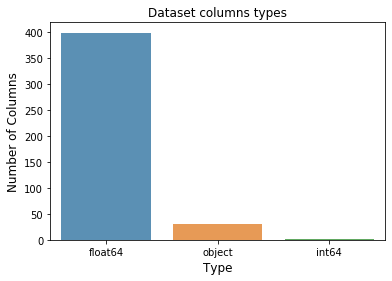

In [12]:
type_count = X_train.dtypes.value_counts()
sns.barplot(type_count.index.astype('str'), type_count.values, alpha=0.8)
plt.title('Dataset columns types')
plt.ylabel('Number of Columns', fontsize=12)
plt.xlabel('Type', fontsize=12)
plt.show()

In [13]:
X_train.select_dtypes(['object']).columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [14]:
cal_col  = []

In [15]:
for i in X_train.select_dtypes(['object']).columns:
    
    print("\n< {} >".format(i))
    print(X_train[i].value_counts())
    
    if len(X_train[i].value_counts()) < 30:
        cal_col.append(i)


< ProductCD >
W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

< card4 >
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

< card6 >
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

< P_emaildomain >
gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         

In [16]:
cal_col

['ProductCD',
 'card4',
 'card6',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType']

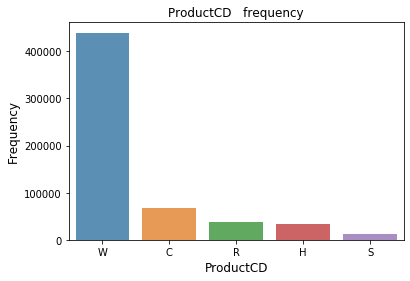

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64


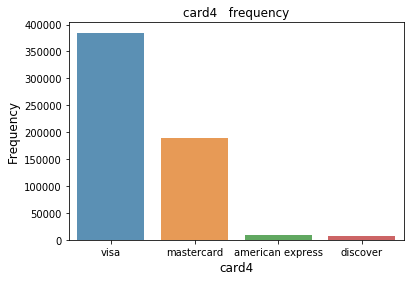

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64


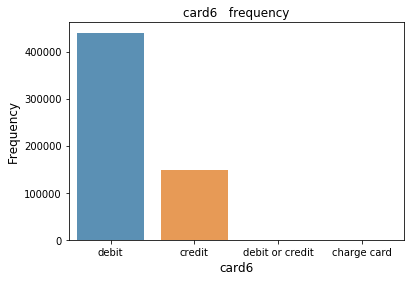

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64


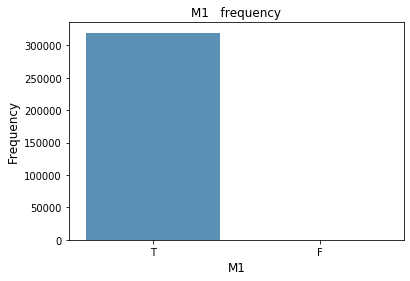

T    319415
F        25
Name: M1, dtype: int64


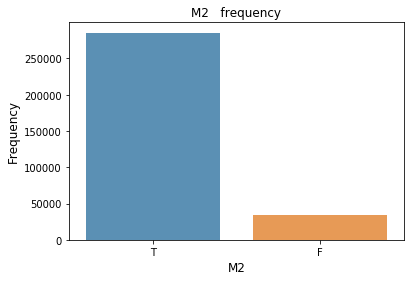

T    285468
F     33972
Name: M2, dtype: int64


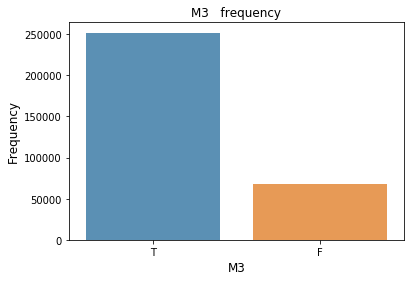

T    251731
F     67709
Name: M3, dtype: int64


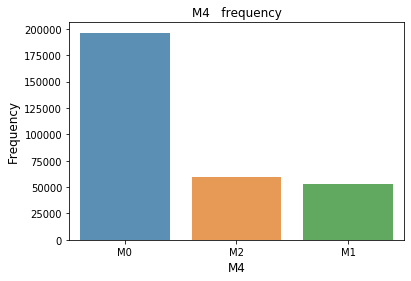

M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64


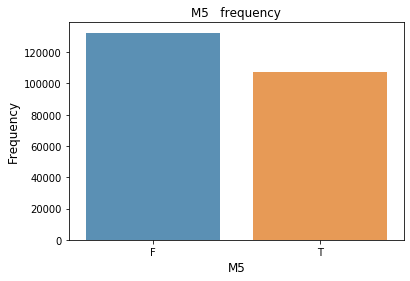

F    132491
T    107567
Name: M5, dtype: int64


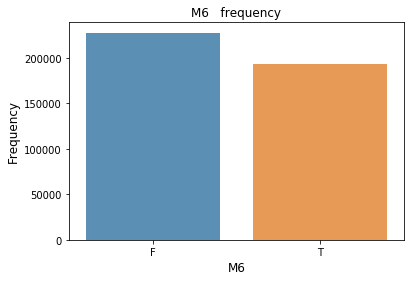

F    227856
T    193324
Name: M6, dtype: int64


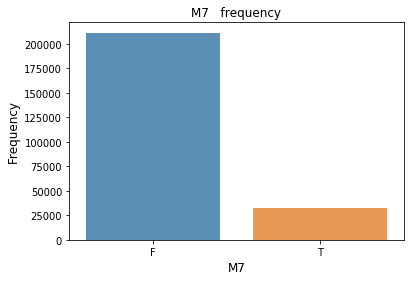

F    211374
T     32901
Name: M7, dtype: int64


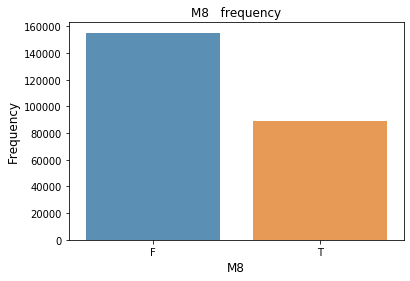

F    155251
T     89037
Name: M8, dtype: int64


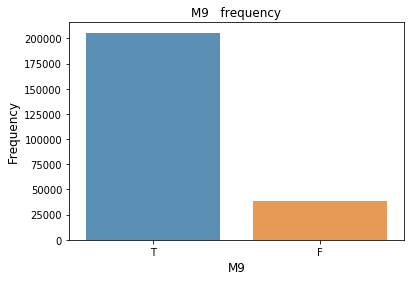

T    205656
F     38632
Name: M9, dtype: int64


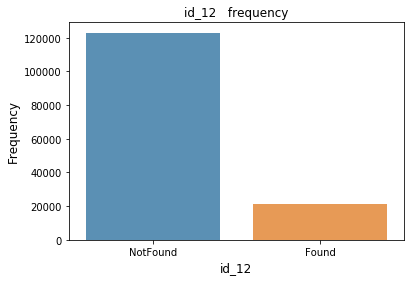

NotFound    123025
Found        21208
Name: id_12, dtype: int64


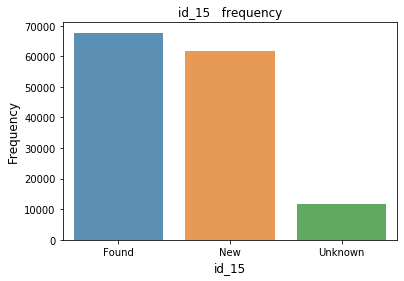

Found      67728
New        61612
Unknown    11645
Name: id_15, dtype: int64


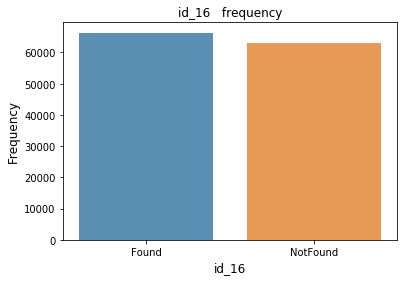

Found       66324
NotFound    63016
Name: id_16, dtype: int64


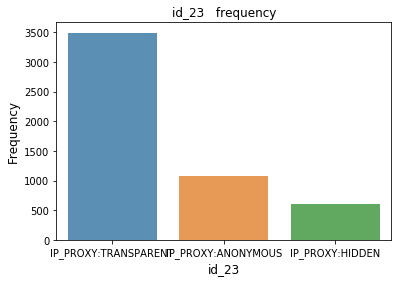

IP_PROXY:TRANSPARENT    3489
IP_PROXY:ANONYMOUS      1071
IP_PROXY:HIDDEN          609
Name: id_23, dtype: int64


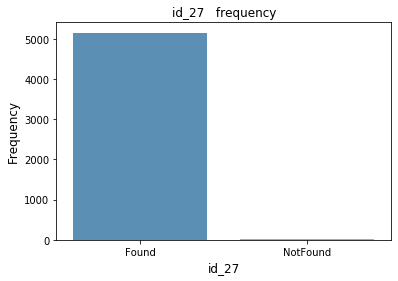

Found       5155
NotFound      14
Name: id_27, dtype: int64


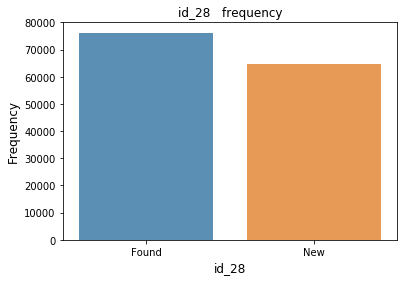

Found    76232
New      64746
Name: id_28, dtype: int64


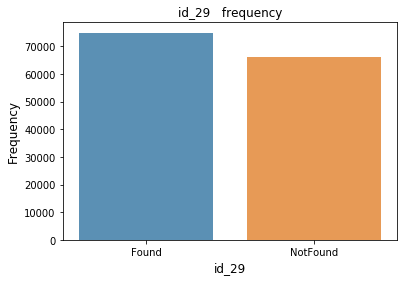

Found       74926
NotFound    66052
Name: id_29, dtype: int64


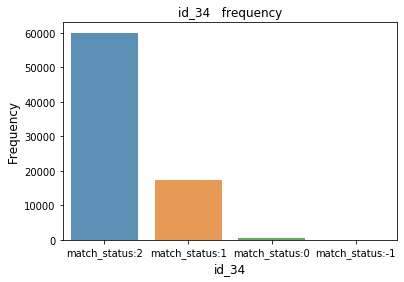

match_status:2     60011
match_status:1     17376
match_status:0       415
match_status:-1        3
Name: id_34, dtype: int64


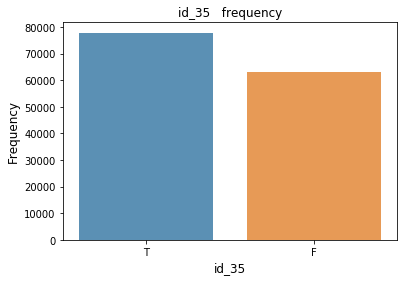

T    77814
F    63171
Name: id_35, dtype: int64


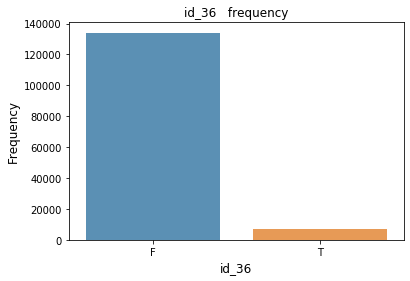

F    134066
T      6919
Name: id_36, dtype: int64


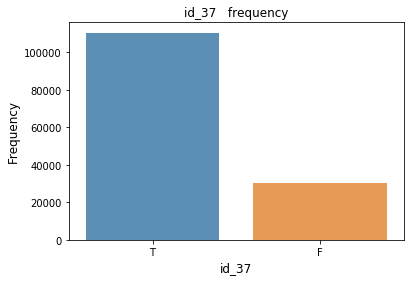

T    110452
F     30533
Name: id_37, dtype: int64


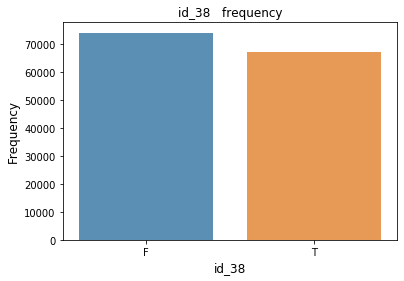

F    73922
T    67063
Name: id_38, dtype: int64


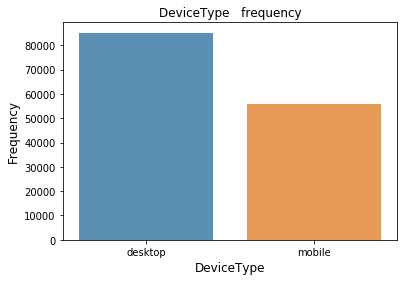

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64


In [17]:
for i in cal_col:

    v_col = X_train[i].value_counts().head()
    sns.barplot(v_col.index, v_col.values, alpha=0.8)
    plt.title(i+'   frequency')
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(i, fontsize=12)
    plt.show()
    print(X_train[i].value_counts())

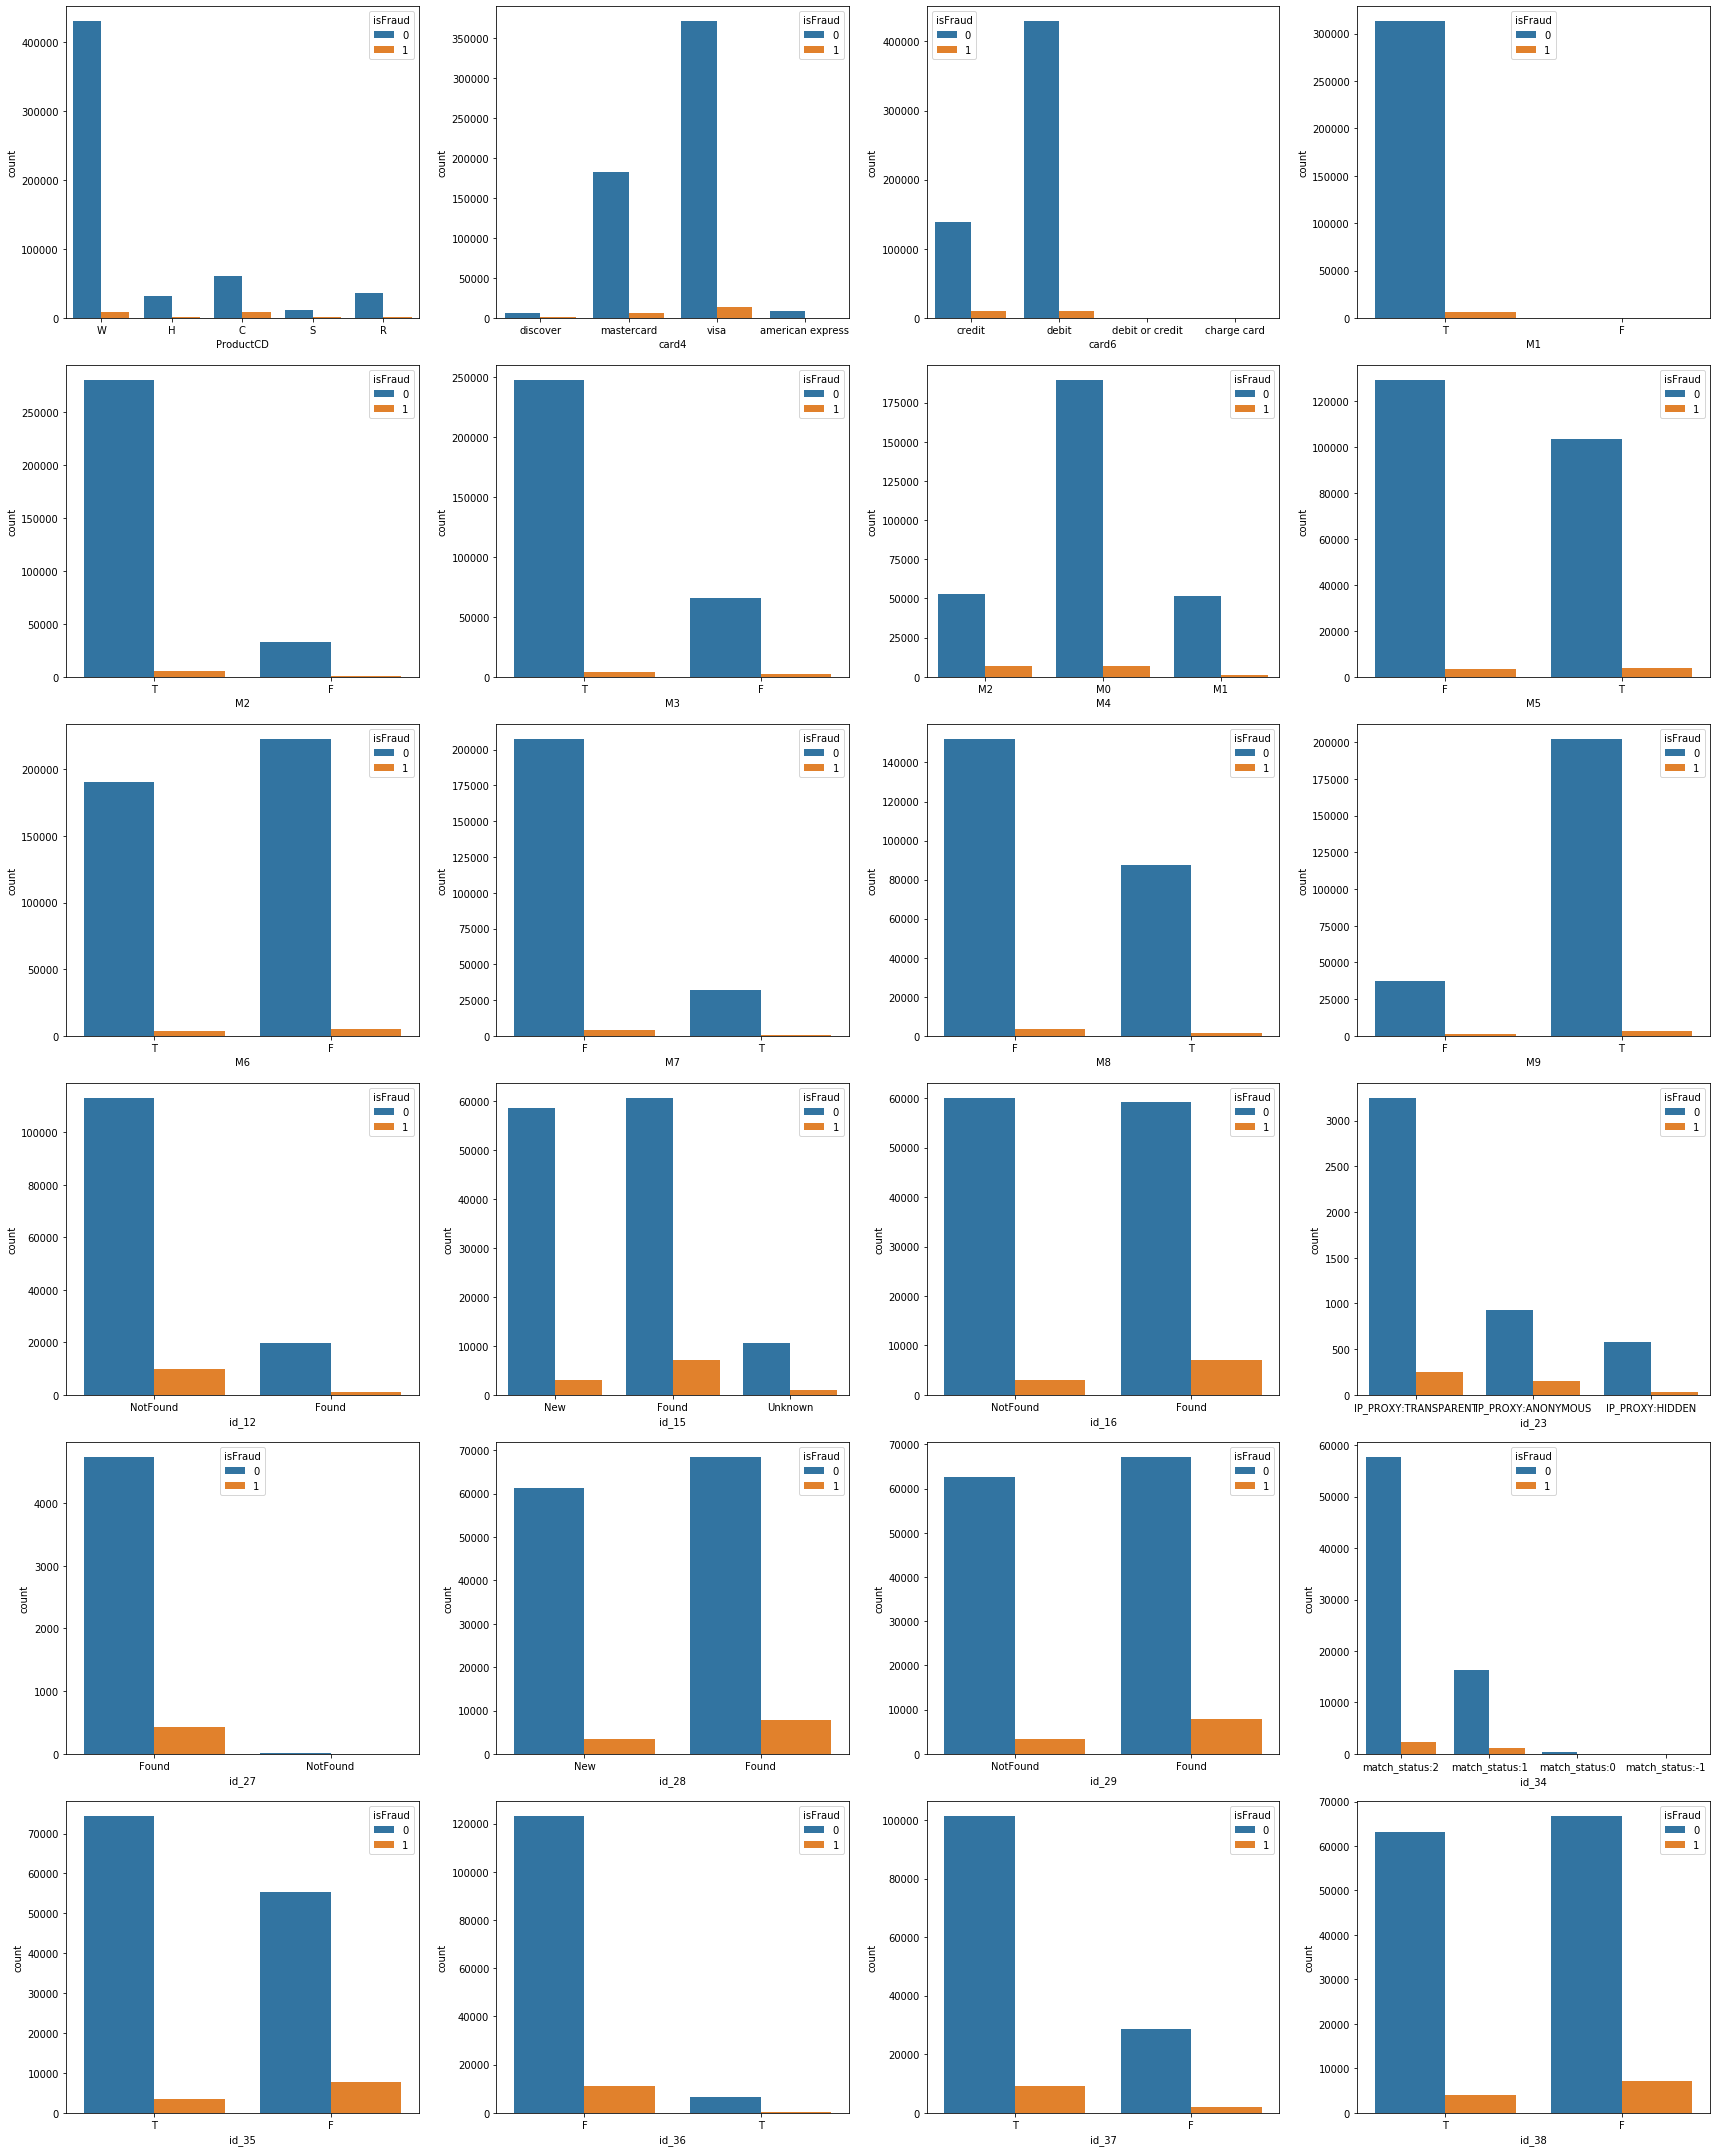

In [18]:
f, axes = plt.subplots(6, 4, figsize=(24, 30))

row, col, index = 0, 0, 0

for i in range(6):
    for j in range(4):
        sns.countplot(x=cal_col[index], data=X_train, hue=y_train, ax=axes[i][j])        
        index = index + 1

plt.tight_layout()

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.9+ GB


In [20]:
X_train.select_dtypes(['int64']).columns

Index(['TransactionDT', 'card1'], dtype='object')

In [21]:
df = X_train.merge(y_train, how='left', left_index=True, right_index=True)

In [22]:
df.head()

TransactionDT  TransactionAmt ProductCD  card1  card2  card3  \
TransactionID                                                                 
2987000                86400            68.5         W  13926    NaN  150.0   
2987001                86401            29.0         W   2755  404.0  150.0   
2987002                86469            59.0         W   4663  490.0  150.0   
2987003                86499            50.0         W  18132  567.0  150.0   
2987004                86506            50.0         H   4497  514.0  150.0   

                    card4  card5   card6  addr1  ...  id_32      id_33  \
TransactionID                                    ...                     
2987000          discover  142.0  credit  315.0  ...    NaN        NaN   
2987001        mastercard  102.0  credit  325.0  ...    NaN        NaN   
2987002              visa  166.0   debit  330.0  ...    NaN        NaN   
2987003        mastercard  117.0   debit  476.0  ...    NaN        NaN   
2987004        mastercard  102.0  credit  420.0  ...   32.0  2220x1080   

                        id_34 id_35 id_36  id_37  id_38  DeviceType  \
TransactionID                                                         
2987000                   NaN   NaN   NaN    NaN    NaN         NaN   
2987001                   NaN   NaN   NaN    NaN    NaN         NaN   
2987002                   NaN   NaN   NaN    NaN    NaN         NaN   
2987003                   NaN   NaN   NaN    NaN    NaN         NaN   
2987004        match_status:2     T     F      T      T      mobile   

                                  DeviceInfo  isFraud  
TransactionID                                          
2987000                                  NaN        0  
2987001                                  NaN        0  
2987002                                  NaN        0  
2987003                                  NaN        0  
2987004        SAMSUNG SM-G892A Build/NRD90M        0  

[5 rows x 433 columns]


< TransactionDT >


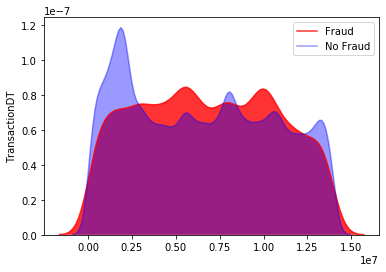

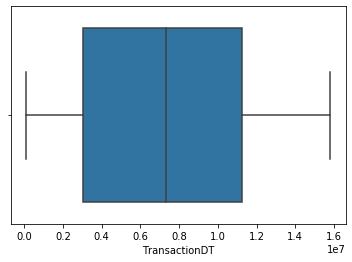


< card1 >


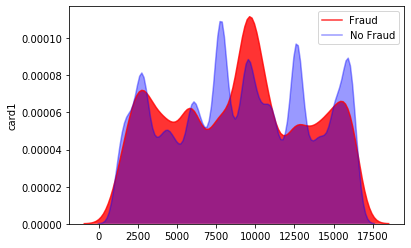

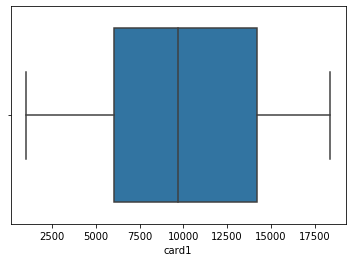

In [52]:
for cols in X_train.select_dtypes(['int64']).columns:
    
    print("\n< {} >".format(cols))
        
    sns.kdeplot(df[(df[cols] <= df[cols].quantile(0.9))&(df['isFraud']==1)][cols],color='red',
                shade=True, **{"label": "Fraud",'alpha':0.8})
    sns.kdeplot(df[(df[cols] <= df[cols].quantile(0.9))&(df['isFraud']==0)][cols],color='blue',
                shade=True,**{"label": "No Fraud",'alpha':0.4})
    plt.ylabel(cols)
    plt.show()
    
    sns.boxplot(X_train[cols])
    plt.show()
    
    



< TransactionAmt >


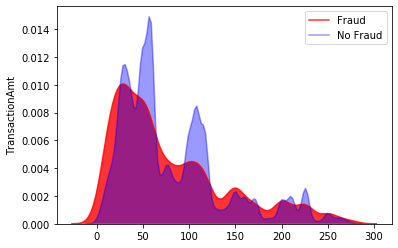

               mean       std    min        max
Fraud      149.2448  232.2122  0.292   5191.000
Not Fraud  134.5117  239.3951  0.251  31937.391


< card2 >


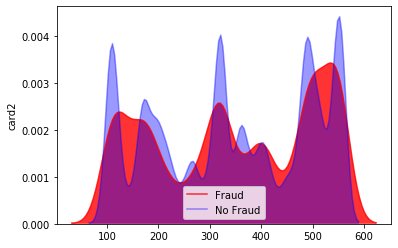

               mean       std    min    max
Fraud      365.3708  159.6235  100.0  600.0
Not Fraud  362.4540  157.7261  100.0  600.0


< card3 >


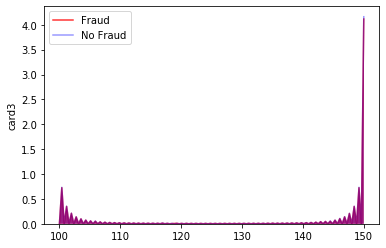

               mean      std    min    max
Fraud      162.3686  17.4958  100.0  231.0
Not Fraud  152.8620  10.9044  100.0  231.0


< card5 >


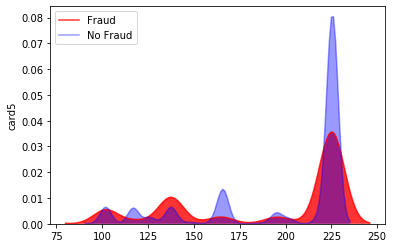

               mean      std    min    max
Fraud      191.9943  45.7799  100.0  237.0
Not Fraud  199.5422  41.0470  100.0  237.0


< addr1 >


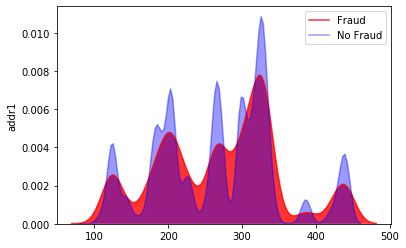

               mean       std    min    max
Fraud      294.3171  103.5850  110.0  536.0
Not Fraud  290.6433  101.6926  100.0  540.0


< addr2 >


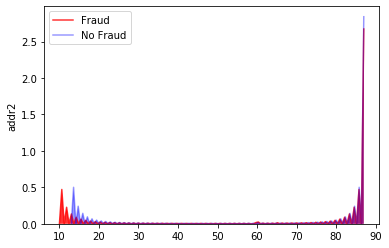

              mean     std   min    max
Fraud      86.2860  4.9362  10.0   96.0
Not Fraud  86.8136  2.6077  13.0  102.0


< dist1 >


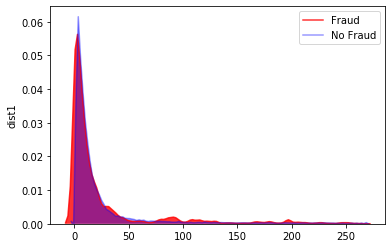

               mean       std  min      max
Fraud      174.5889  424.2323  0.0   4942.0
Not Fraud  117.3601  370.6419  0.0  10286.0


< dist2 >


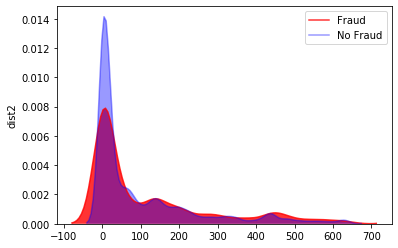

               mean       std  min      max
Fraud      201.4723  451.5896  0.0   9337.0
Not Fraud  235.1998  536.7985  0.0  11623.0


< C1 >


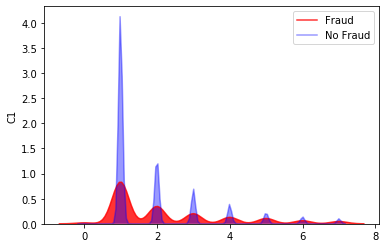

              mean       std  min     max
Fraud      35.5357  242.9763  0.0  4682.0
Not Fraud  13.3150  127.7880  0.0  4685.0


< C2 >


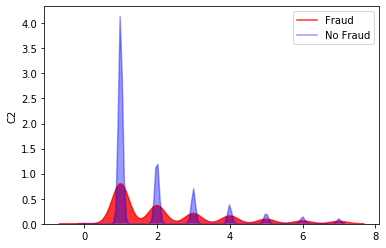

              mean       std  min     max
Fraud      45.5094  287.8136  0.0  5690.0
Not Fraud  14.1733  147.4859  0.0  5691.0


< C3 >


C:\Users\kt347\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\kt347\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


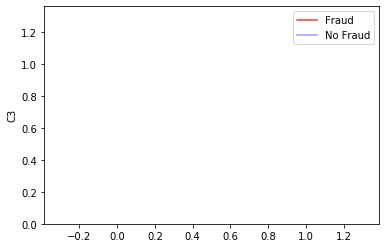

             mean     std  min   max
Fraud      0.0002  0.0156  0.0   1.0
Not Fraud  0.0058  0.1532  0.0  26.0


< C4 >


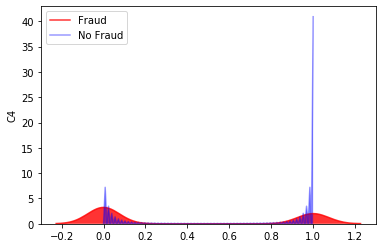

              mean       std  min     max
Fraud      15.0773  125.6737  0.0  2251.0
Not Fraud   3.6939   65.8393  0.0  2253.0


< C5 >


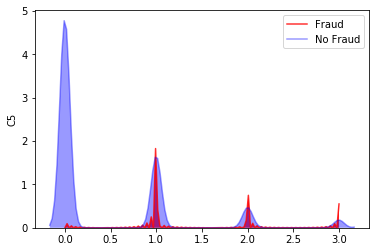

             mean      std  min    max
Fraud      1.4067  12.9461  0.0  331.0
Not Fraud  5.7225  26.1218  0.0  349.0


< C6 >


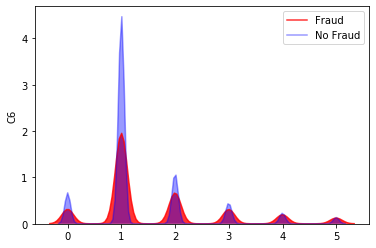

              mean       std  min     max
Fraud      16.9231  126.2988  0.0  2251.0
Not Fraud   8.7864   68.6892  0.0  2253.0


< C7 >


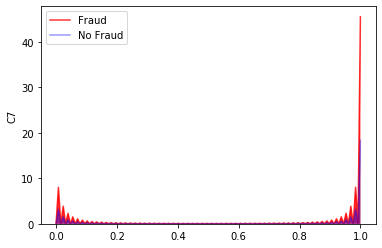

              mean       std  min     max
Fraud      11.9772  115.1432  0.0  2253.0
Not Fraud   2.5175   58.8608  0.0  2255.0


< C8 >


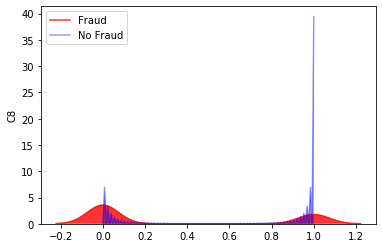

              mean       std  min     max
Fraud      21.2426  176.6958  0.0  3328.0
Not Fraud   4.5609   91.0230  0.0  3331.0


< C9 >


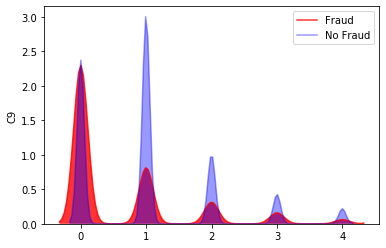

             mean      std  min    max
Fraud      1.7040   8.4533  0.0  192.0
Not Fraud  4.5809  16.8895  0.0  210.0


< C10 >


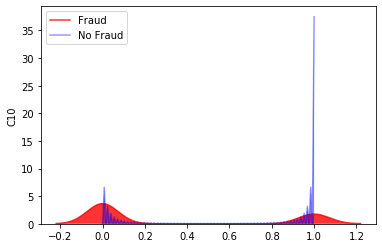

              mean       std  min     max
Fraud      19.4939  176.9192  0.0  3254.0
Not Fraud   4.7235   91.2391  0.0  3257.0


< C11 >


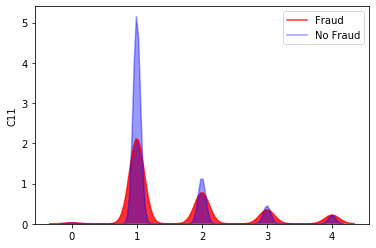

              mean       std  min     max
Fraud      23.8575  170.9662  0.0  3186.0
Not Fraud   9.7478   90.3066  0.0  3188.0


< C12 >


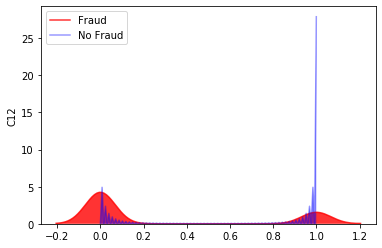

              mean       std  min     max
Fraud      18.5975  162.0825  0.0  3186.0
Not Fraud   3.5497   82.6012  0.0  3188.0


< C13 >


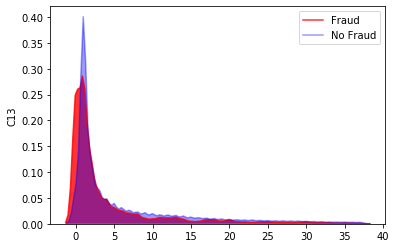

              mean       std  min     max
Fraud      24.9678  165.9790  0.0  2915.0
Not Fraud  32.8145  127.8322  0.0  2918.0


< C14 >


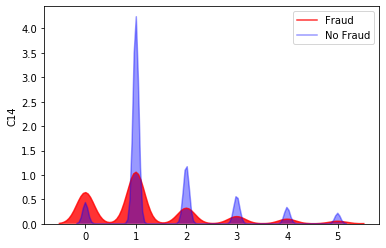

              mean      std  min     max
Fraud      10.3560  82.9026  0.0  1426.0
Not Fraud   8.2205  47.8987  0.0  1429.0


< D1 >


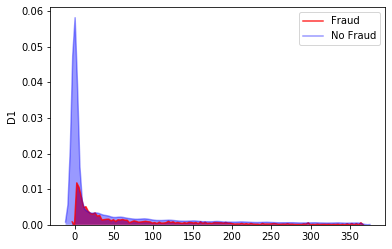

              mean       std  min    max
Fraud      38.7113  100.9156  0.0  637.0
Not Fraud  96.3647  158.9733  0.0  640.0


< D2 >


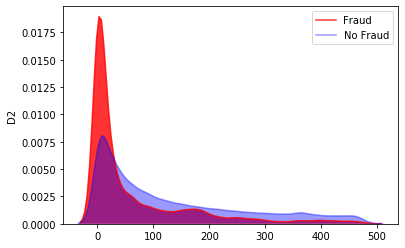

               mean       std  min    max
Fraud       77.7742  128.6978  0.0  637.0
Not Fraud  171.9562  177.7736  0.0  640.0


< D3 >


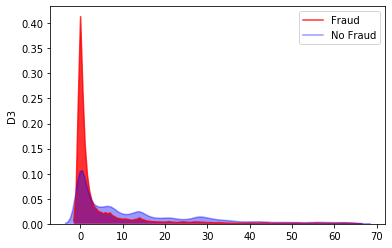

              mean      std  min    max
Fraud      11.7449  42.0055  0.0  582.0
Not Fraud  28.8454  62.8301  0.0  819.0


< D4 >


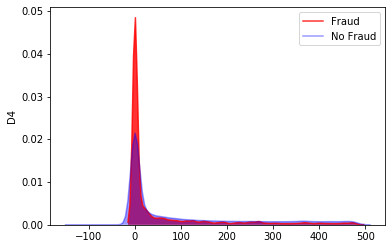

               mean       std    min    max
Fraud       72.1029  140.6561    0.0  667.0
Not Fraud  142.4323  192.2134 -122.0  869.0


< D5 >


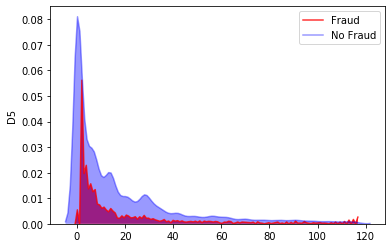

              mean      std  min    max
Fraud      13.6878  51.8916  0.0  625.0
Not Fraud  43.4912  89.9857  0.0  819.0


< D6 >


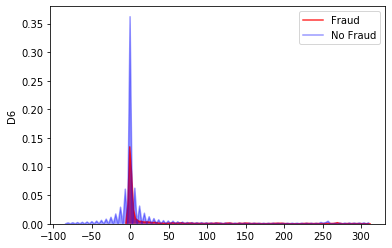

              mean       std   min    max
Fraud      45.8564  101.4244   0.0  694.0
Not Fraud  72.6290  147.6010 -83.0  873.0


< D7 >


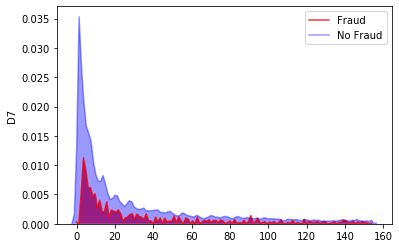

              mean       std  min    max
Fraud      11.2922   46.7431  0.0  547.0
Not Fraud  46.9430  105.4358  0.0  843.0


< D8 >


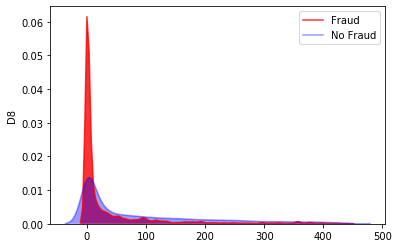

               mean       std  min        max
Fraud       49.3092  133.2550  0.0  1290.5834
Not Fraud  157.3437  237.9878  0.0  1707.7916


< D9 >


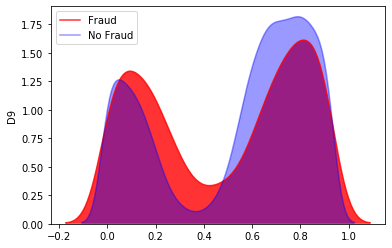

             mean     std  min     max
Fraud      0.5200  0.3332  0.0  0.9583
Not Fraud  0.5658  0.3146  0.0  0.9583


< D10 >


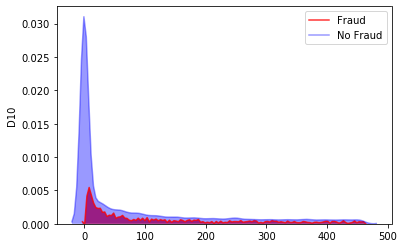

               mean       std  min    max
Fraud       52.3637  127.0511  0.0  664.0
Not Fraud  126.3961  183.7106  0.0  876.0


< D11 >


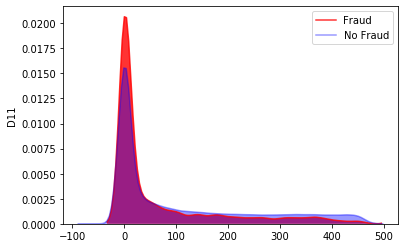

               mean       std   min    max
Fraud       87.3144  146.5610   0.0  655.0
Not Fraud  147.8082  186.5554 -53.0  670.0


< D12 >


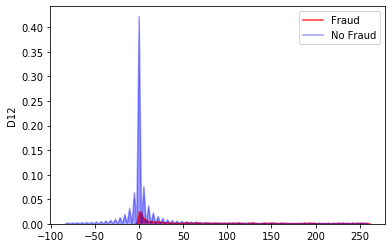

              mean       std   min    max
Fraud      44.2026   99.3494   0.0  602.0
Not Fraud  55.3458  127.1661 -83.0  648.0


< D13 >


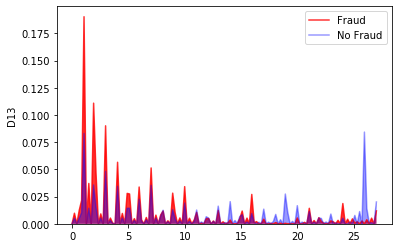

              mean      std  min    max
Fraud       6.4923  31.3304  0.0  745.0
Not Fraud  19.3166  70.7032  0.0  847.0


< D14 >


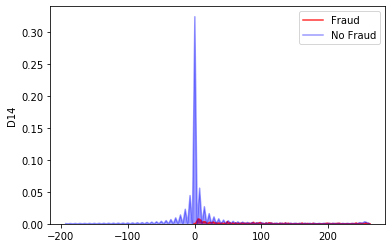

              mean       std    min    max
Fraud      54.4646  126.5861    0.0  847.0
Not Fraud  58.1522  137.5329 -193.0  878.0


< D15 >


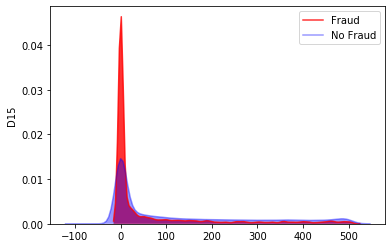

               mean       std   min    max
Fraud       78.2458  151.9568   0.0  835.0
Not Fraud  166.6331  203.5957 -83.0  879.0


< V1 >


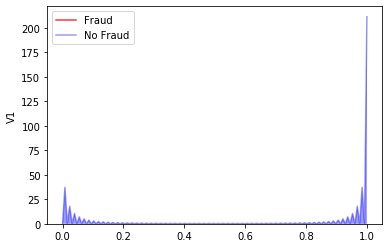

             mean     std  min  max
Fraud      1.0000  0.0000  1.0  1.0
Not Fraud  0.9999  0.0075  0.0  1.0


< V2 >


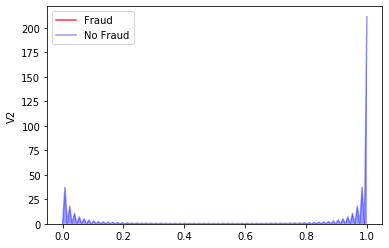

             mean     std  min  max
Fraud      1.0789  0.3514  1.0  6.0
Not Fraud  1.0445  0.2373  0.0  8.0


< V3 >


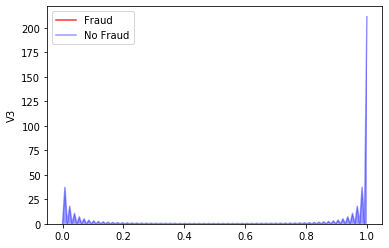

             mean     std  min  max
Fraud      1.1898  0.5419  1.0  7.0
Not Fraud  1.0758  0.3145  0.0  9.0


< V4 >


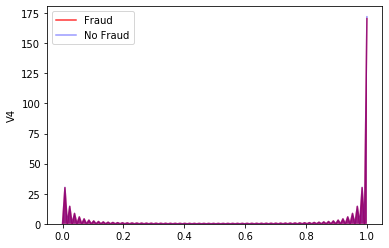

             mean     std  min  max
Fraud      0.8857  0.5049  0.0  4.0
Not Fraud  0.8457  0.4386  0.0  6.0


< V5 >


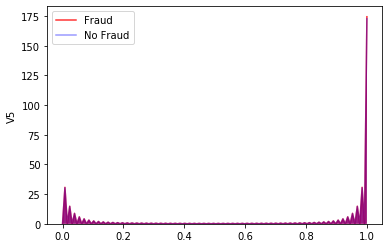

             mean     std  min  max
Fraud      1.0011  0.6654  0.0  6.0
Not Fraud  0.8745  0.4710  0.0  6.0


< V6 >


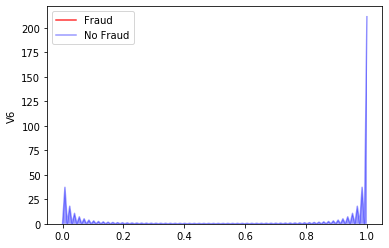

             mean     std  min  max
Fraud      1.0635  0.3107  1.0  6.0
Not Fraud  1.0453  0.2377  0.0  9.0


< V7 >


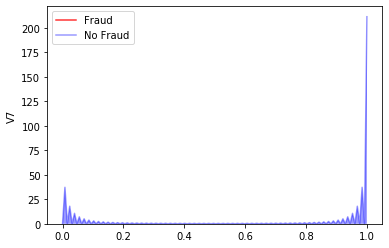

             mean     std  min  max
Fraud      1.1235  0.4133  1.0  6.0
Not Fraud  1.0719  0.3021  0.0  9.0


< V8 >


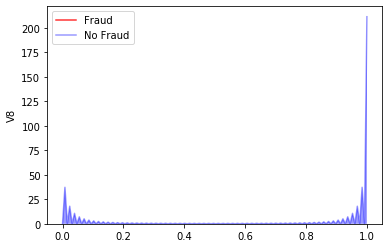

             mean     std  min  max
Fraud      1.0488  0.2713  1.0  5.0
Not Fraud  1.0273  0.1839  0.0  8.0


< V9 >


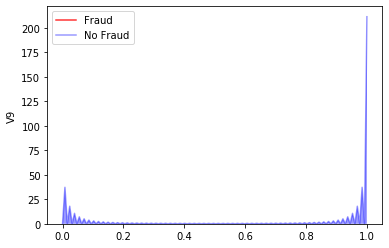

             mean     std  min  max
Fraud      1.1022  0.3566  1.0  5.0
Not Fraud  1.0403  0.2228  0.0  8.0


< V10 >


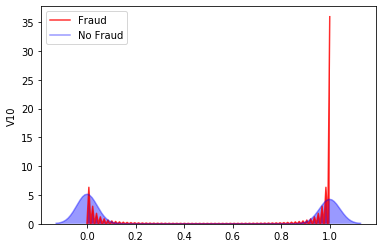

             mean     std  min  max
Fraud      0.1887  0.4211  0.0  4.0
Not Fraud  0.4694  0.5219  0.0  4.0


< V11 >


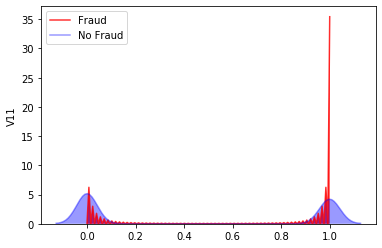

             mean     std  min  max
Fraud      0.1980  0.4477  0.0  4.0
Not Fraud  0.4846  0.5529  0.0  5.0


< V12 >


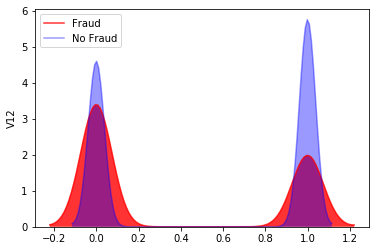

             mean     std  min  max
Fraud      0.4140  0.5487  0.0  3.0
Not Fraud  0.5646  0.5085  0.0  3.0


< V13 >


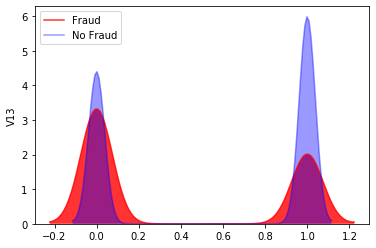

             mean     std  min  max
Fraud      0.4667  0.6200  0.0  5.0
Not Fraud  0.6036  0.5284  0.0  6.0


< V14 >


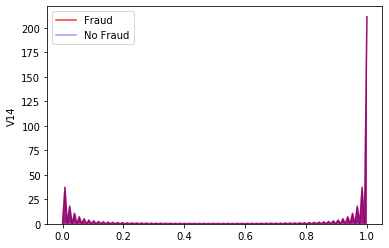

             mean     std  min  max
Fraud      0.9998  0.0154  0.0  1.0
Not Fraud  0.9995  0.0225  0.0  1.0


< V15 >


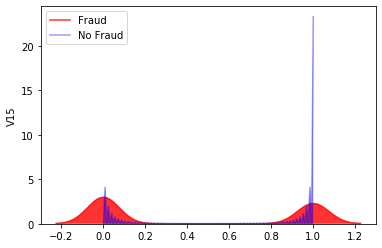

             mean     std  min  max
Fraud      0.4446  0.5146  0.0  5.0
Not Fraud  0.1115  0.3189  0.0  7.0


< V16 >


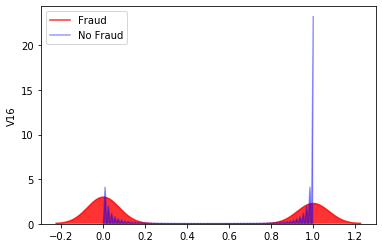

             mean     std  min   max
Fraud      0.4490  0.5309  0.0   6.0
Not Fraud  0.1125  0.3291  0.0  15.0


< V17 >


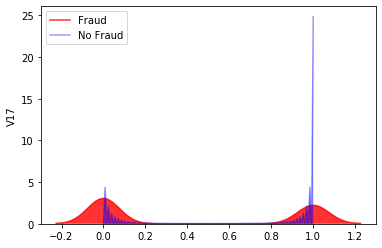

             mean     std  min   max
Fraud      0.4967  0.7385  0.0  15.0
Not Fraud  0.1218  0.3381  0.0   9.0


< V18 >


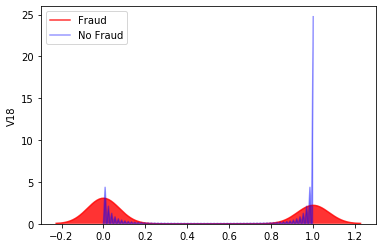

             mean     std  min   max
Fraud      0.5050  0.7558  0.0  15.0
Not Fraud  0.1229  0.3448  0.0   9.0


< V19 >


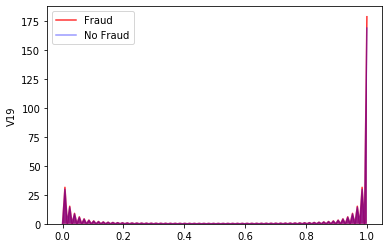

            mean     std  min  max
Fraud      0.888  0.4292  0.0  5.0
Not Fraud  0.814  0.4252  0.0  7.0


< V20 >


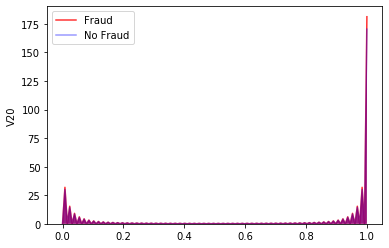

             mean     std  min   max
Fraud      0.9488  0.5258  0.0   6.0
Not Fraud  0.8444  0.4567  0.0  15.0


< V21 >


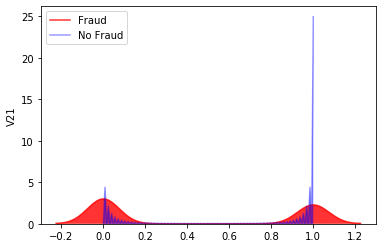

             mean     std  min  max
Fraud      0.4362  0.5030  0.0  4.0
Not Fraud  0.1194  0.3272  0.0  5.0


< V22 >


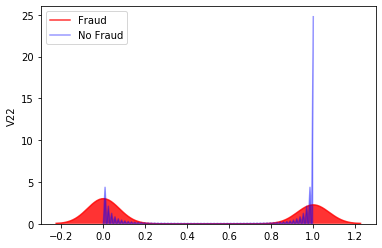

             mean     std  min  max
Fraud      0.4432  0.5256  0.0  6.0
Not Fraud  0.1218  0.3476  0.0  8.0


< V23 >


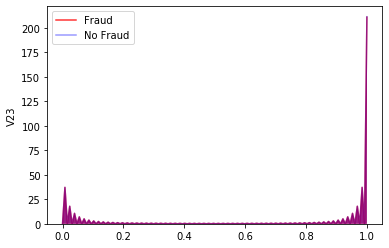

             mean     std  min   max
Fraud      1.2363  0.8601  0.0  13.0
Not Fraud  1.0280  0.1925  0.0   9.0


< V24 >


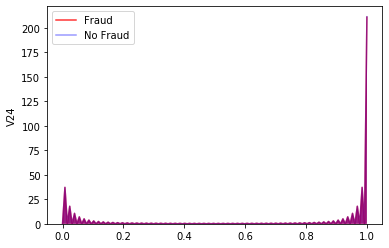

             mean     std  min   max
Fraud      1.2641  0.8895  0.0  13.0
Not Fraud  1.0512  0.2614  0.0  12.0


< V25 >


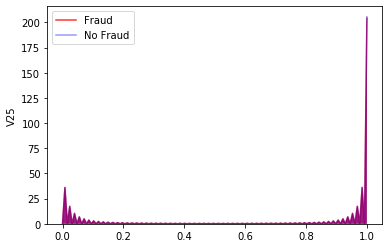

             mean     std  min  max
Fraud      0.9815  0.2357  0.0  5.0
Not Fraud  0.9775  0.1833  0.0  7.0


< V26 >


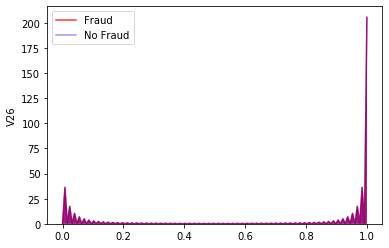

             mean     std  min   max
Fraud      1.0062  0.2894  0.0   7.0
Not Fraud  0.9874  0.2060  0.0  13.0


< V27 >


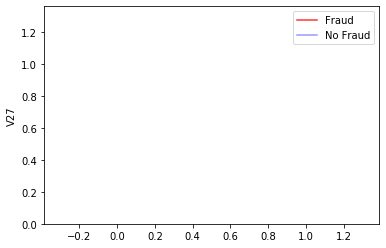

             mean     std  min  max
Fraud      0.0000  0.0000  0.0  0.0
Not Fraud  0.0008  0.0291  0.0  4.0


< V28 >


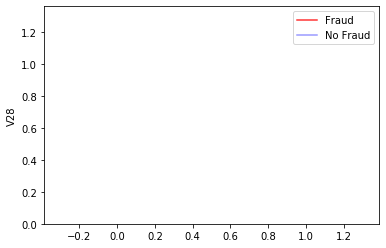

             mean     std  min  max
Fraud      0.0000  0.0000  0.0  0.0
Not Fraud  0.0009  0.0317  0.0  4.0


< V29 >


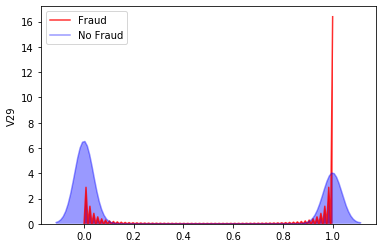

             mean     std  min  max
Fraud      0.0879  0.3073  0.0  4.0
Not Fraud  0.3980  0.5131  0.0  5.0


< V30 >


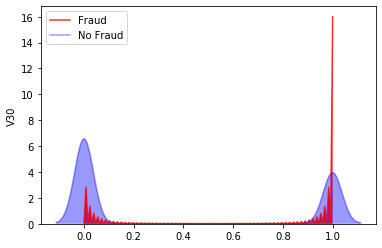

             mean     std  min  max
Fraud      0.0952  0.3349  0.0  5.0
Not Fraud  0.4169  0.5572  0.0  9.0


< V31 >


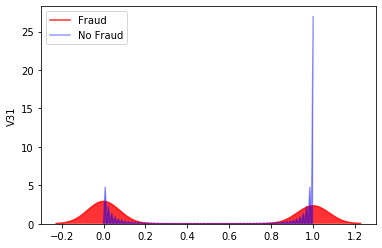

             mean     std  min  max
Fraud      0.4570  0.5164  0.0  5.0
Not Fraud  0.1301  0.3441  0.0  7.0


< V32 >


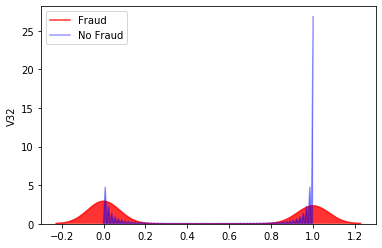

             mean     std  min   max
Fraud      0.4638  0.5389  0.0   6.0
Not Fraud  0.1316  0.3561  0.0  15.0


< V33 >


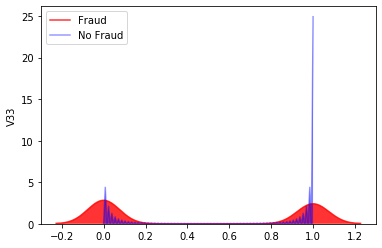

             mean     std  min  max
Fraud      0.4714  0.5184  0.0  5.0
Not Fraud  0.1192  0.3272  0.0  7.0


< V34 >


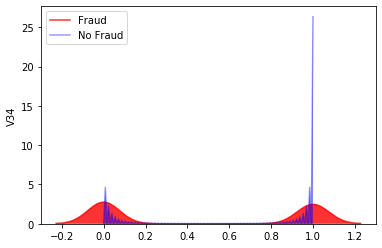

             mean     std  min   max
Fraud      0.4903  0.5384  0.0   7.0
Not Fraud  0.1273  0.3436  0.0  13.0


< V35 >


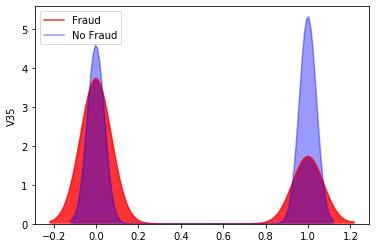

             mean     std  min  max
Fraud      0.3323  0.4902  0.0  3.0
Not Fraud  0.5501  0.5153  0.0  3.0


< V36 >


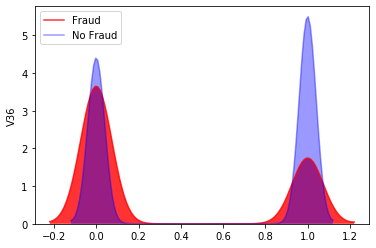

             mean     std  min  max
Fraud      0.3801  0.5604  0.0  4.0
Not Fraud  0.5863  0.5369  0.0  5.0


< V37 >


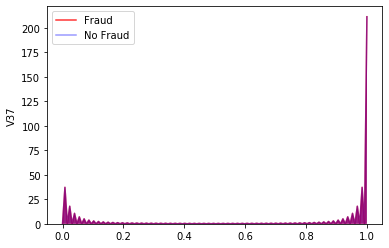

             mean     std  min   max
Fraud      1.7540  2.6293  0.0  54.0
Not Fraud  1.0849  0.4807  0.0  19.0


< V38 >


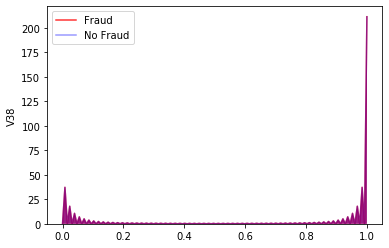

             mean     std  min   max
Fraud      2.0659  3.2028  0.0  54.0
Not Fraud  1.1301  0.6056  0.0  27.0


< V39 >


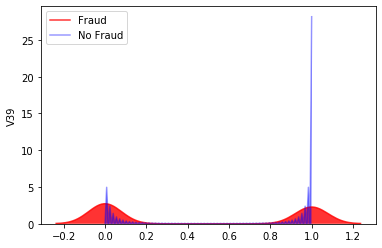

             mean     std  min   max
Fraud      0.6513  0.9479  0.0  14.0
Not Fraud  0.1487  0.4131  0.0  15.0


< V40 >


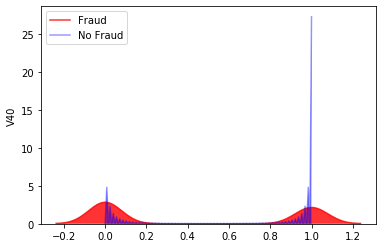

             mean     std  min   max
Fraud      0.7451  1.1546  0.0  24.0
Not Fraud  0.1568  0.4531  0.0  15.0


< V41 >


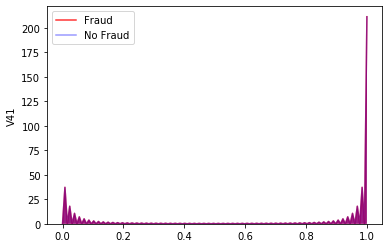

             mean     std  min  max
Fraud      0.9999  0.0117  0.0  1.0
Not Fraud  0.9992  0.0274  0.0  1.0


< V42 >


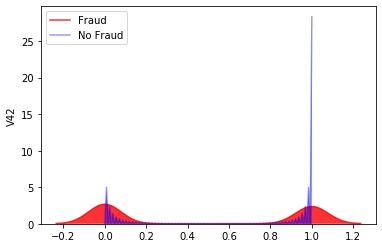

             mean     std  min  max
Fraud      0.5395  0.5967  0.0  5.0
Not Fraud  0.1424  0.3656  0.0  8.0


< V43 >


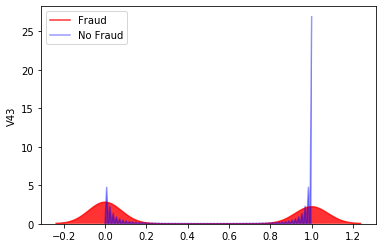

             mean     std  min  max
Fraud      0.6231  0.7698  0.0  7.0
Not Fraud  0.1527  0.4070  0.0  8.0


< V44 >


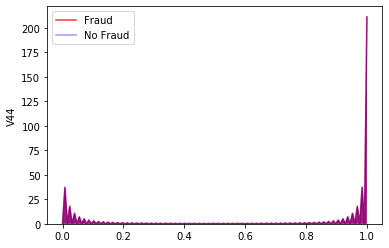

             mean     std  min   max
Fraud      1.9635  3.0113  0.0  48.0
Not Fraud  1.0524  0.2644  0.0  15.0


< V45 >


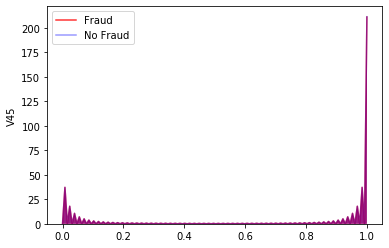

             mean     std  min   max
Fraud      2.2079  3.2908  0.0  48.0
Not Fraud  1.0819  0.3468  0.0  20.0


< V46 >


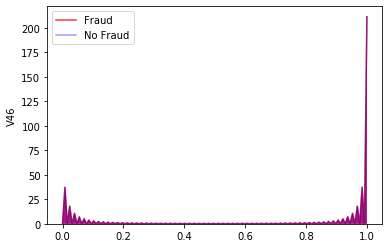

             mean     std  min  max
Fraud      1.1333  0.4480  0.0  6.0
Not Fraud  1.0183  0.1454  0.0  4.0


< V47 >


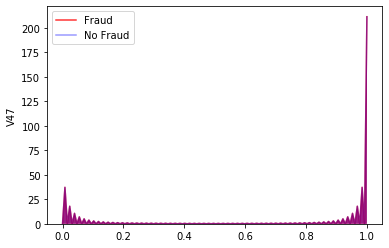

             mean     std  min   max
Fraud      1.2397  0.7077  0.0  12.0
Not Fraud  1.0313  0.1904  0.0   6.0


< V48 >


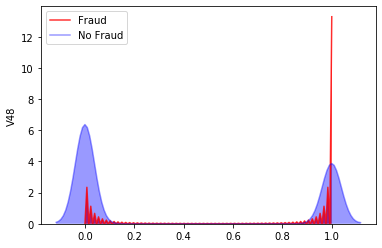

             mean     std  min  max
Fraud      0.0721  0.2809  0.0  4.0
Not Fraud  0.3943  0.5110  0.0  5.0


< V49 >


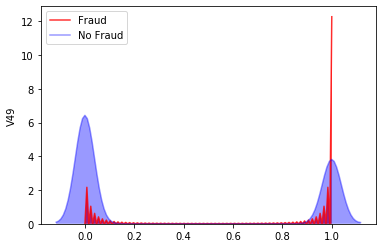

             mean     std  min  max
Fraud      0.0796  0.3173  0.0  5.0
Not Fraud  0.4091  0.5456  0.0  5.0


< V50 >


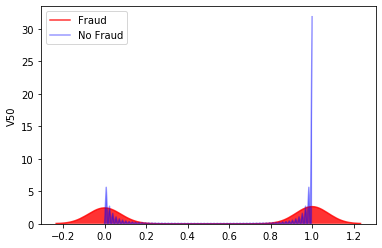

             mean     std  min  max
Fraud      0.5205  0.5018  0.0  4.0
Not Fraud  0.1520  0.3622  0.0  5.0


< V51 >


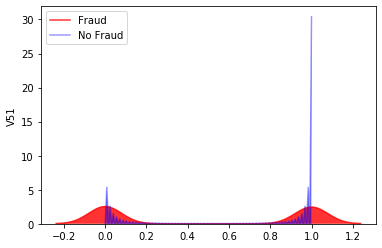

             mean     std  min  max
Fraud      0.6471  0.7243  0.0  6.0
Not Fraud  0.1535  0.3765  0.0  4.0


< V52 >


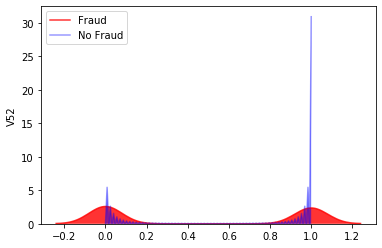

             mean     std  min   max
Fraud      0.7384  0.9244  0.0  12.0
Not Fraud  0.1628  0.3970  0.0   6.0


< V53 >


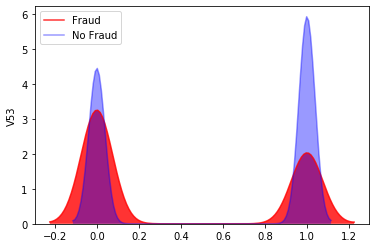

            mean     std  min  max
Fraud      0.443  0.5660  0.0  3.0
Not Fraud  0.582  0.5091  0.0  5.0


< V54 >


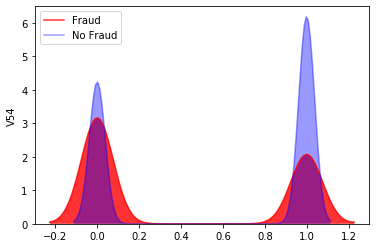

             mean     std  min  max
Fraud      0.5102  0.6541  0.0  6.0
Not Fraud  0.6235  0.5299  0.0  5.0


< V55 >


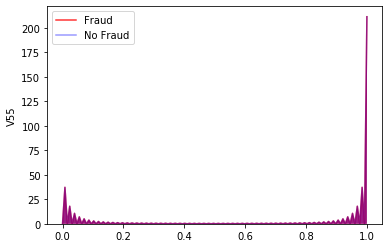

             mean     std  min   max
Fraud      1.1765  0.5846  0.0   8.0
Not Fraud  1.0641  0.3829  0.0  17.0


< V56 >


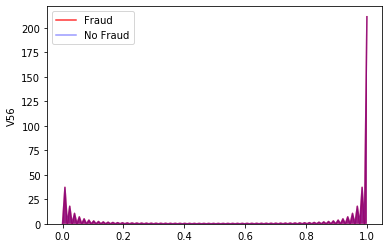

             mean     std  min   max
Fraud      1.3460  1.1988  0.0  30.0
Not Fraud  1.1137  0.6348  0.0  51.0


< V57 >


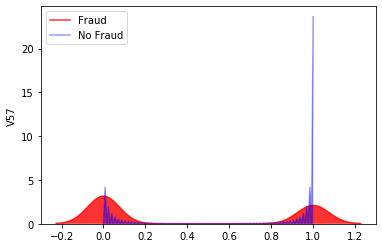

             mean     std  min  max
Fraud      0.4554  0.5753  0.0  5.0
Not Fraud  0.1177  0.3339  0.0  6.0


< V58 >


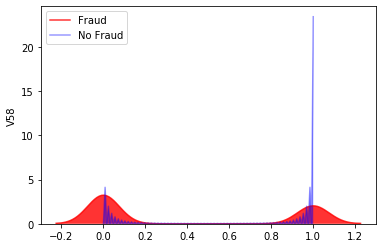

             mean     std  min   max
Fraud      0.4905  0.6500  0.0   7.0
Not Fraud  0.1208  0.3543  0.0  10.0


< V59 >


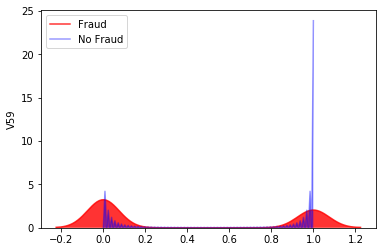

             mean     std  min   max
Fraud      0.4523  0.6003  0.0   5.0
Not Fraud  0.1241  0.3653  0.0  16.0


< V60 >


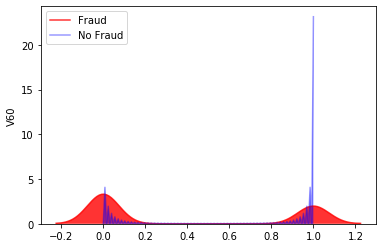

             mean     std  min   max
Fraud      0.4928  0.6881  0.0   9.0
Not Fraud  0.1312  0.4014  0.0  16.0


< V61 >


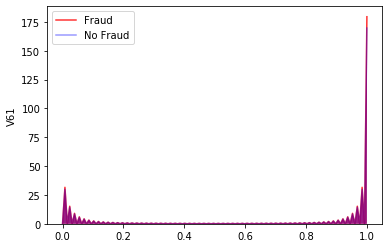

             mean     std  min  max
Fraud      0.9495  0.5031  0.0  6.0
Not Fraud  0.8259  0.4337  0.0  6.0


< V62 >


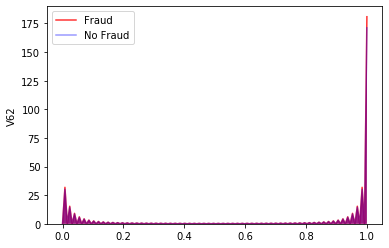

             mean     std  min   max
Fraud      1.0619  0.6854  0.0   7.0
Not Fraud  0.8612  0.4745  0.0  10.0


< V63 >


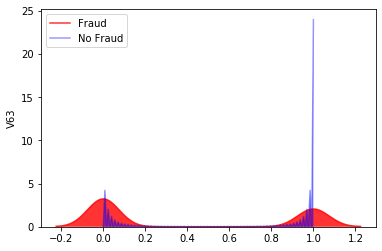

             mean     std  min  max
Fraud      0.4330  0.5578  0.0  4.0
Not Fraud  0.1209  0.3423  0.0  7.0


< V64 >


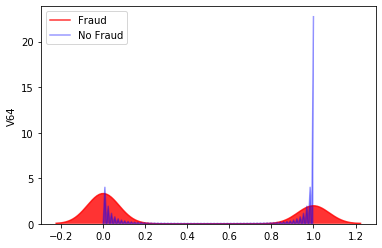

             mean     std  min  max
Fraud      0.4807  0.6640  0.0  7.0
Not Fraud  0.1308  0.3901  0.0  7.0


< V65 >


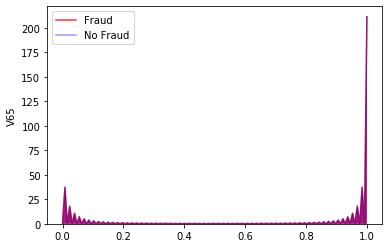

             mean     std  min  max
Fraud      0.9999  0.0079  0.0  1.0
Not Fraud  0.9997  0.0186  0.0  1.0


< V66 >


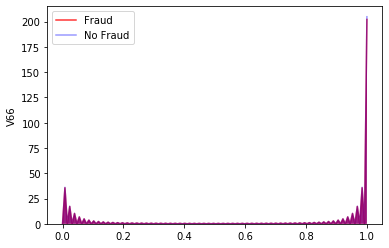

             mean     std  min  max
Fraud      1.0262  0.3636  0.0  6.0
Not Fraud  0.9796  0.2096  0.0  7.0


< V67 >


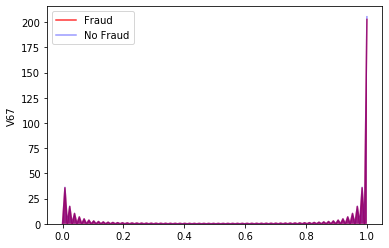

             mean     std  min  max
Fraud      1.1021  0.4849  0.0  8.0
Not Fraud  0.9947  0.2333  0.0  7.0


< V68 >


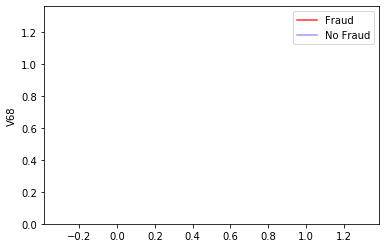

             mean     std  min  max
Fraud      0.0000  0.0000  0.0  0.0
Not Fraud  0.0006  0.0241  0.0  2.0


< V69 >


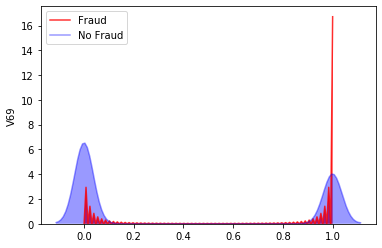

             mean     std  min  max
Fraud      0.0923  0.3211  0.0  5.0
Not Fraud  0.3999  0.5159  0.0  4.0


< V70 >


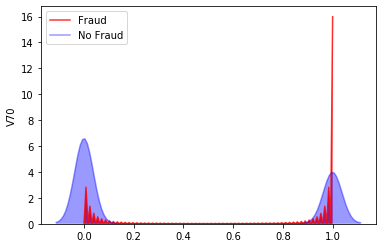

             mean     std  min  max
Fraud      0.0975  0.3447  0.0  6.0
Not Fraud  0.4180  0.5571  0.0  5.0


< V71 >


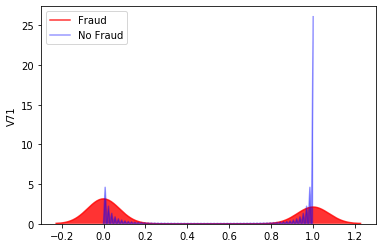

             mean     std  min  max
Fraud      0.4577  0.5754  0.0  5.0
Not Fraud  0.1303  0.3506  0.0  6.0


< V72 >


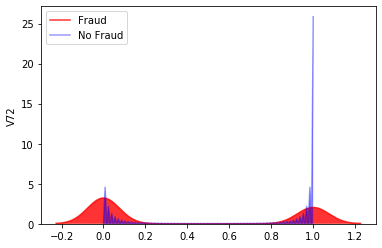

             mean     std  min   max
Fraud      0.4927  0.6498  0.0   7.0
Not Fraud  0.1338  0.3723  0.0  10.0


< V73 >


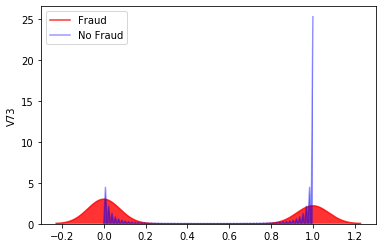

             mean     std  min  max
Fraud      0.4941  0.6054  0.0  6.0
Not Fraud  0.1285  0.3508  0.0  7.0


< V74 >


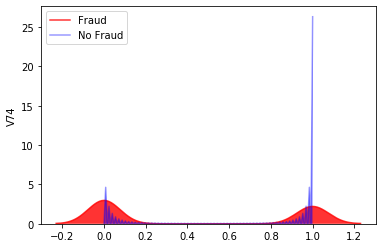

             mean     std  min  max
Fraud      0.5578  0.6989  0.0  8.0
Not Fraud  0.1390  0.3719  0.0  7.0


< V75 >


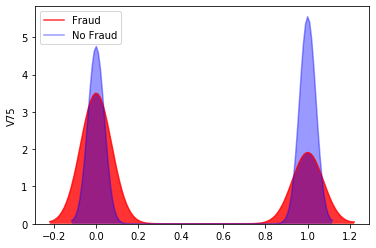

             mean     std  min  max
Fraud      0.3983  0.5458  0.0  3.0
Not Fraud  0.5492  0.5125  0.0  4.0


< V76 >


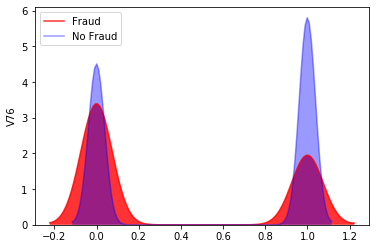

             mean     std  min  max
Fraud      0.4516  0.6241  0.0  6.0
Not Fraud  0.5921  0.5345  0.0  5.0


< V77 >


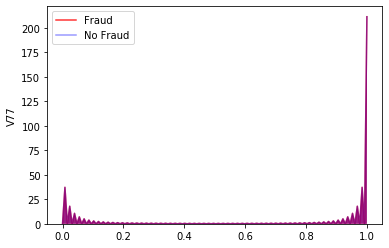

             mean     std  min   max
Fraud      1.5461  1.6774  0.0  30.0
Not Fraud  1.0714  0.4373  0.0  19.0


< V78 >


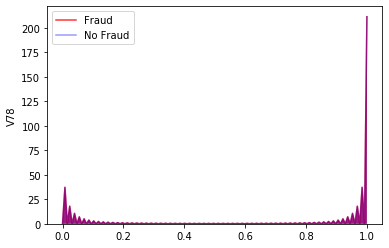

             mean     std  min   max
Fraud      1.7840  2.3664  0.0  31.0
Not Fraud  1.1229  0.6541  0.0  25.0


< V79 >


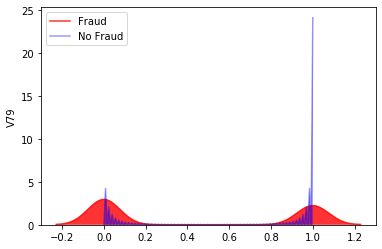

             mean     std  min  max
Fraud      0.5381  0.6670  0.0  6.0
Not Fraud  0.1233  0.3585  0.0  7.0


< V80 >


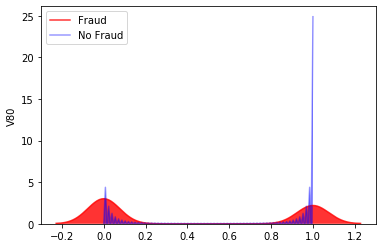

             mean     std  min   max
Fraud      0.5460  0.8655  0.0  19.0
Not Fraud  0.1304  0.3778  0.0  15.0


< V81 >


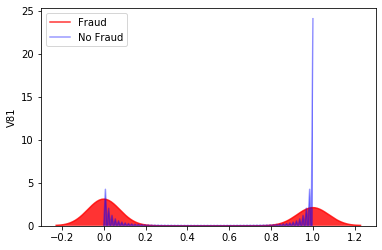

             mean     std  min   max
Fraud      0.6015  0.9761  0.0  19.0
Not Fraud  0.1375  0.4150  0.0  15.0


< V82 >


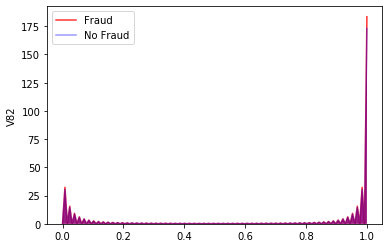

             mean     std  min  max
Fraud      0.9621  0.4908  0.0  6.0
Not Fraud  0.8406  0.4195  0.0  7.0


< V83 >


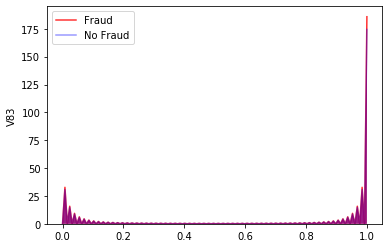

             mean     std  min  max
Fraud      1.0591  0.6212  0.0  6.0
Not Fraud  0.8760  0.4636  0.0  7.0


< V84 >


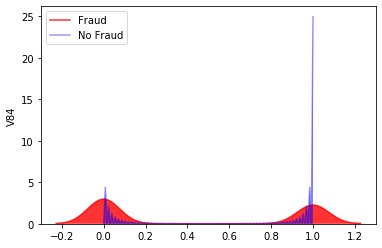

             mean     std  min  max
Fraud      0.4701  0.5542  0.0  4.0
Not Fraud  0.1259  0.3480  0.0  7.0


< V85 >


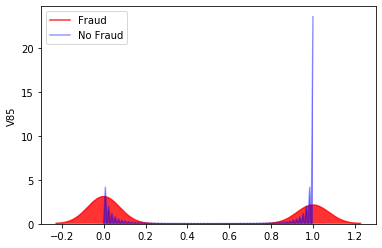

             mean     std  min  max
Fraud      0.5351  0.7076  0.0  7.0
Not Fraud  0.1368  0.3997  0.0  7.0


< V86 >


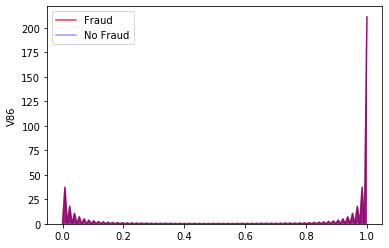

             mean     std  min   max
Fraud      1.6400  1.7375  0.0  30.0
Not Fraud  1.0455  0.2620  0.0  15.0


< V87 >


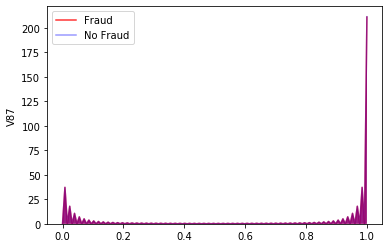

             mean     std  min   max
Fraud      1.7997  2.0204  0.0  30.0
Not Fraud  1.0758  0.3394  0.0  19.0


< V88 >


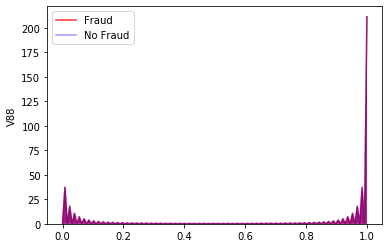

             mean     std  min  max
Fraud      0.9993  0.0259  0.0  1.0
Not Fraud  0.9992  0.0275  0.0  1.0


< V89 >


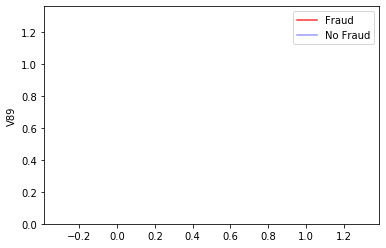

             mean     std  min  max
Fraud      0.0000  0.0000  0.0  0.0
Not Fraud  0.0009  0.0325  0.0  2.0


< V90 >


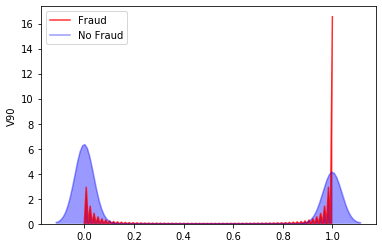

             mean     std  min  max
Fraud      0.0925  0.3228  0.0  5.0
Not Fraud  0.4123  0.5182  0.0  5.0


< V91 >


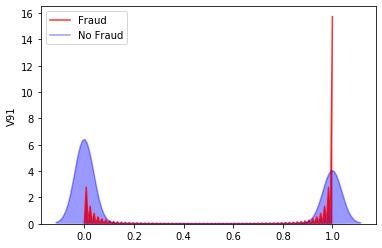

             mean     std  min  max
Fraud      0.0981  0.3492  0.0  6.0
Not Fraud  0.4314  0.5645  0.0  6.0


< V92 >


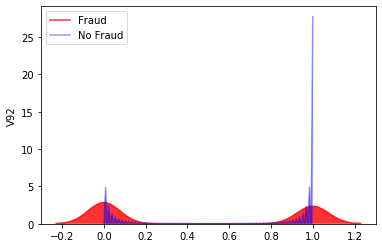

             mean     std  min  max
Fraud      0.5193  0.6093  0.0  6.0
Not Fraud  0.1379  0.3586  0.0  7.0


< V93 >


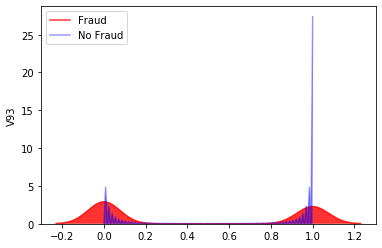

             mean     std  min  max
Fraud      0.5509  0.6713  0.0  6.0
Not Fraud  0.1414  0.3829  0.0  7.0


< V94 >


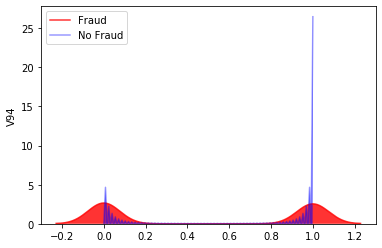

             mean     std  min  max
Fraud      0.4895  0.4999  0.0  1.0
Not Fraud  0.1251  0.3309  0.0  2.0


< V95 >


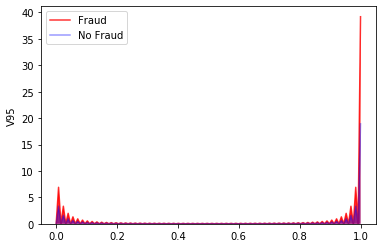

             mean      std  min    max
Fraud      0.5829   1.2396  0.0   13.0
Not Fraud  1.0545  21.4107  0.0  880.0


< V96 >


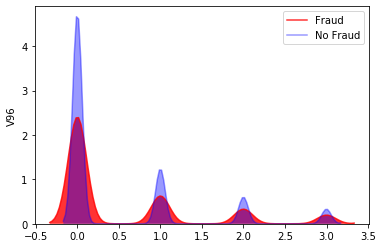

             mean      std  min     max
Fraud      1.8460   4.4499  0.0    55.0
Not Fraud  3.0472  40.9529  0.0  1410.0


< V97 >


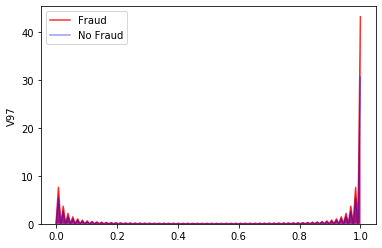

             mean      std  min    max
Fraud      1.0656   2.2460  0.0   26.0
Not Fraud  1.7426  28.1945  0.0  976.0


< V98 >


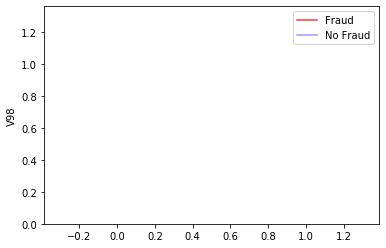

             mean     std  min   max
Fraud      0.1029  0.3713  0.0   6.0
Not Fraud  0.0605  0.2813  0.0  12.0


< V99 >


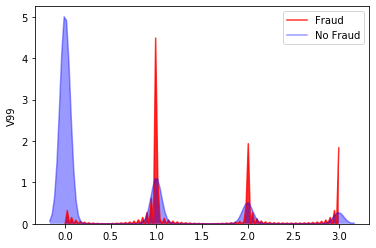

             mean    std  min   max
Fraud      0.7065  1.958  0.0  24.0
Not Fraud  0.9018  2.746  0.0  88.0


< V100 >


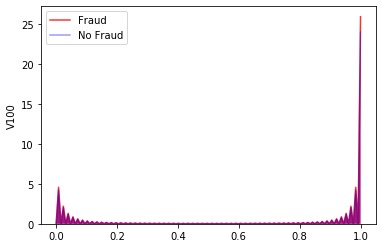

             mean     std  min   max
Fraud      0.3297  0.9259  0.0  17.0
Not Fraud  0.2715  0.9479  0.0  28.0


< V101 >


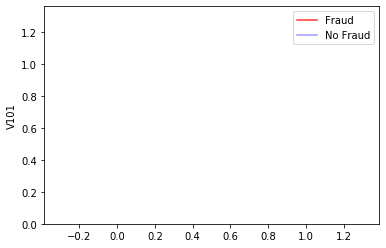

             mean      std  min    max
Fraud      0.3798   1.0148  0.0   13.0
Not Fraud  0.9077  20.9512  0.0  869.0


< V102 >


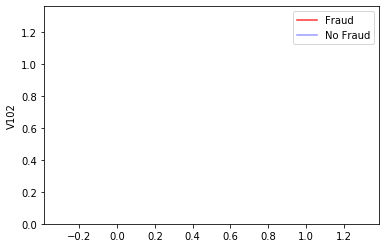

             mean      std  min     max
Fraud      0.9124   2.7606  0.0    41.0
Not Fraud  1.8604  36.5696  0.0  1285.0


< V103 >


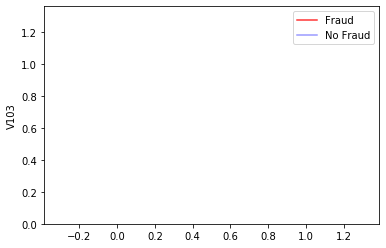

             mean      std  min    max
Fraud      0.5884   1.5707  0.0   21.0
Not Fraud  1.3043  26.1450  0.0  928.0


< V104 >


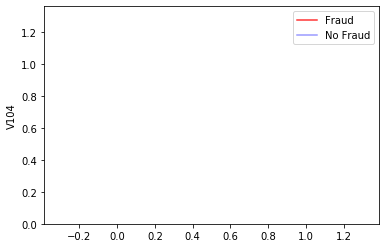

             mean     std  min   max
Fraud      0.0973  0.4825  0.0  12.0
Not Fraud  0.0850  0.6539  0.0  15.0


< V105 >


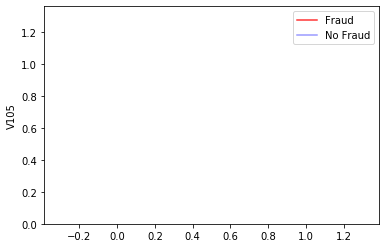

             mean     std  min   max
Fraud      0.2239  1.2296  0.0  27.0
Not Fraud  0.2832  3.4265  0.0  99.0


< V106 >


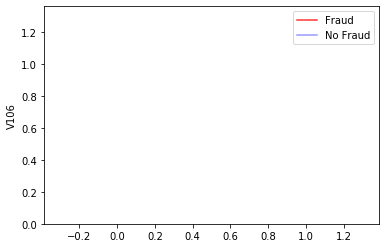

             mean     std  min   max
Fraud      0.1445  0.7814  0.0  23.0
Not Fraud  0.1653  1.8525  0.0  55.0


< V107 >


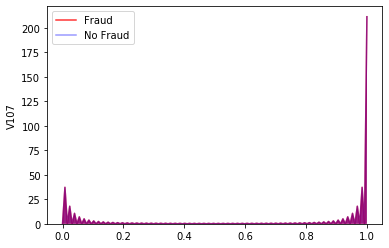

             mean     std  min  max
Fraud      0.9999  0.0121  0.0  1.0
Not Fraud  0.9996  0.0207  0.0  1.0


< V108 >


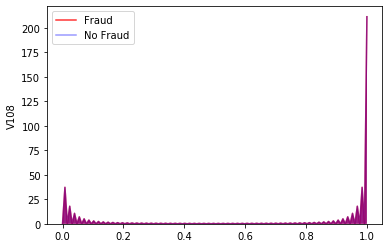

             mean     std  min  max
Fraud      1.0459  0.2706  0.0  7.0
Not Fraud  1.0031  0.0641  0.0  4.0


< V109 >


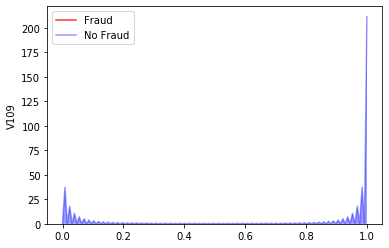

             mean     std  min  max
Fraud      1.0557  0.2879  1.0  7.0
Not Fraud  1.0133  0.1177  0.0  4.0


< V110 >


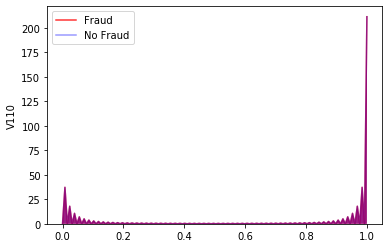

             mean     std  min  max
Fraud      1.0495  0.2762  0.0  7.0
Not Fraud  1.0062  0.0835  0.0  4.0


< V111 >


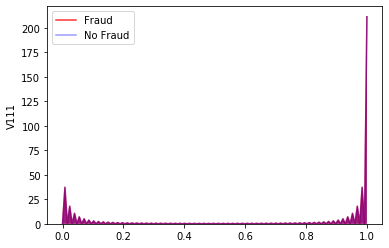

             mean     std  min  max
Fraud      1.0478  0.2964  0.0  9.0
Not Fraud  1.0009  0.0440  0.0  4.0


< V112 >


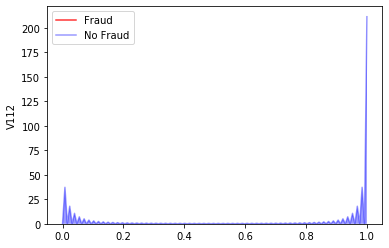

             mean     std  min  max
Fraud      1.0521  0.3026  1.0  9.0
Not Fraud  1.0037  0.0634  0.0  4.0


< V113 >


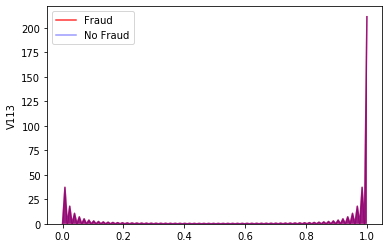

             mean     std  min  max
Fraud      1.0489  0.2979  0.0  9.0
Not Fraud  1.0017  0.0500  0.0  4.0


< V114 >


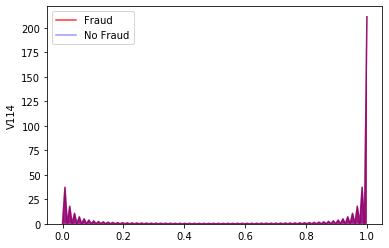

             mean     std  min  max
Fraud      1.0649  0.3274  0.0  6.0
Not Fraud  1.0073  0.0926  0.0  5.0


< V115 >


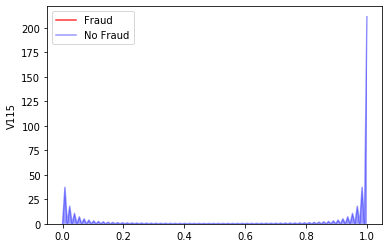

             mean     std  min  max
Fraud      1.0896  0.3660  1.0  6.0
Not Fraud  1.0304  0.1805  0.0  5.0


< V116 >


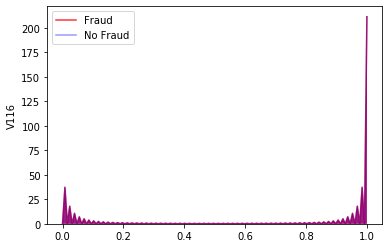

             mean     std  min  max
Fraud      1.0737  0.3402  0.0  6.0
Not Fraud  1.0136  0.1227  0.0  5.0


< V117 >


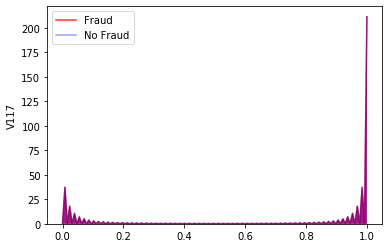

             mean     std  min  max
Fraud      1.0095  0.0987  0.0  2.0
Not Fraud  1.0001  0.0305  0.0  3.0


< V118 >


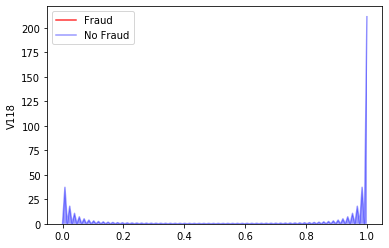

             mean     std  min  max
Fraud      1.0102  0.1006  1.0  2.0
Not Fraud  1.0012  0.0371  0.0  3.0


< V119 >


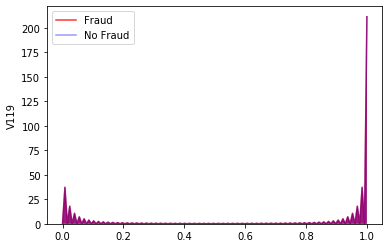

             mean     std  min  max
Fraud      1.0099  0.0996  0.0  2.0
Not Fraud  1.0004  0.0318  0.0  3.0


< V120 >


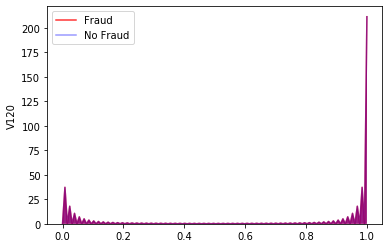

             mean     std  min  max
Fraud      1.0052  0.0776  0.0  3.0
Not Fraud  1.0007  0.0398  0.0  2.0


< V121 >


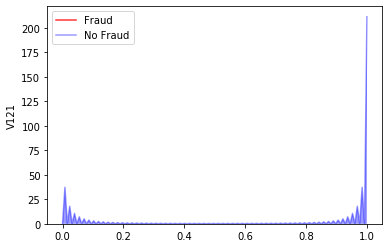

             mean     std  min  max
Fraud      1.0086  0.0955  1.0  3.0
Not Fraud  1.0041  0.0658  0.0  3.0


< V122 >


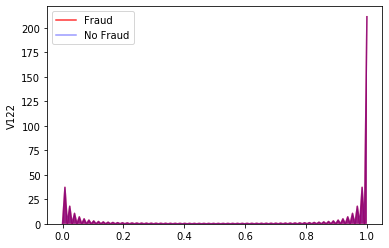

             mean     std  min  max
Fraud      1.0065  0.0847  0.0  3.0
Not Fraud  1.0016  0.0468  0.0  2.0


< V123 >


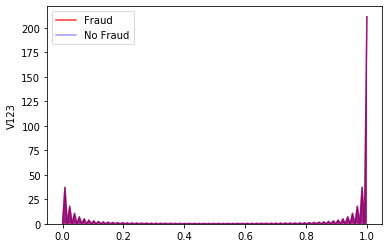

             mean     std  min   max
Fraud      1.1967  0.7685  0.0  13.0
Not Fraud  1.0251  0.1775  0.0   9.0


< V124 >


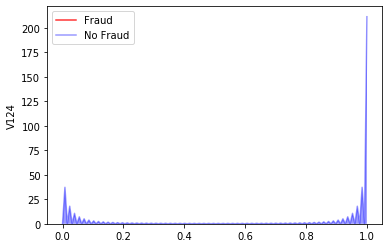

             mean     std  min   max
Fraud      1.2437  0.8053  1.0  13.0
Not Fraud  1.0875  0.3474  0.0  11.0


< V125 >


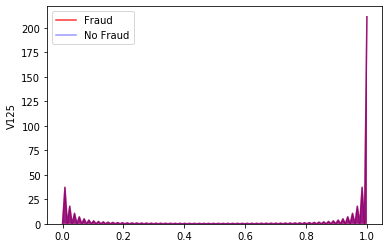

             mean    std  min   max
Fraud      1.2152  0.782  0.0  13.0
Not Fraud  1.0444  0.241  0.0   9.0


< V126 >


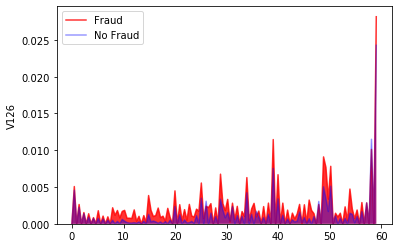

               mean        std  min       max
Fraud       86.2726   284.6311  0.0    6625.0
Not Fraud  131.5637  2388.4793  0.0  160000.0


< V127 >


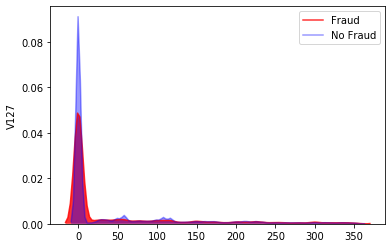

               mean        std  min       max
Fraud      278.0895   898.1108  0.0   19860.0
Not Fraud  338.7329  4311.4002  0.0  160000.0


< V128 >


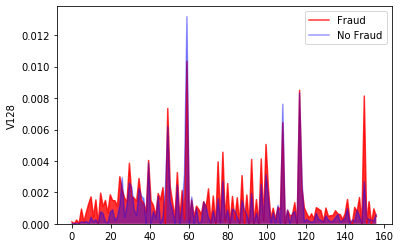

               mean        std  min       max
Fraud      173.5746   561.1115  0.0   10162.0
Not Fraud  205.2003  3062.4625  0.0  160000.0


< V129 >


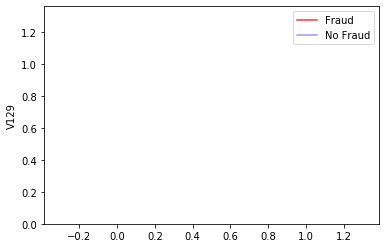

              mean       std  min      max
Fraud      16.3805   83.4789  0.0   1768.0
Not Fraud   8.4930  114.7730  0.0  55125.0


< V130 >


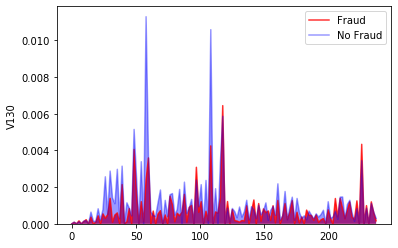

              mean       std  min      max
Fraud      97.2706  328.7630  0.0   4350.0
Not Fraud  91.9808  315.4854  0.0  55125.0


< V131 >


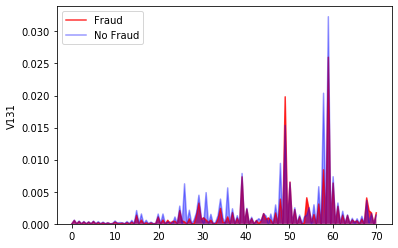

             mean       std  min      max
Fraud      52.274  188.1451  0.0   3981.0
Not Fraud  30.367  160.0455  0.0  55125.0


< V132 >


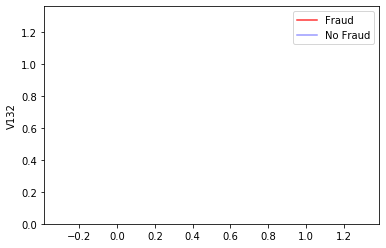

               mean        std  min      max
Fraud       52.7713   218.5839  0.0   6098.0
Not Fraud  105.3525  2306.4149  0.0  93736.0


< V133 >


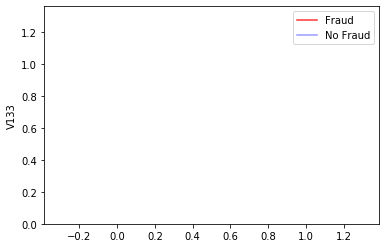

               mean        std  min       max
Fraud      141.7734   596.4352  0.0   15607.0
Not Fraud  207.1770  3862.8204  0.0  133915.0


< V134 >


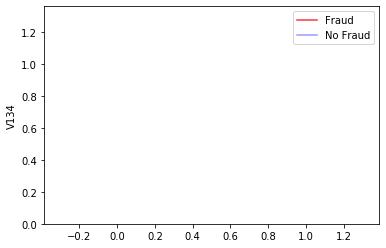

               mean        std  min      max
Fraud       94.8219   401.6884  0.0   8451.0
Not Fraud  147.8264  2821.7433  0.0  98476.0


< V135 >


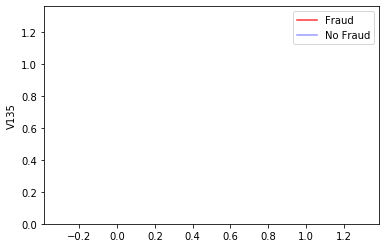

              mean       std  min         max
Fraud      16.8237  116.5864  0.0   4528.8999
Not Fraud  17.2656  298.3012  0.0  90750.0000


< V136 >


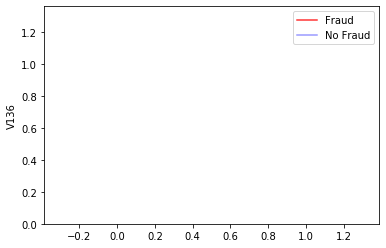

              mean       std  min         max
Fraud      38.7209  221.9121  0.0   4528.8999
Not Fraud  38.8248  457.9795  0.0  90750.0000


< V137 >


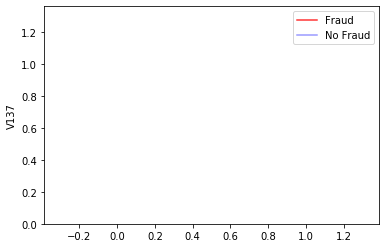

              mean       std  min         max
Fraud      26.1551  160.1453  0.0   4528.8999
Not Fraud  26.3727  353.2764  0.0  90750.0000


< V138 >


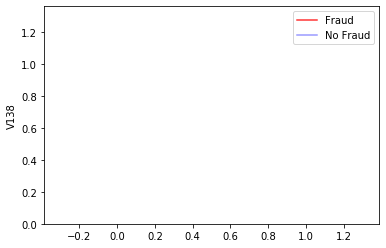

             mean     std  min   max
Fraud      0.1211  0.6594  0.0   8.0
Not Fraud  0.0325  0.4142  0.0  22.0


< V139 >


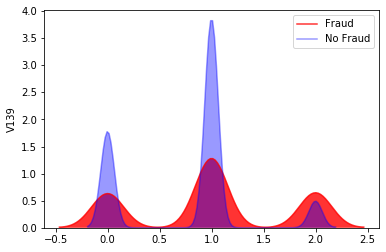

             mean     std  min   max
Fraud      1.9858  2.2314  0.0  24.0
Not Fraud  1.0314  1.2608  0.0  33.0


< V140 >


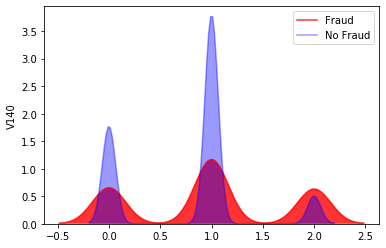

             mean     std  min   max
Fraud      2.4641  2.9475  0.0  27.0
Not Fraud  1.0629  1.3277  0.0  33.0


< V141 >


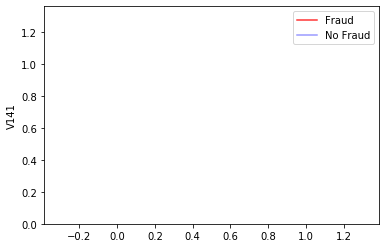

             mean     std  min  max
Fraud      0.1230  0.4034  0.0  3.0
Not Fraud  0.0337  0.2012  0.0  5.0


< V142 >


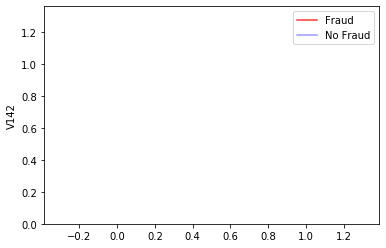

             mean     std  min  max
Fraud      0.1655  0.6551  0.0  9.0
Not Fraud  0.0431  0.2871  0.0  6.0


< V143 >


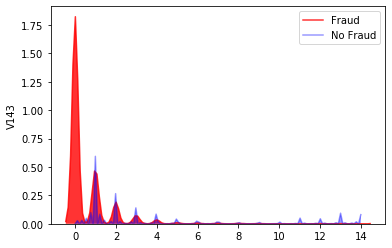

             mean      std  min    max
Fraud      0.7784   2.6405  0.0   47.0
Not Fraud  8.7522  56.5135  0.0  869.0


< V144 >


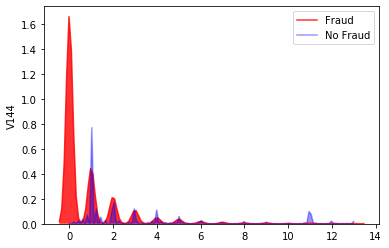

             mean      std  min   max
Fraud      1.1849   3.7016  0.0  51.0
Not Fraud  3.8262  10.6830  0.0  62.0


< V145 >


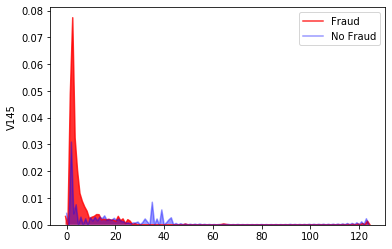

              mean      std  min    max
Fraud       3.6412  22.0132  0.0  292.0
Not Fraud  22.9743  65.5569  0.0  297.0


< V146 >


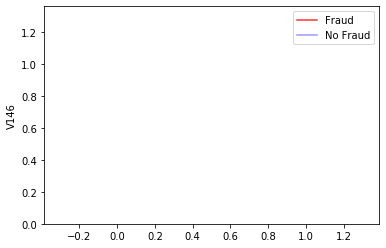

             mean     std  min   max
Fraud      0.7838  1.8484  0.0  24.0
Not Fraud  0.1270  0.5557  0.0  11.0


< V147 >


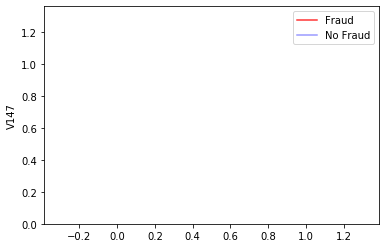

             mean     std  min   max
Fraud      1.0129  2.2732  0.0  26.0
Not Fraud  0.1292  0.5603  0.0  11.0


< V148 >


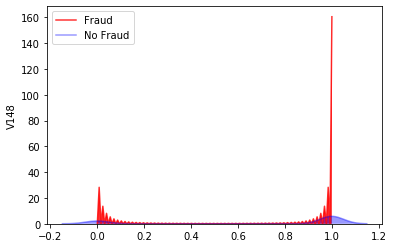

             mean     std  min   max
Fraud      1.3814  1.6474  0.0  20.0
Not Fraud  0.7363  0.4569  0.0   5.0


< V149 >


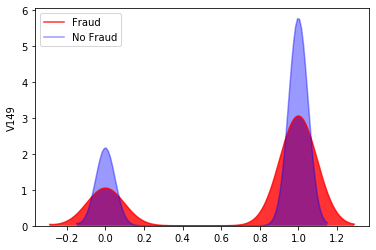

             mean     std  min   max
Fraud      1.5704  1.9135  0.0  20.0
Not Fraud  0.7382  0.4599  0.0   5.0


< V150 >


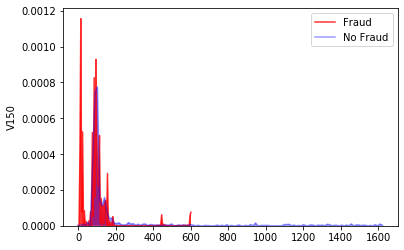

               mean       std  min     max
Fraud       31.8622  271.0471  1.0  3372.0
Not Fraud  289.0563  844.9355  1.0  3389.0


< V151 >


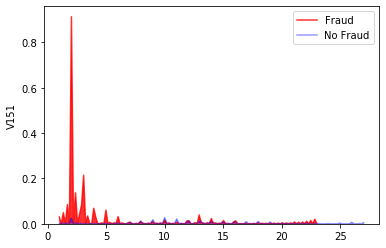

             mean      std  min   max
Fraud      2.1665   5.4745  1.0  55.0
Not Fraud  6.6604  15.5095  1.0  57.0


< V152 >


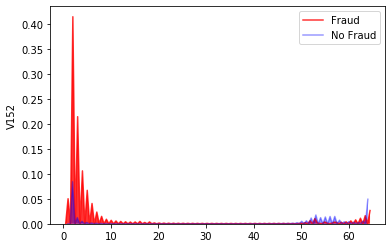

             mean      std  min   max
Fraud      3.5281  10.5108  1.0  69.0
Not Fraud  9.7080  21.8954  1.0  69.0


< V153 >


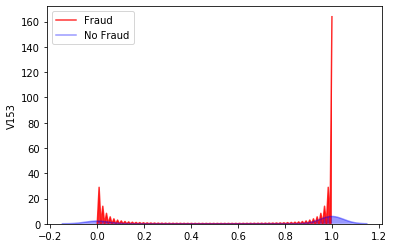

             mean     std  min   max
Fraud      1.2049  1.3507  0.0  18.0
Not Fraud  0.7321  0.4494  0.0   4.0


< V154 >


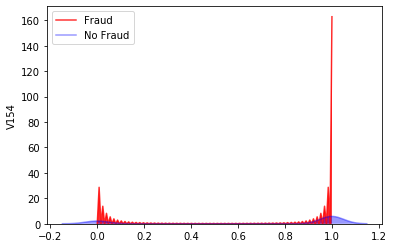

             mean     std  min   max
Fraud      1.2816  1.4415  0.0  18.0
Not Fraud  0.7330  0.4503  0.0   4.0


< V155 >


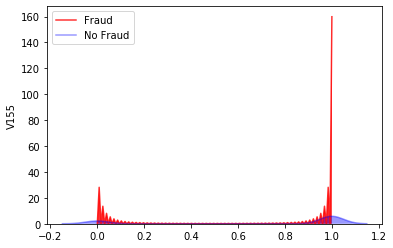

             mean     std  min   max
Fraud      1.4211  1.7868  0.0  24.0
Not Fraud  0.7369  0.4588  0.0   5.0


< V156 >


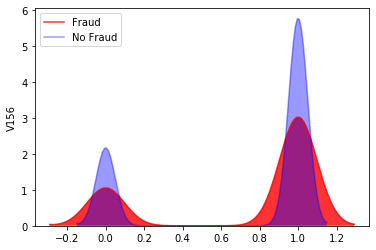

             mean     std  min   max
Fraud      1.6047  2.0277  0.0  24.0
Not Fraud  0.7389  0.4620  0.0   5.0


< V157 >


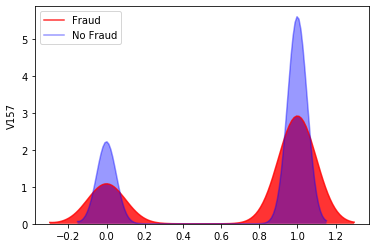

             mean     std  min   max
Fraud      1.5595  1.8603  0.0  24.0
Not Fraud  0.7830  0.5465  0.0   7.0


< V158 >


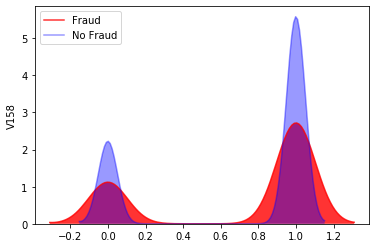

             mean     std  min   max
Fraud      1.7792  2.1196  0.0  24.0
Not Fraud  0.7894  0.5580  0.0   7.0


< V159 >


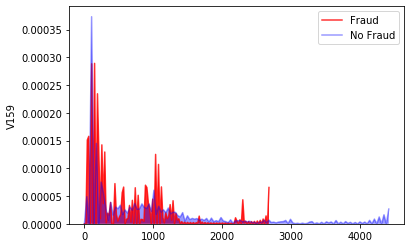

                mean        std  min         max
Fraud       294.7282  2687.5701  0.0  43551.9297
Not Fraud  2832.3536  8511.4739  0.0  55125.0000


< V160 >


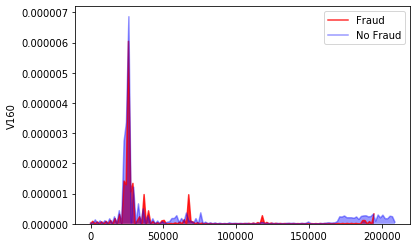

                 mean          std  min          max
Fraud       6437.6647   52765.4897  0.0  639717.4375
Not Fraud  49365.6671  144620.0342  0.0  641511.4375


< V161 >


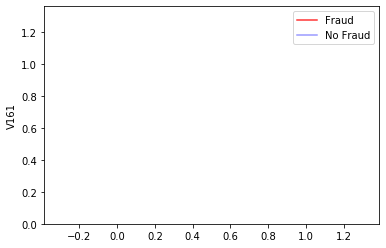

              mean      std  min     max
Fraud      15.7082  61.0427  0.0   500.0
Not Fraud   4.3375  58.7808  0.0  3300.0


< V162 >


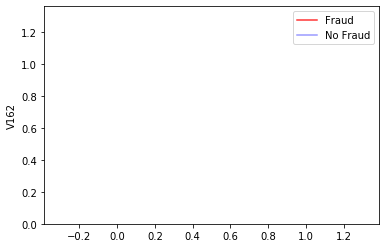

              mean      std  min     max
Fraud      23.6767  95.1724  0.0  1170.0
Not Fraud   5.7983  67.6372  0.0  3300.0


< V163 >


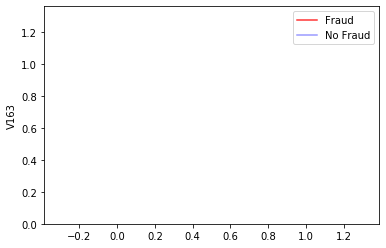

              mean      std  min     max
Fraud      19.1000  75.3589  0.0   770.0
Not Fraud   4.8722  62.3748  0.0  3300.0


< V164 >


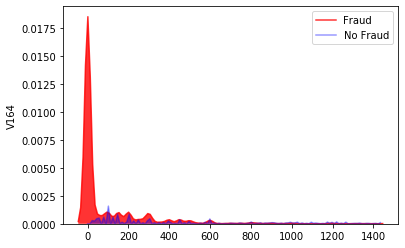

               mean        std  min      max
Fraud      109.0537   306.2456  0.0   5450.0
Not Fraud  913.7384  6185.9083  0.0  93736.0


< V165 >


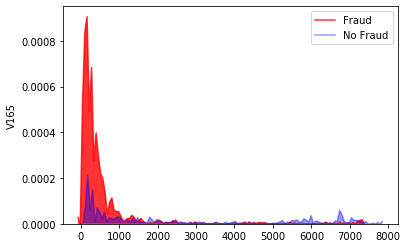

                mean        std  min         max
Fraud       282.5647  1410.6636  0.0  17468.9492
Not Fraud  2331.1801  8396.1533  0.0  98476.0000


< V166 >


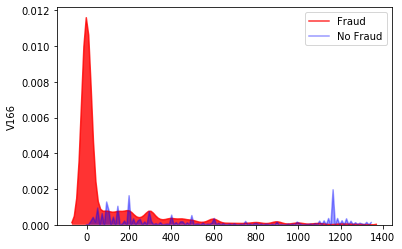

               mean        std  min       max
Fraud      189.8282   536.8085  0.0    9000.0
Not Fraud  367.3795  1267.3062  0.0  104060.0


< V167 >


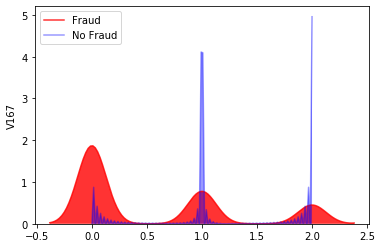

             mean      std  min    max
Fraud      2.0782   4.1829  0.0   47.0
Not Fraud  4.0884  43.9544  0.0  872.0


< V168 >


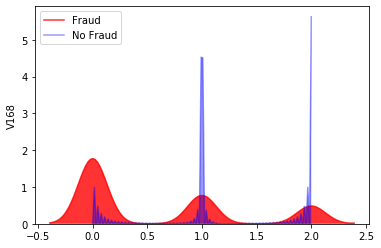

             mean      std  min    max
Fraud      2.9050   6.6892  0.0  164.0
Not Fraud  6.1131  56.2626  0.0  964.0


< V169 >


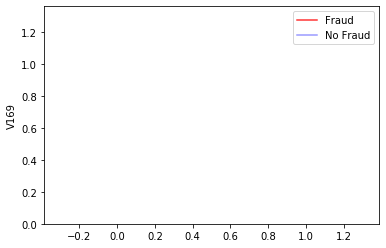

             mean     std  min   max
Fraud      0.3782  1.7527  0.0  18.0
Not Fraud  0.1500  0.7881  0.0  19.0


< V170 >


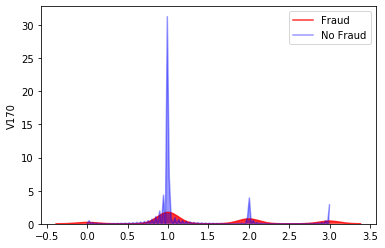

             mean     std  min   max
Fraud      2.9285  4.3707  0.0  48.0
Not Fraud  1.3085  1.2166  0.0  30.0


< V171 >


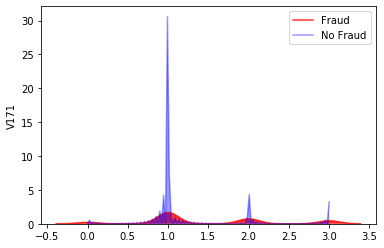

             mean     std  min   max
Fraud      3.4960  5.2676  0.0  61.0
Not Fraud  1.5357  1.9496  0.0  30.0


< V172 >


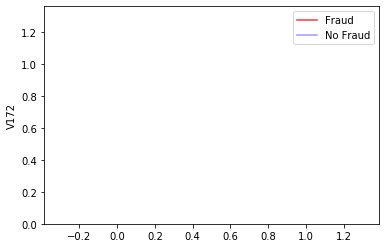

             mean     std  min   max
Fraud      0.0902  0.5479  0.0  22.0
Not Fraud  0.1356  0.9502  0.0  31.0


< V173 >


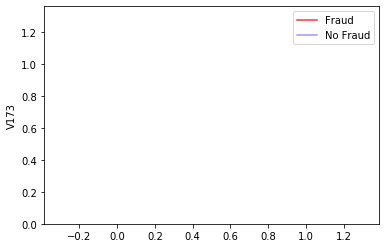

             mean     std  min  max
Fraud      0.0360  0.1980  0.0  3.0
Not Fraud  0.0569  0.2693  0.0  7.0


< V174 >


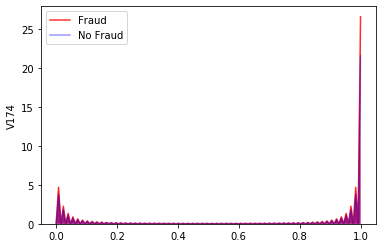

             mean     std  min  max
Fraud      0.1488  0.3985  0.0  4.0
Not Fraud  0.1260  0.3781  0.0  8.0


< V175 >


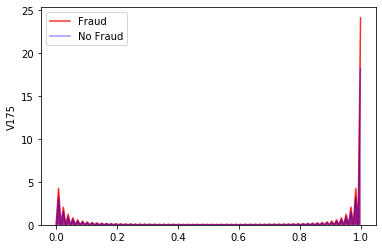

             mean     std  min   max
Fraud      0.2061  0.7172  0.0  14.0
Not Fraud  0.2132  0.8681  0.0   9.0


< V176 >


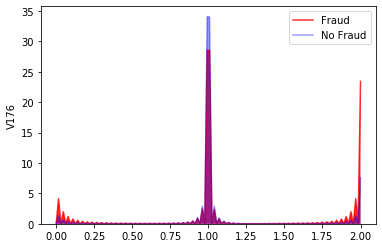

             mean     std  min   max
Fraud      2.4031  3.4689  0.0  48.0
Not Fraud  1.2889  1.5821  0.0  48.0


< V177 >


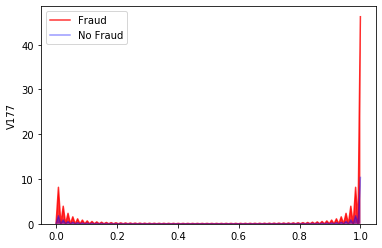

             mean      std  min    max
Fraud      1.5954   3.8785  0.0   47.0
Not Fraud  3.6953  43.0282  0.0  861.0


< V178 >


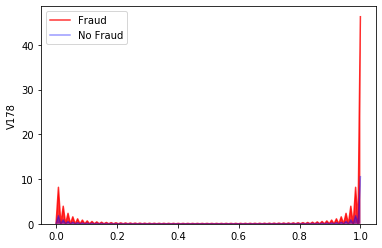

             mean      std  min     max
Fraud      2.7281   7.2354  0.0   102.0
Not Fraud  6.9859  72.3259  0.0  1235.0


< V179 >


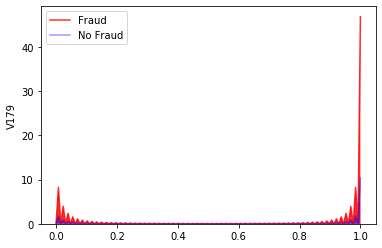

             mean      std  min    max
Fraud      2.1284   5.1285  0.0   60.0
Not Fraud  5.1043  52.5838  0.0  920.0


< V180 >


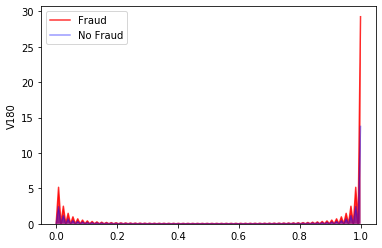

             mean     std  min   max
Fraud      0.7294  3.7979  0.0  68.0
Not Fraud  0.9409  6.2716  0.0  83.0


< V181 >


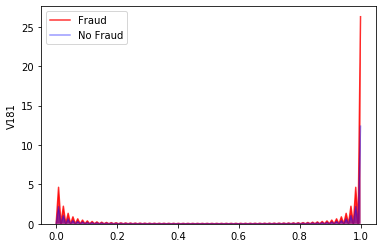

             mean     std  min   max
Fraud      0.3741  1.2418  0.0  24.0
Not Fraud  0.2430  1.2490  0.0  15.0


< V182 >


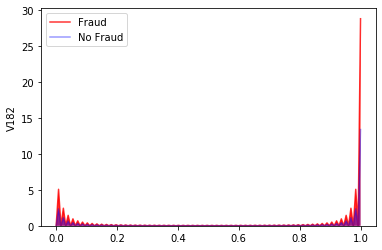

             mean     std  min   max
Fraud      0.6564  2.9619  0.0  49.0
Not Fraud  0.8734  5.9735  0.0  83.0


< V183 >


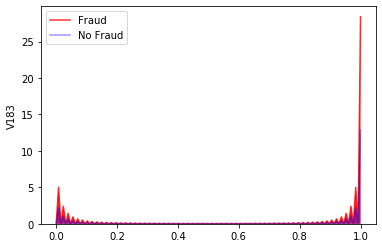

             mean     std  min   max
Fraud      0.4781  1.6040  0.0  31.0
Not Fraud  0.4853  3.0347  0.0  41.0


< V184 >


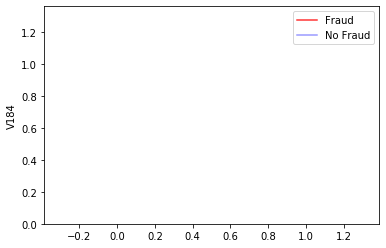

             mean     std  min   max
Fraud      0.3575  1.0080  0.0  16.0
Not Fraud  0.1130  0.4785  0.0  11.0


< V185 >


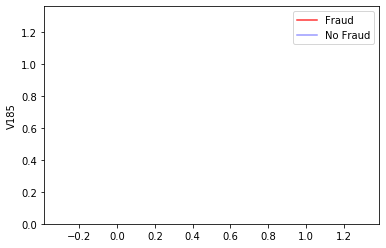

             mean     std  min   max
Fraud      0.4346  1.4734  0.0  31.0
Not Fraud  0.1515  0.5820  0.0  11.0


< V186 >


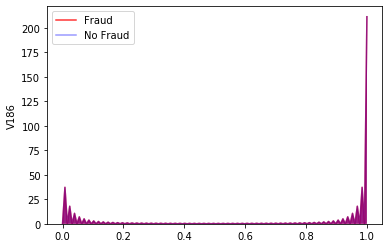

             mean     std  min   max
Fraud      1.7706  1.8793  0.0  29.0
Not Fraud  1.0954  1.1342  0.0  38.0


< V187 >


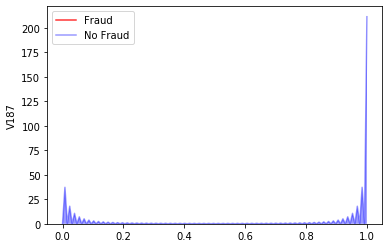

             mean     std  min    max
Fraud      2.6611  9.5369  1.0  218.0
Not Fraud  1.7736  9.9105  0.0  217.0


< V188 >


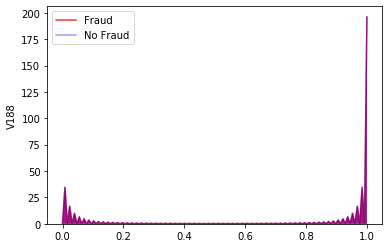

             mean     std  min   max
Fraud      1.7097  1.9768  0.0  30.0
Not Fraud  0.9550  0.3289  0.0   7.0


< V189 >


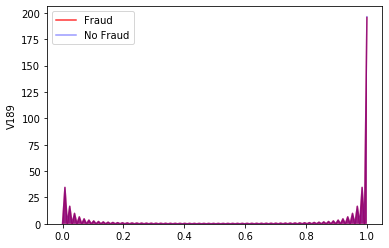

             mean     std  min   max
Fraud      1.8714  2.2376  0.0  30.0
Not Fraud  0.9667  0.4322  0.0  13.0


< V190 >


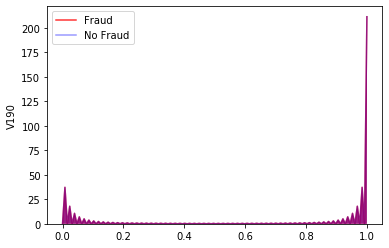

             mean     std  min   max
Fraud      2.2496  3.0703  0.0  42.0
Not Fraud  1.1241  1.2125  0.0  40.0


< V191 >


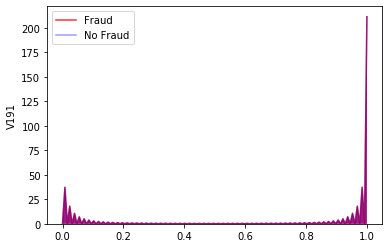

             mean     std  min   max
Fraud      1.1866  0.7683  0.0  16.0
Not Fraud  1.0480  0.6680  0.0  21.0


< V192 >


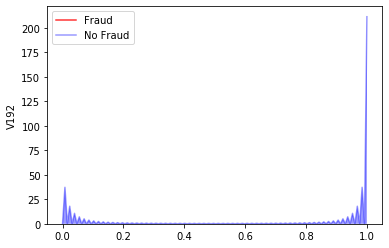

             mean     std  min   max
Fraud      1.4024  2.5119  1.0  43.0
Not Fraud  1.2232  2.6459  0.0  44.0


< V193 >


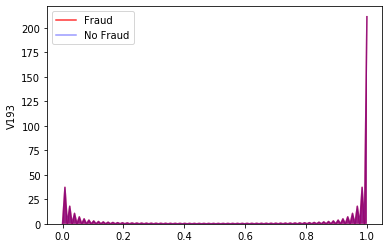

             mean     std  min   max
Fraud      1.2790  1.3931  0.0  30.0
Not Fraud  1.1388  1.7392  0.0  37.0


< V194 >


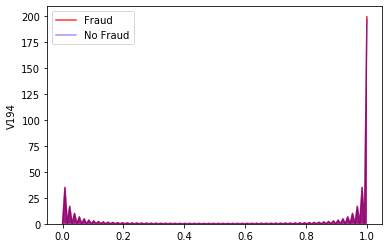

             mean     std  min  max
Fraud      1.0985  0.5754  0.0  7.0
Not Fraud  0.9326  0.2642  0.0  3.0


< V195 >


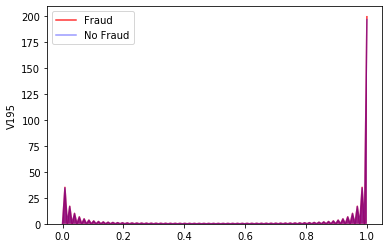

            mean     std  min   max
Fraud      1.143  0.8100  0.0  16.0
Not Fraud  0.938  0.3068  0.0   8.0


< V196 >


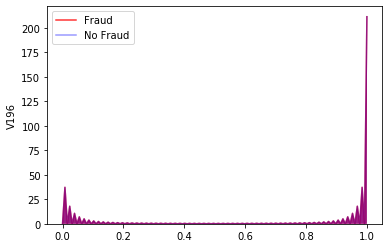

             mean     std  min   max
Fraud      1.2290  1.0967  0.0  28.0
Not Fraud  1.0722  1.1057  0.0  38.0


< V197 >


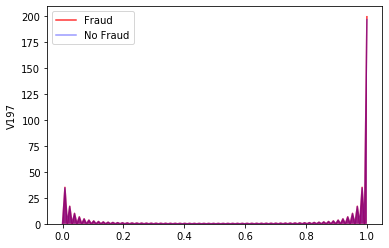

             mean     std  min   max
Fraud      1.1263  0.7506  0.0  14.0
Not Fraud  0.9342  0.2681  0.0   4.0


< V198 >


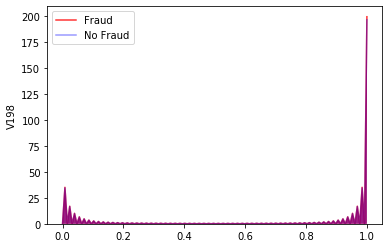

             mean     std  min   max
Fraud      1.1972  1.1356  0.0  21.0
Not Fraud  0.9417  0.3847  0.0  14.0


< V199 >


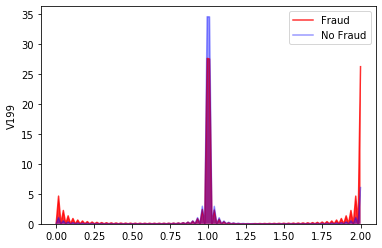

             mean     std  min   max
Fraud      2.5890  3.7235  0.0  45.0
Not Fraud  1.1576  1.2973  0.0  43.0


< V200 >


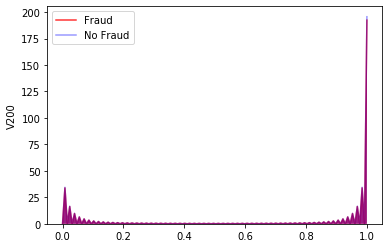

             mean     std  min   max
Fraud      2.4831  3.9444  0.0  45.0
Not Fraud  1.0028  0.4429  0.0  12.0


< V201 >


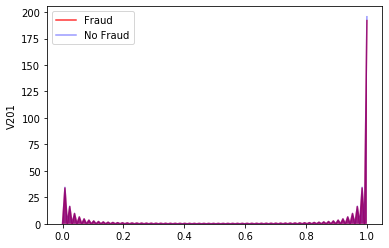

             mean     std  min   max
Fraud      2.7460  4.3526  0.0  55.0
Not Fraud  1.0227  0.5671  0.0  15.0


< V202 >


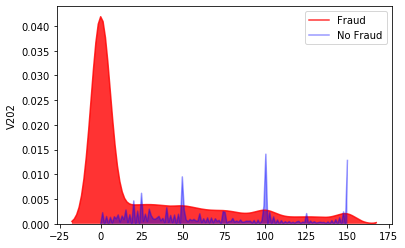

               mean        std  min       max
Fraud      155.9582   403.6219  0.0   10900.0
Not Fraud  468.8868  4878.5069  0.0  104060.0


< V203 >


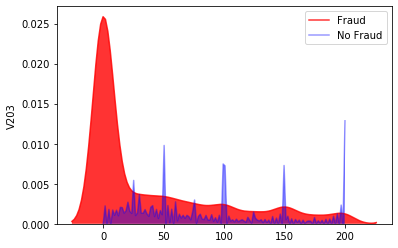

                mean        std  min       max
Fraud       458.5776  3581.8197  0.0   81450.0
Not Fraud  1131.5301  9428.2924  0.0  139777.0


< V204 >


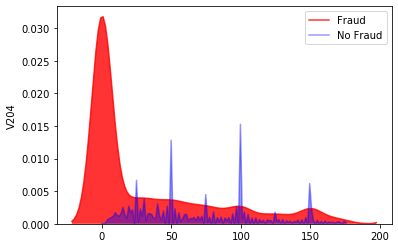

               mean        std  min       max
Fraud      258.6076  1227.4762  0.0   37850.0
Not Fraud  723.7286  6291.6489  0.0  104060.0


< V205 >


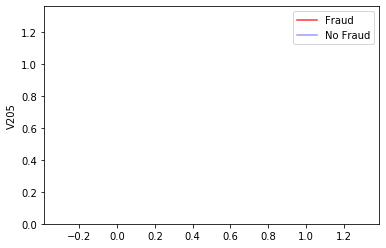

              mean       std  min      max
Fraud       9.0579  116.0478  0.0   5050.0
Not Fraud  18.8332  275.6483  0.0  55125.0


< V206 >


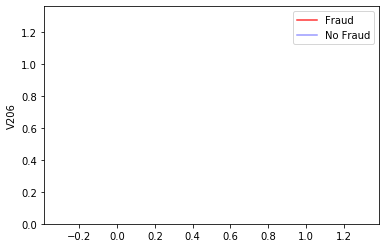

             mean       std  min      max
Fraud      2.4675   25.2556  0.0   1350.0
Not Fraud  6.5089  199.3829  0.0  55125.0


< V207 >


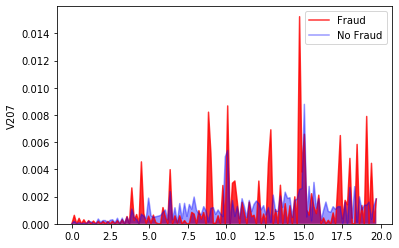

              mean       std  min      max
Fraud      33.0522  476.2163  0.0  20075.0
Not Fraud  75.6520  954.3724  0.0  55125.0


< V208 >


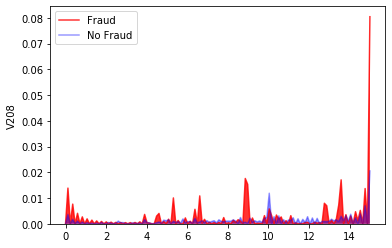

              mean      std  min     max
Fraud      10.7308  46.1779  0.0   835.0
Not Fraud   8.7298  60.0225  0.0  3300.0


< V209 >


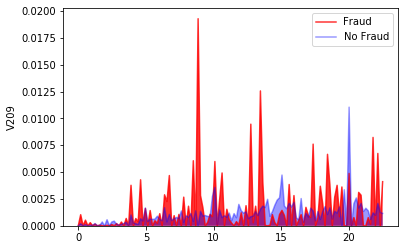

              mean       std  min     max
Fraud      18.8976  127.4694  0.0  4725.0
Not Fraud  36.3865  258.6276  0.0  8050.0


< V210 >


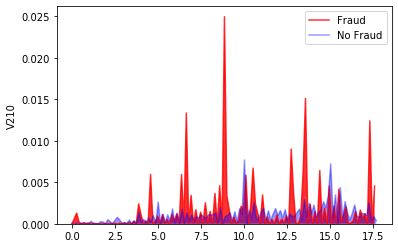

              mean      std  min     max
Fraud      14.1993  73.4669  0.0  1825.0
Not Fraud  14.4084  87.5557  0.0  3300.0


< V211 >


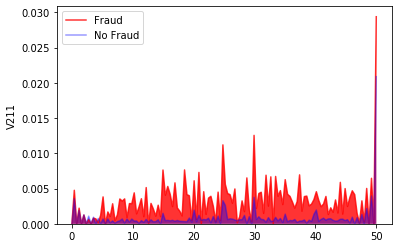

               mean        std  min      max
Fraud       97.2366   261.3976  0.0   5450.0
Not Fraud  409.8519  4731.3373  0.0  92888.0


< V212 >


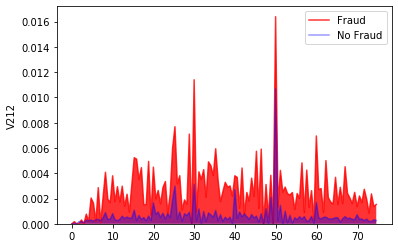

               mean        std  min       max
Fraud      225.1793  1385.1254  0.0   34625.0
Not Fraud  812.4142  7798.9557  0.0  129006.0


< V213 >


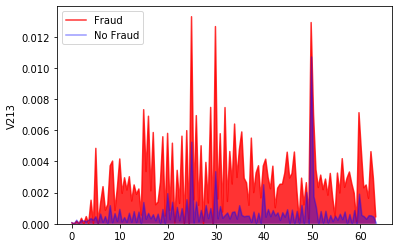

               mean       std  min      max
Fraud      151.5739   647.085  0.0  16950.0
Not Fraud  569.3299  5697.326  0.0  97628.0


< V214 >


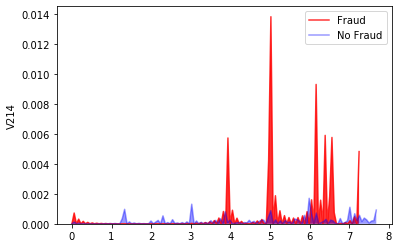

              mean       std  min       max
Fraud      47.9048  198.6768  0.0    4500.0
Not Fraud  37.6248  593.0168  0.0  104060.0


< V215 >


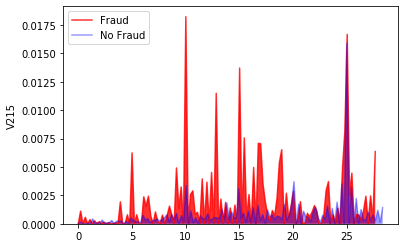

               mean        std  min       max
Fraud      116.1598   785.3880  0.0   13725.0
Not Fraud  134.6717  1059.4814  0.0  104060.0


< V216 >


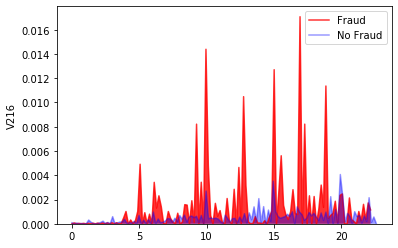

              mean       std  min       max
Fraud      69.6865  306.1439  0.0    6100.0
Not Fraud  71.2291  703.1679  0.0  104060.0


< V217 >


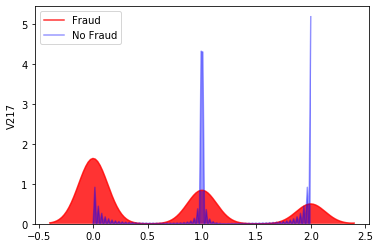

             mean     std  min    max
Fraud      2.5560  4.5038  0.0   53.0
Not Fraud  0.9274  9.8464  0.0  303.0


< V218 >


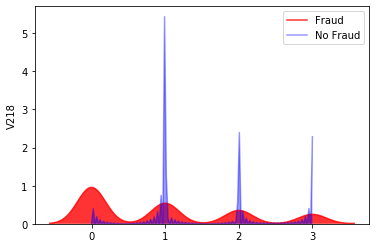

             mean      std  min    max
Fraud      3.9999   6.8824  0.0  154.0
Not Fraud  1.5330  14.3421  0.0  400.0


< V219 >


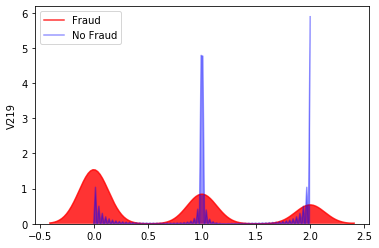

             mean      std  min    max
Fraud      3.2718   5.3815  0.0   53.0
Not Fraud  1.2057  12.4325  0.0  378.0


< V220 >


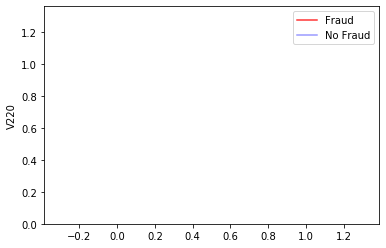

             mean     std  min   max
Fraud      0.4342  2.0171  0.0  25.0
Not Fraud  0.1472  0.8606  0.0  24.0


< V221 >


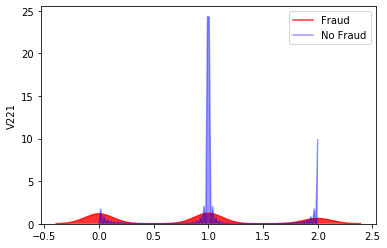

             mean     std  min    max
Fraud      2.5214  4.3691  0.0   84.0
Not Fraud  1.1700  2.5148  0.0  384.0


< V222 >


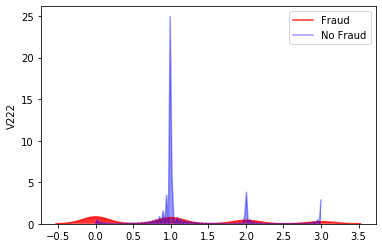

             mean     std  min    max
Fraud      3.0298  5.0783  0.0   86.0
Not Fraud  1.2183  2.6036  0.0  384.0


< V223 >


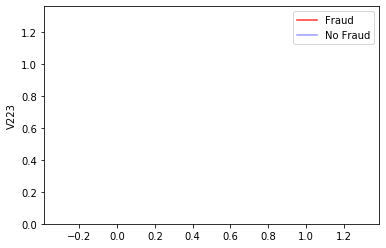

             mean     std  min   max
Fraud      0.0947  0.3482  0.0   6.0
Not Fraud  0.0930  0.4065  0.0  16.0


< V224 >


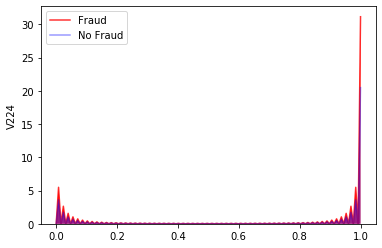

             mean     std  min    max
Fraud      0.4084  2.5332  0.0  142.0
Not Fraud  0.3936  3.5096  0.0  144.0


< V225 >


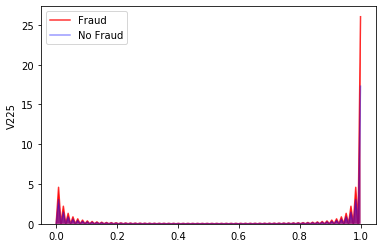

             mean     std  min   max
Fraud      0.2269  0.9006  0.0  32.0
Not Fraud  0.1888  1.3186  0.0  51.0


< V226 >


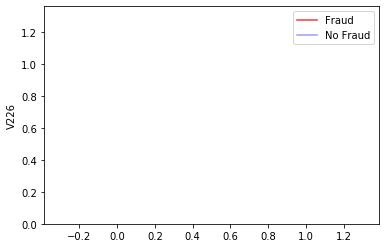

             mean     std  min    max
Fraud      0.2691  1.2124  0.0   23.0
Not Fraud  0.2458  2.8491  0.0  242.0


< V227 >


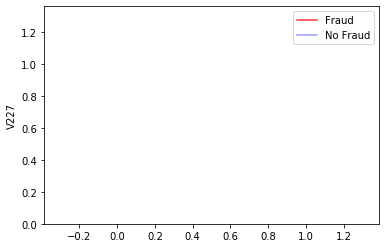

             mean     std  min    max
Fraud      0.2680  1.7723  0.0   79.0
Not Fraud  0.1379  2.0707  0.0  360.0


< V228 >


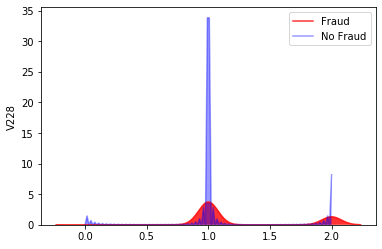

             mean     std  min   max
Fraud      2.6537  3.5945  0.0  54.0
Not Fraud  1.2416  0.9512  0.0  29.0


< V229 >


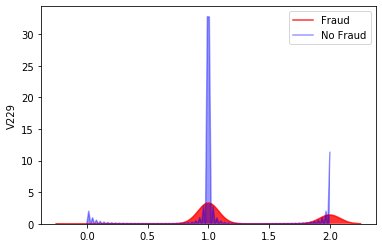

             mean     std  min    max
Fraud      3.6730  5.4266  0.0  128.0
Not Fraud  1.4663  4.1630  0.0  176.0


< V230 >


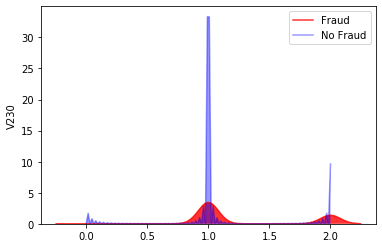

             mean     std  min   max
Fraud      3.1551  4.2576  0.0  54.0
Not Fraud  1.3223  1.7576  0.0  65.0


< V231 >


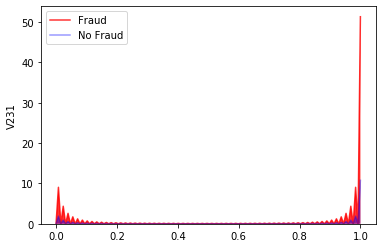

             mean     std  min    max
Fraud      2.0244  4.2680  0.0   51.0
Not Fraud  0.6588  9.1539  0.0  293.0


< V232 >


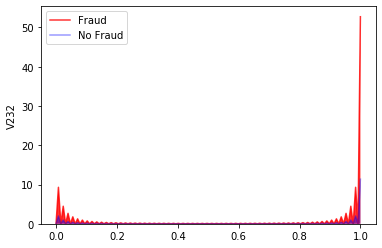

             mean      std  min    max
Fraud      2.9673   5.9751  0.0   56.0
Not Fraud  0.8393  10.7383  0.0  337.0


< V233 >


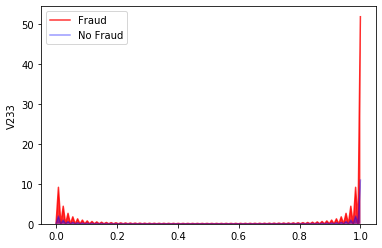

             mean      std  min    max
Fraud      2.5199   5.0476  0.0   51.0
Not Fraud  0.7718  10.4573  0.0  332.0


< V234 >


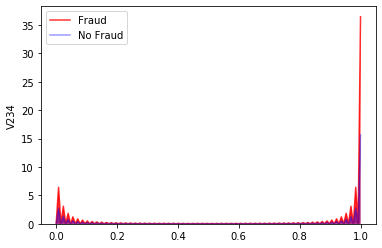

             mean      std  min    max
Fraud      1.3375   7.7356  0.0  120.0
Not Fraud  2.1564  11.5722  0.0  121.0


< V235 >


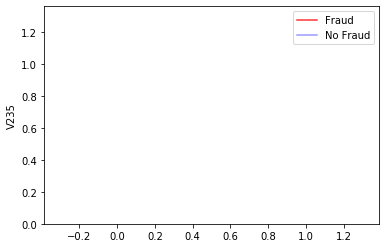

             mean     std  min   max
Fraud      0.4203  1.2372  0.0  23.0
Not Fraud  0.1641  0.8654  0.0  15.0


< V236 >


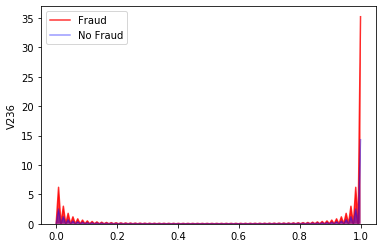

             mean     std  min   max
Fraud      0.6032  1.5023  0.0  23.0
Not Fraud  0.2826  2.1968  0.0  45.0


< V237 >


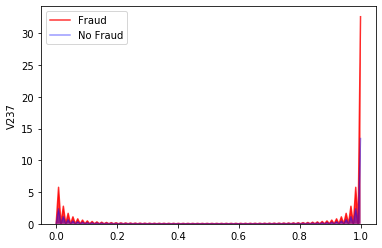

             mean     std  min   max
Fraud      0.5054  1.3606  0.0  23.0
Not Fraud  0.2321  1.7418  0.0  39.0


< V238 >


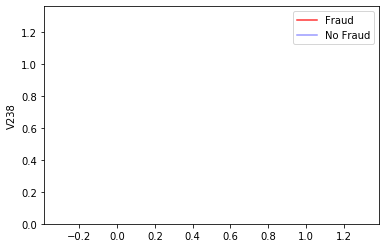

             mean     std  min   max
Fraud      0.3607  1.0866  0.0  23.0
Not Fraud  0.1084  0.5037  0.0  23.0


< V239 >


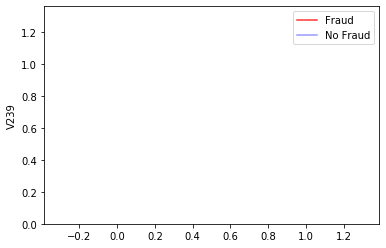

             mean     std  min   max
Fraud      0.4373  1.2938  0.0  23.0
Not Fraud  0.1117  0.5124  0.0  23.0


< V240 >


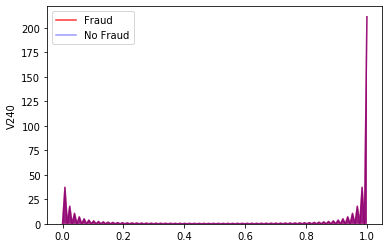

             mean     std  min  max
Fraud      1.0015  0.0408  0.0  2.0
Not Fraud  1.0010  0.0502  0.0  7.0


< V241 >


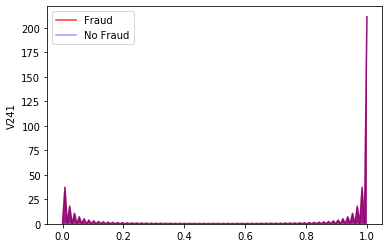

             mean     std  min  max
Fraud      1.0004  0.0243  0.0  2.0
Not Fraud  1.0002  0.0225  0.0  5.0


< V242 >


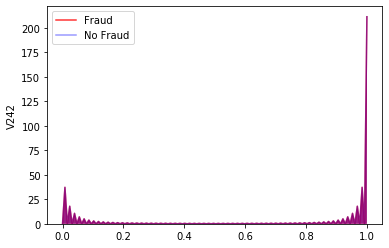

             mean     std  min   max
Fraud      1.9310  1.8546  0.0  20.0
Not Fraud  1.0442  0.3460  0.0  18.0


< V243 >


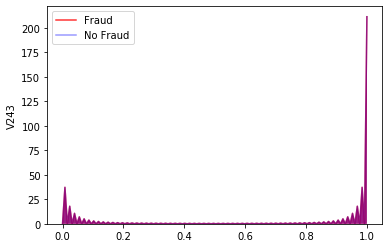

             mean     std  min   max
Fraud      2.1886  2.2921  0.0  34.0
Not Fraud  1.0928  1.2585  0.0  57.0


< V244 >


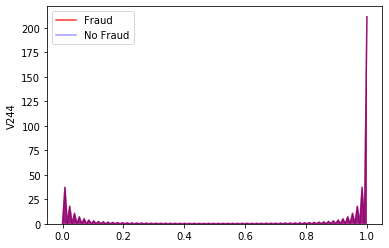

             mean     std  min   max
Fraud      1.9925  1.9873  0.0  22.0
Not Fraud  1.0445  0.3532  0.0  18.0


< V245 >


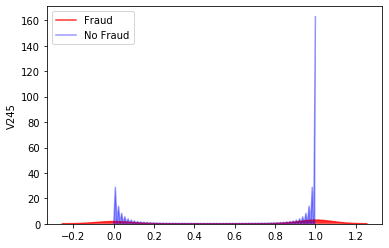

             mean     std  min    max
Fraud      1.4497  2.3691  0.0   67.0
Not Fraud  0.8284  1.7587  0.0  262.0


< V246 >


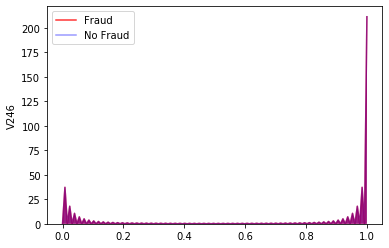

             mean     std  min   max
Fraud      2.4947  3.1381  0.0  45.0
Not Fraud  1.0726  0.4259  0.0  18.0


< V247 >


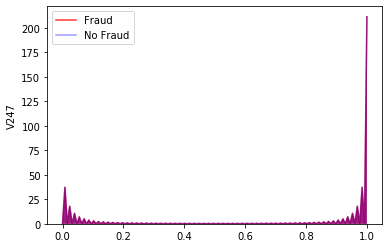

             mean     std  min   max
Fraud      1.1992  0.7407  0.0  18.0
Not Fraud  1.0106  0.1917  0.0  12.0


< V248 >


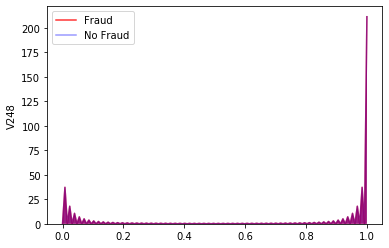

             mean     std  min   max
Fraud      1.3091  0.9173  0.0  18.0
Not Fraud  1.0492  0.8829  0.0  36.0


< V249 >


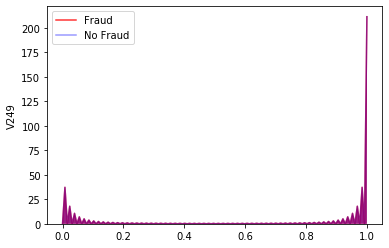

             mean     std  min   max
Fraud      1.2497  0.8078  0.0  18.0
Not Fraud  1.0253  0.4941  0.0  22.0


< V250 >


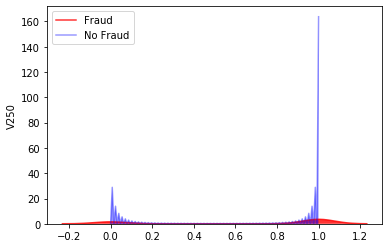

             mean     std  min   max
Fraud      0.8647  0.8592  0.0  18.0
Not Fraud  0.7822  0.4426  0.0  17.0


< V251 >


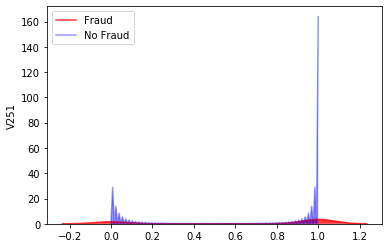

             mean     std  min   max
Fraud      0.9037  0.9188  0.0  18.0
Not Fraud  0.7850  0.4475  0.0  17.0


< V252 >


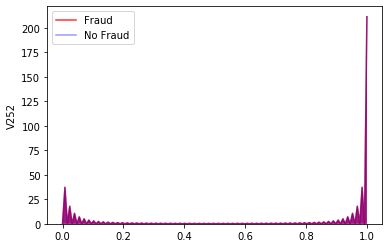

             mean     std  min   max
Fraud      1.2372  1.0201  0.0  24.0
Not Fraud  1.0147  0.2693  0.0  18.0


< V253 >


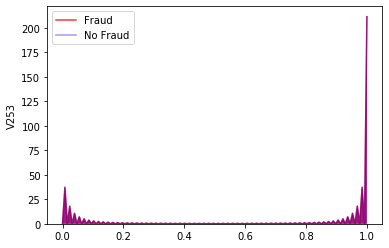

             mean     std  min    max
Fraud      1.4060  1.7363  0.0   62.0
Not Fraud  1.1415  3.7277  0.0  163.0


< V254 >


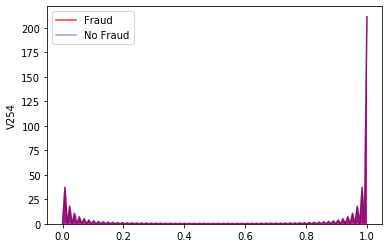

             mean     std  min   max
Fraud      1.3078  1.2189  0.0  27.0
Not Fraud  1.0554  1.3668  0.0  60.0


< V255 >


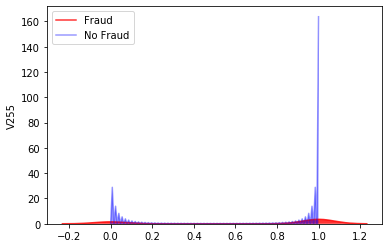

             mean     std  min   max
Fraud      0.9299  1.3881  0.0  41.0
Not Fraud  0.7963  0.8903  0.0  87.0


< V256 >


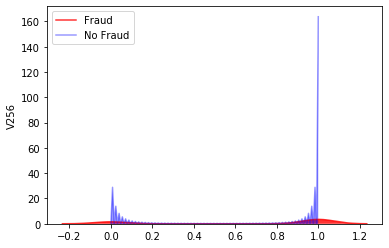

             mean     std  min   max
Fraud      0.9923  1.5467  0.0  41.0
Not Fraud  0.8000  0.9032  0.0  87.0


< V257 >


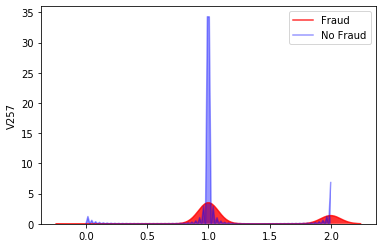

             mean     std  min   max
Fraud      2.9613  3.9235  0.0  48.0
Not Fraud  1.1060  0.5093  0.0  22.0


< V258 >


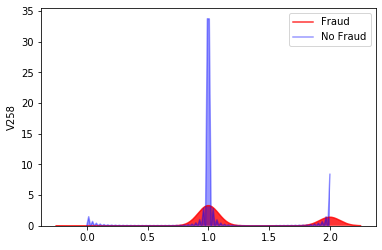

             mean     std  min   max
Fraud      3.4009  4.4932  0.0  48.0
Not Fraud  1.1691  1.5191  0.0  66.0


< V259 >


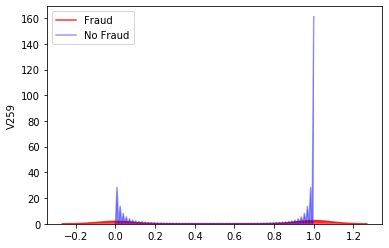

             mean     std  min    max
Fraud      2.0723  3.7412  0.0   71.0
Not Fraud  0.8748  1.8849  0.0  285.0


< V260 >


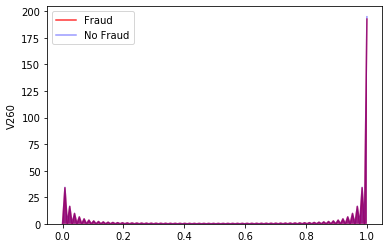

             mean     std  min  max
Fraud      1.1274  0.6836  0.0  8.0
Not Fraud  0.9506  0.3383  0.0  6.0


< V261 >


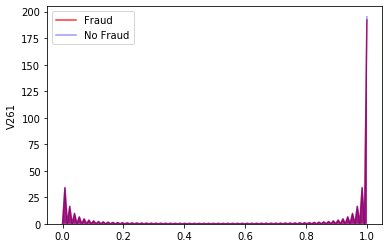

             mean     std  min   max
Fraud      1.5834  1.9469  0.0  24.0
Not Fraud  1.0668  1.2479  0.0  49.0


< V262 >


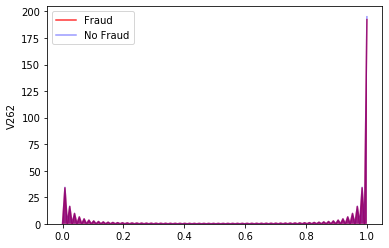

             mean     std  min   max
Fraud      1.3362  1.1857  0.0  16.0
Not Fraud  0.9859  0.5437  0.0  20.0


< V263 >


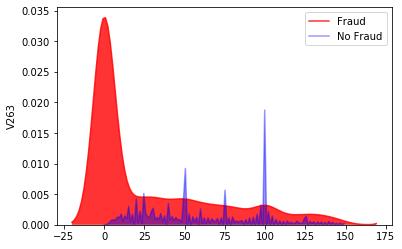

               mean        std  min       max
Fraud      182.9032   381.4781  0.0    5450.0
Not Fraud  111.8375  1343.8874  0.0  153600.0


< V264 >


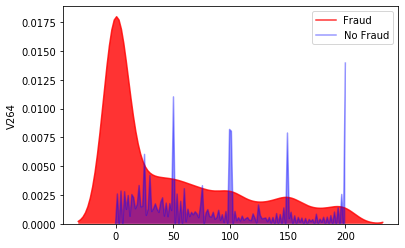

               mean        std  min       max
Fraud      275.0943   553.8382  0.0   10035.0
Not Fraud  195.4327  2374.1225  0.0  153600.0


< V265 >


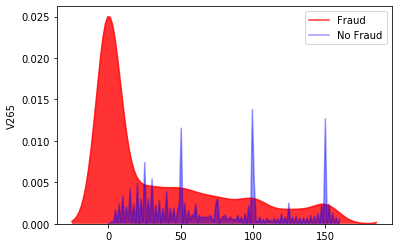

               mean        std  min       max
Fraud      231.9586   459.7584  0.0    5475.0
Not Fraud  146.8717  1666.6393  0.0  153600.0


< V266 >


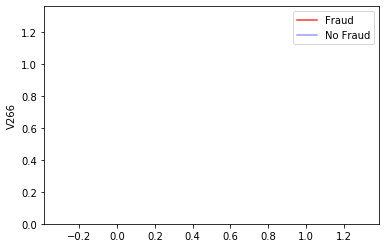

             mean       std  min      max
Fraud      5.4115   28.6668  0.0    635.0
Not Fraud  9.4862  216.5131  0.0  55125.0


< V267 >


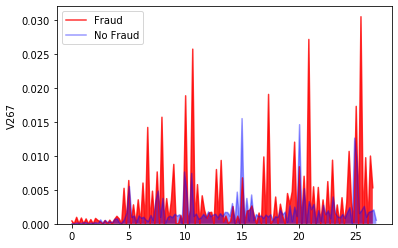

              mean       std  min      max
Fraud      20.1569   80.3936  0.0   1495.0
Not Fraud  37.9126  671.2283  0.0  55125.0


< V268 >


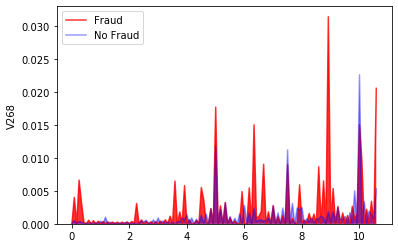

              mean       std  min      max
Fraud      13.2954   63.3436  0.0   1495.0
Not Fraud  19.2811  323.6756  0.0  55125.0


< V269 >


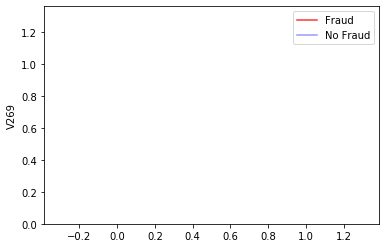

             mean       std  min      max
Fraud      1.7931   22.4231  0.0    635.0
Not Fraud  6.3539  215.8231  0.0  55125.0


< V270 >


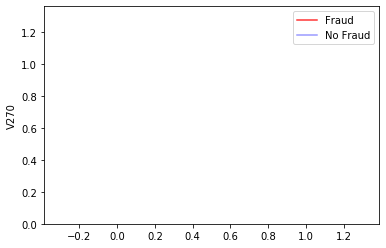

              mean      std  min     max
Fraud      11.2533  48.0692  0.0   800.0
Not Fraud   7.4147  66.7595  0.0  4000.0


< V271 >


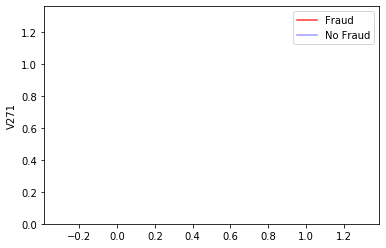

              mean      std  min     max
Fraud      16.4081  74.3542  0.0  1495.0
Not Fraud   8.8589  74.1007  0.0  4000.0


< V272 >


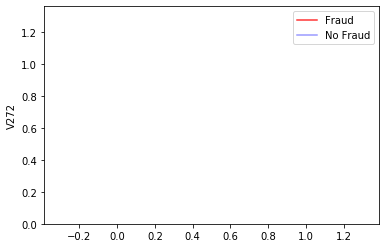

              mean      std  min     max
Fraud      14.5635  68.0297  0.0  1495.0
Not Fraud   7.9511  69.8404  0.0  4000.0


< V273 >


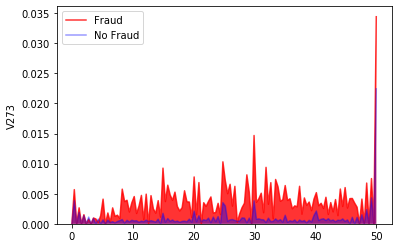

               mean       std  min      max
Fraud      124.1773  302.2724  0.0   5450.0
Not Fraud   69.5575  969.9141  0.0  51200.0


< V274 >


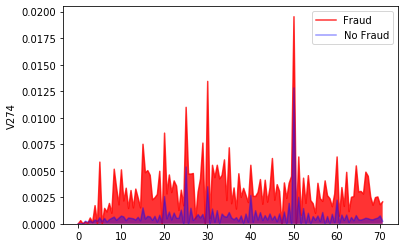

               mean        std  min      max
Fraud      174.2409   373.5626  0.0   5450.0
Not Fraud  101.4648  1306.3208  0.0  66000.0


< V275 >


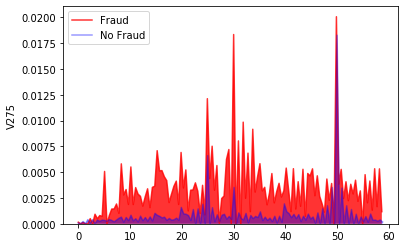

               mean        std  min      max
Fraud      151.9880   339.2199  0.0   5450.0
Not Fraud   83.5523  1112.8933  0.0  51200.0


< V276 >


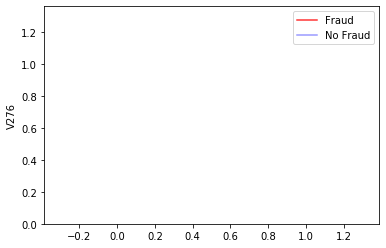

              mean       std  min       max
Fraud      52.2682  207.2455  0.0    4500.0
Not Fraud  30.0621  638.3474  0.0  104060.0


< V277 >


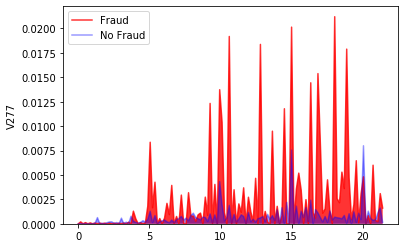

              mean       std  min       max
Fraud      78.9586  307.3704  0.0    6390.0
Not Fraud  49.6678  757.2317  0.0  104060.0


< V278 >


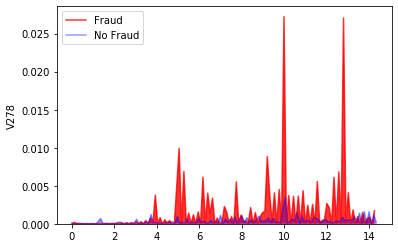

              mean       std  min       max
Fraud      65.1080  247.6875  0.0    4500.0
Not Fraud  40.3973  684.2171  0.0  104060.0


< V279 >


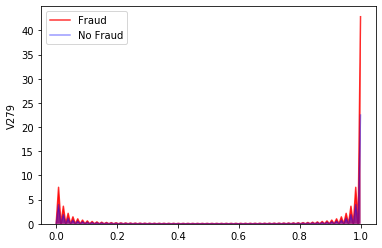

             mean      std  min    max
Fraud      0.7089   1.8941  0.0   55.0
Not Fraud  1.1381  21.3965  0.0  880.0


< V280 >


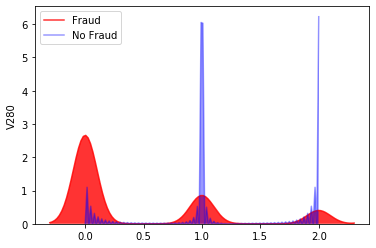

             mean      std  min    max
Fraud      1.8527   8.7971  0.0  243.0
Not Fraud  1.9712  28.3026  0.0  975.0


< V281 >


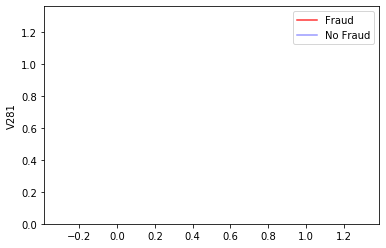

             mean     std  min   max
Fraud      0.2834  0.9969  0.0  15.0
Not Fraud  0.0807  0.4847  0.0  22.0


< V282 >


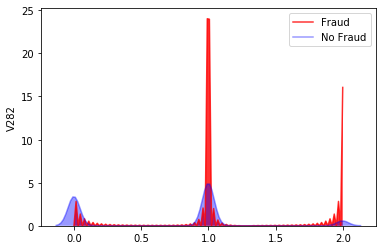

             mean     std  min   max
Fraud      1.3213  1.3297  0.0  16.0
Not Fraud  0.7989  0.8983  0.0  32.0


< V283 >


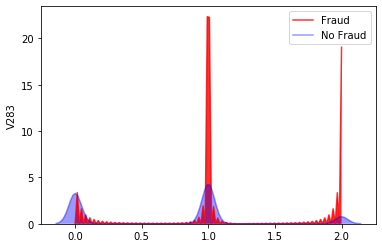

             mean     std  min   max
Fraud      1.9140  2.9330  0.0  46.0
Not Fraud  0.9577  1.4744  0.0  68.0


< V284 >


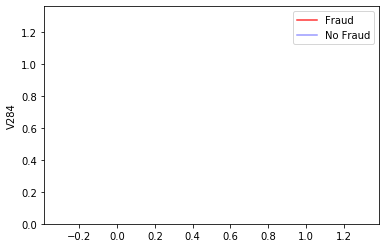

             mean     std  min   max
Fraud      0.1513  0.4356  0.0   6.0
Not Fraud  0.0863  0.3341  0.0  12.0


< V285 >


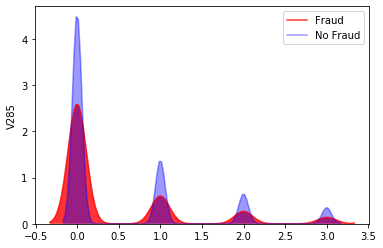

             mean     std  min   max
Fraud      1.0103  2.2037  0.0  22.0
Not Fraud  1.1734  3.3148  0.0  95.0


< V286 >


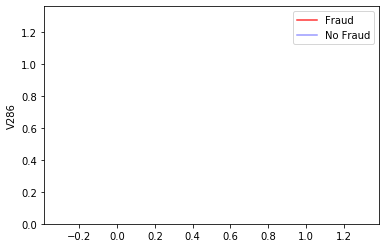

             mean     std  min  max
Fraud      0.0359  0.2028  0.0  3.0
Not Fraud  0.0313  0.1905  0.0  8.0


< V287 >


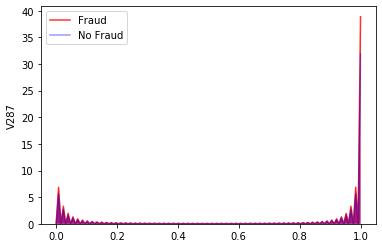

             mean     std  min   max
Fraud      0.4743  0.9992  0.0  16.0
Not Fraud  0.3544  1.0815  0.0  31.0


< V288 >


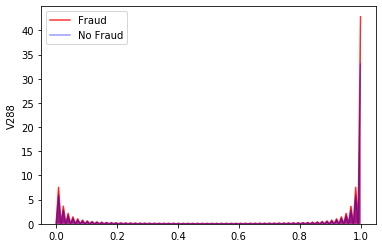

             mean     std  min   max
Fraud      0.2643  0.5263  0.0   4.0
Not Fraud  0.1815  0.4269  0.0  10.0


< V289 >


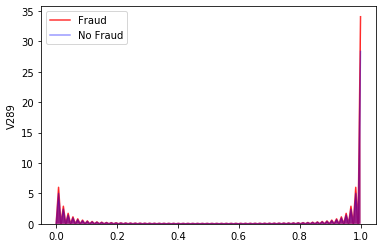

             mean     std  min   max
Fraud      0.3701  0.8050  0.0   7.0
Not Fraud  0.2311  0.5899  0.0  12.0


< V290 >


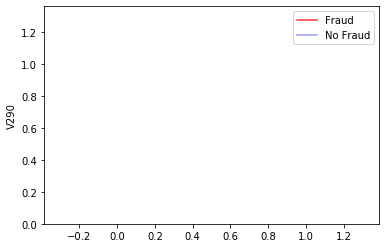

             mean     std  min   max
Fraud      1.2651  1.4333  1.0  56.0
Not Fraud  1.0971  0.7329  1.0  67.0


< V291 >


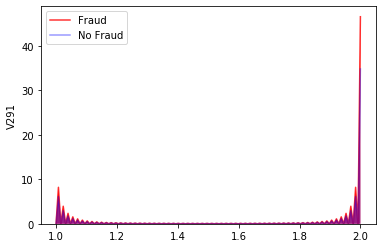

             mean      std  min     max
Fraud      3.4045  38.5603  1.0  1052.0
Not Fraud  1.5966  14.8223  1.0  1055.0


< V292 >


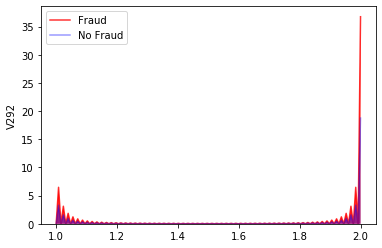

             mean     std  min    max
Fraud      1.7708  8.1737  1.0  244.0
Not Fraud  1.2207  3.5121  1.0  323.0


< V293 >


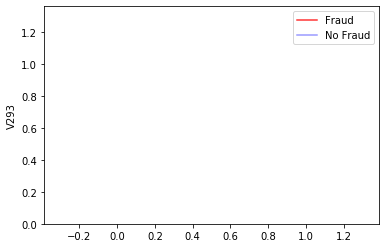

             mean      std  min    max
Fraud      0.4559   1.7135  0.0   55.0
Not Fraud  0.9602  20.9560  0.0  869.0


< V294 >


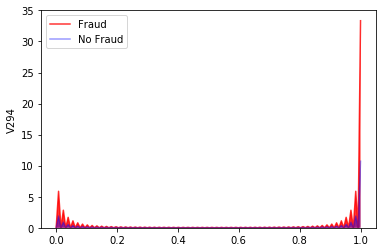

             mean      std  min     max
Fraud      3.1941  38.6564  0.0  1078.0
Not Fraud  2.2819  39.5573  0.0  1286.0


< V295 >


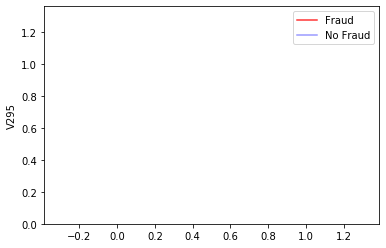

             mean      std  min    max
Fraud      1.2042   8.5249  0.0  243.0
Not Fraud  1.4417  26.3795  0.0  928.0


< V296 >


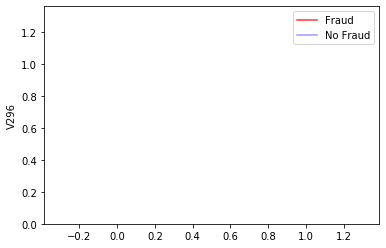

             mean     std  min   max
Fraud      0.4003  2.4813  0.0  61.0
Not Fraud  0.3263  3.2896  0.0  93.0


< V297 >


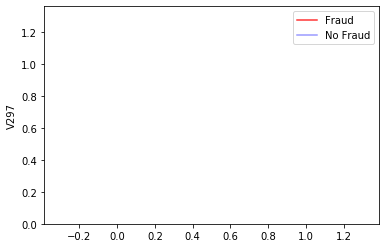

             mean     std  min   max
Fraud      0.0974  0.5040  0.0  12.0
Not Fraud  0.0887  0.6324  0.0  12.0


< V298 >


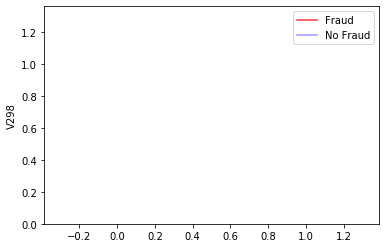

             mean     std  min   max
Fraud      0.3204  1.8485  0.0  47.0
Not Fraud  0.2980  3.2129  0.0  93.0


< V299 >


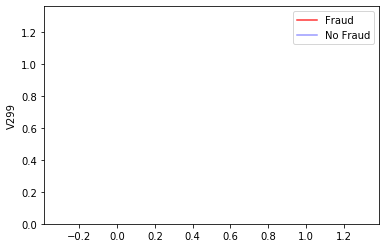

             mean     std  min   max
Fraud      0.1689  0.8815  0.0  23.0
Not Fraud  0.1718  1.7472  0.0  49.0


< V300 >


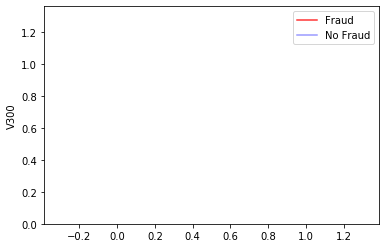

             mean     std  min   max
Fraud      0.0840  0.4208  0.0  11.0
Not Fraud  0.0441  0.2836  0.0  11.0


< V301 >


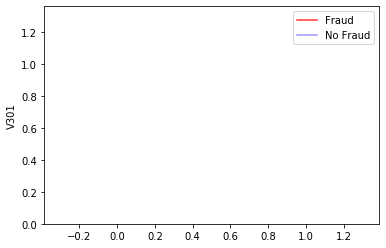

             mean     std  min   max
Fraud      0.1056  0.4942  0.0  11.0
Not Fraud  0.0501  0.3099  0.0  13.0


< V302 >


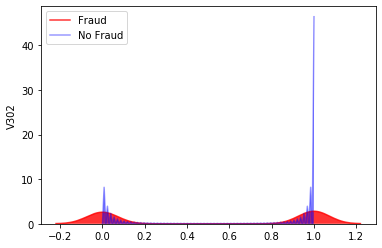

             mean     std  min   max
Fraud      0.5881  0.6050  0.0   7.0
Not Fraud  0.2396  0.4724  0.0  16.0


< V303 >


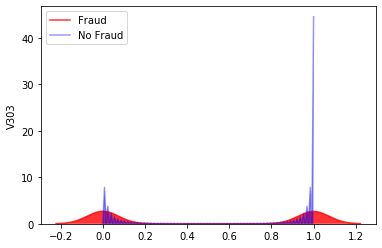

             mean     std  min   max
Fraud      0.6902  0.8465  0.0  15.0
Not Fraud  0.2684  0.6089  0.0  20.0


< V304 >


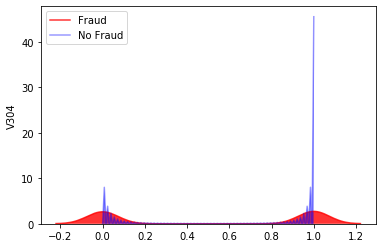

            mean     std  min   max
Fraud      0.629  0.6869  0.0   9.0
Not Fraud  0.251  0.5168  0.0  16.0


< V305 >


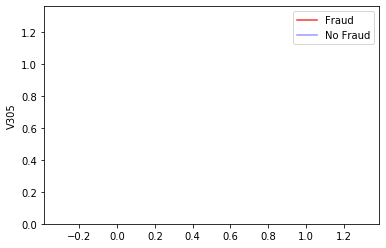

           mean     std  min  max
Fraud       1.0  0.0000  1.0  1.0
Not Fraud   1.0  0.0026  1.0  2.0


< V306 >


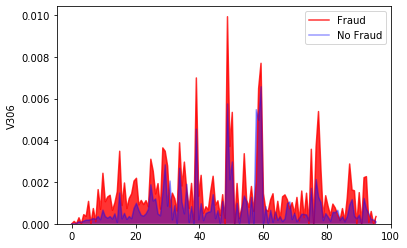

               mean        std  min       max
Fraud      116.7653   402.8697  0.0   11848.0
Not Fraud  140.5820  2389.8154  0.0  108800.0


< V307 >


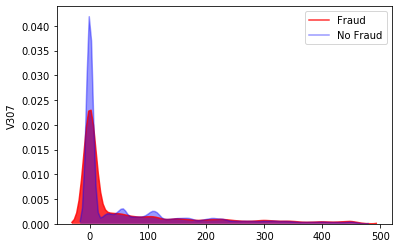

               mean        std  min          max
Fraud      545.8816  3097.8498  0.0   83258.3672
Not Fraud  403.7081  4431.7421  0.0  145765.0000


< V308 >


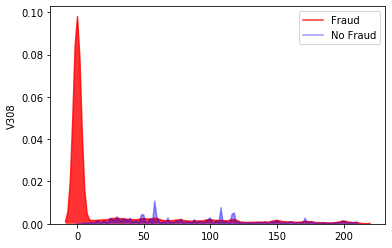

               mean        std  min         max
Fraud      282.0448  1032.6662  0.0   18123.957
Not Fraud  228.5412  3069.9111  0.0  108800.000


< V309 >


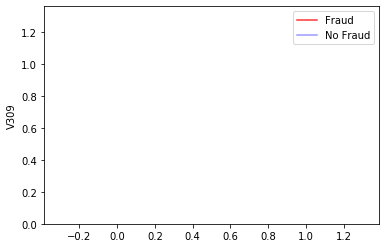

              mean       std  min      max
Fraud      23.3631  104.9104  0.0   2793.0
Not Fraud  10.5476  116.6203  0.0  55125.0


< V310 >


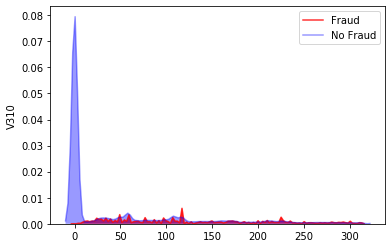

               mean       std  min      max
Fraud      138.7192  402.3082  0.0   5216.0
Not Fraud  117.4516  351.0425  0.0  55125.0


< V311 >


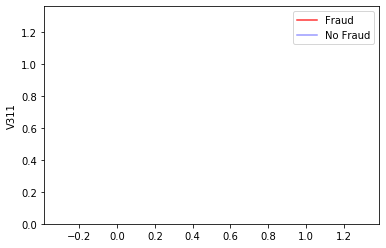

             mean       std  min      max
Fraud      4.9012   42.3402  0.0   1448.5
Not Fraud  4.1768  103.9019  0.0  55125.0


< V312 >


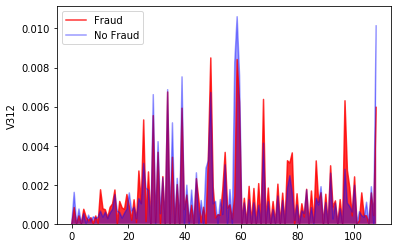

              mean       std  min      max
Fraud      73.1441  221.4904  0.0   3981.0
Not Fraud  37.9423  169.9425  0.0  55125.0


< V313 >


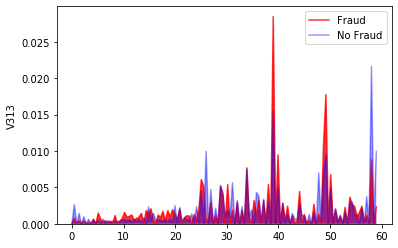

              mean       std  min        max
Fraud      42.2507  139.5587  0.0  2652.0000
Not Fraud  20.5938   93.8527  0.0  4817.4702


< V314 >


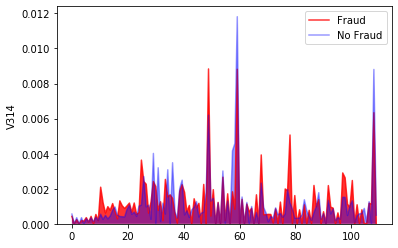

              mean       std  min        max
Fraud      78.4564  258.4461  0.0  3981.0000
Not Fraud  42.0452  169.6128  0.0  7519.8701


< V315 >


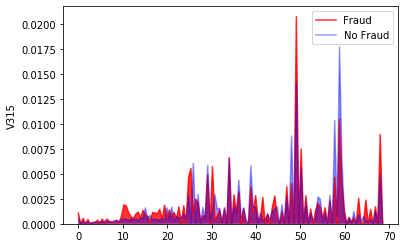

              mean       std  min        max
Fraud      56.4472  187.1140  0.0  3981.0000
Not Fraud  25.7323  113.3464  0.0  4817.4702


< V316 >


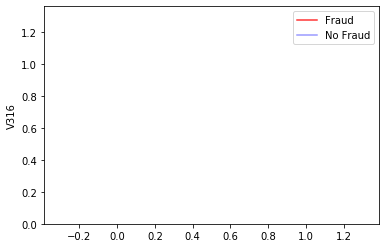

               mean        std  min      max
Fraud       74.5266   336.0816  0.0  11848.0
Not Fraud  111.0981  2309.9215  0.0  93736.0


< V317 >


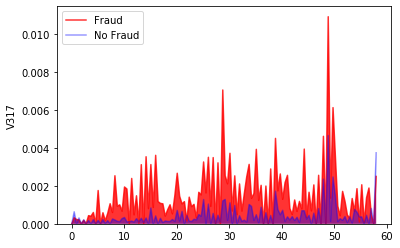

               mean        std  min          max
Fraud      352.3233  2912.6084  0.0   82130.9531
Not Fraud  243.8102  4013.3645  0.0  134021.0000


< V318 >


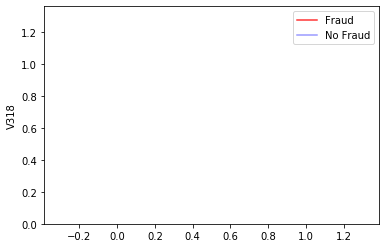

               mean        std  min        max
Fraud      176.7815   894.1335  0.0  18123.957
Not Fraud  161.6230  2838.4279  0.0  98476.000


< V319 >


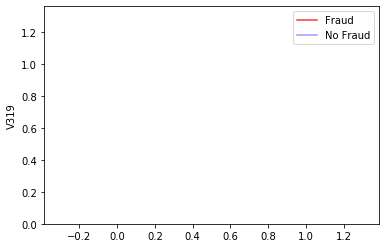

              mean       std  min          max
Fraud      18.4785  123.6530  0.0    4528.8999
Not Fraud  18.3686  337.4549  0.0  104060.0000


< V320 >


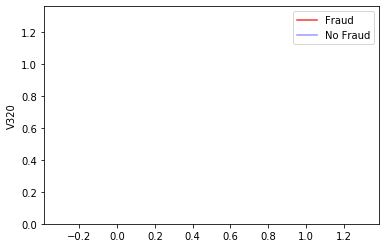

              mean       std  min       max
Fraud      54.4095  307.3512  0.0    5794.5
Not Fraud  41.6259  478.4347  0.0  104060.0


< V321 >


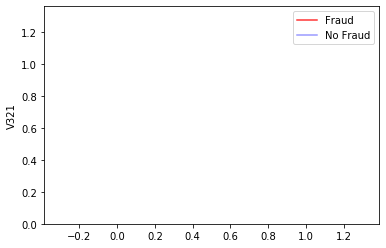

              mean       std  min          max
Fraud      31.6917  177.8314  0.0    4528.8999
Not Fraud  28.2046  387.4400  0.0  104060.0000


< V322 >


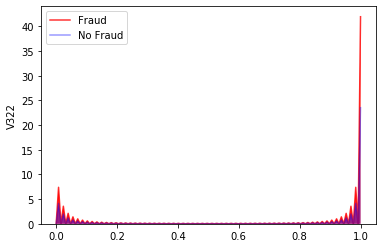

             mean      std  min    max
Fraud      0.6454   1.3715  0.0   16.0
Not Fraud  6.4815  57.3060  0.0  880.0


< V323 >


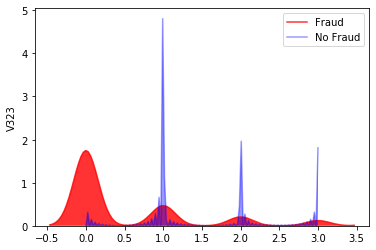

              mean       std  min     max
Fraud       1.6004    3.7098  0.0    34.0
Not Fraud  13.6428  109.1793  0.0  1411.0


< V324 >


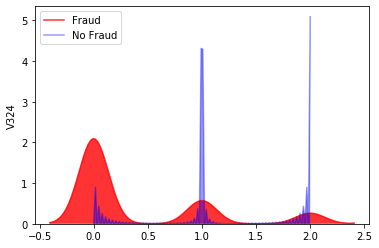

             mean      std  min    max
Fraud      1.0193   2.2576  0.0   24.0
Not Fraud  9.5672  75.3099  0.0  976.0


< V325 >


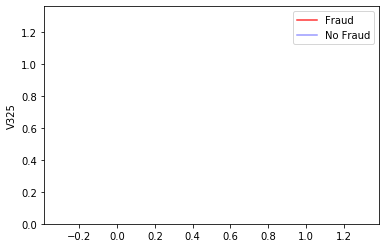

             mean     std  min   max
Fraud      0.0695  0.3549  0.0   6.0
Not Fraud  0.0580  0.3018  0.0  12.0


< V326 >


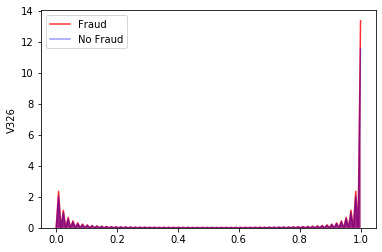

             mean     std  min   max
Fraud      0.7263  2.7882  0.0  27.0
Not Fraud  0.8569  3.9964  0.0  44.0


< V327 >


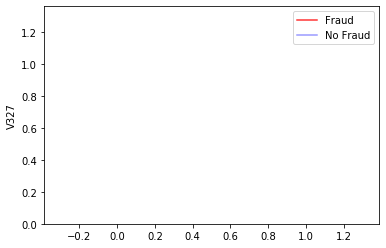

             mean     std  min   max
Fraud      0.2900  1.2577  0.0  18.0
Not Fraud  0.2969  1.3692  0.0  14.0


< V328 >


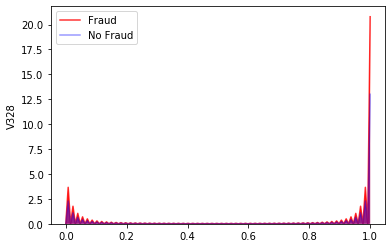

             mean     std  min   max
Fraud      0.2561  0.7866  0.0  11.0
Not Fraud  0.3406  1.6077  0.0  15.0


< V329 >


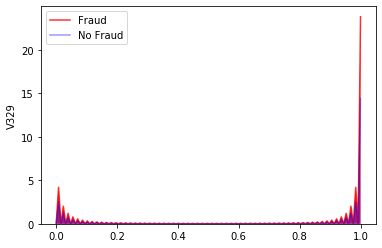

             mean     std  min   max
Fraud      0.3771  1.0635  0.0  13.0
Not Fraud  1.3567  8.9668  0.0  99.0


< V330 >


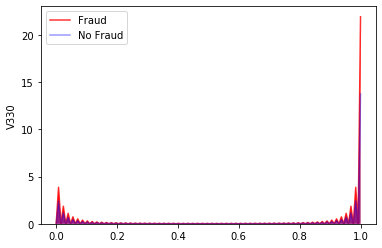

             mean     std  min   max
Fraud      0.3136  0.9605  0.0  13.0
Not Fraud  0.7975  4.8319  0.0  55.0


< V331 >


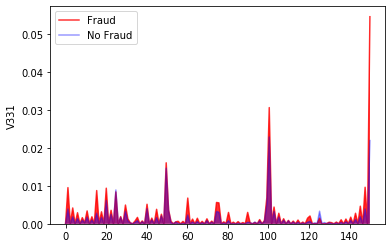

               mean       std  min       max
Fraud       90.3847   227.643  0.0    2600.0
Not Fraud  751.3253  6359.490  0.0  160000.0


< V332 >


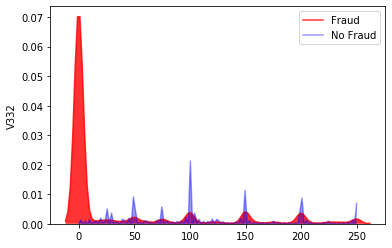

                mean         std  min       max
Fraud       164.8595    436.2871  0.0    4700.0
Not Fraud  1432.5238  11424.4246  0.0  160000.0


< V333 >


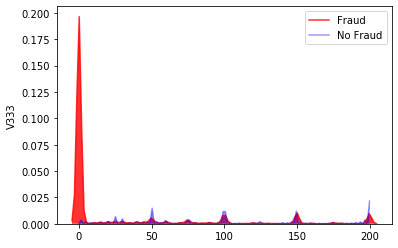

                mean        std  min       max
Fraud       127.6337   339.8569  0.0    4285.0
Not Fraud  1056.1844  8137.2914  0.0  160000.0


< V334 >


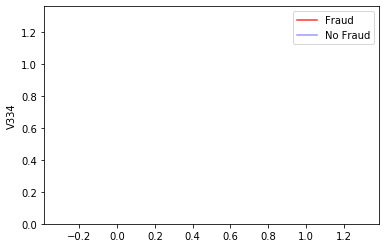

             mean       std  min      max
Fraud      9.2992   51.5020  0.0    635.0
Not Fraud  9.8308  249.2602  0.0  55125.0


< V335 >


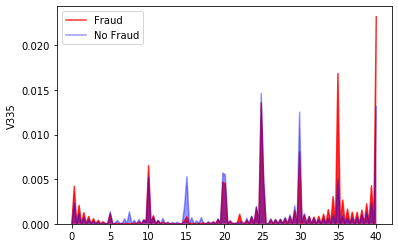

              mean       std  min      max
Fraud      49.3945  201.8483  0.0   2430.0
Not Fraud  59.6223  394.1878  0.0  55125.0


< V336 >


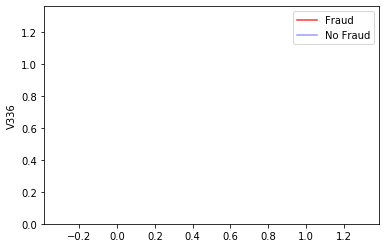

              mean       std  min      max
Fraud      25.4840  117.9390  0.0   1605.0
Not Fraud  28.6737  279.7734  0.0  55125.0


< V337 >


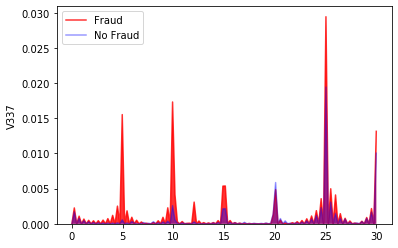

              mean       std  min       max
Fraud      37.7423  142.5052  0.0    2200.0
Not Fraud  56.1776  683.2624  0.0  104060.0


< V338 >


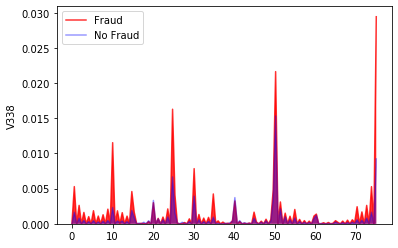

               mean        std  min       max
Fraud       53.2423   190.2504  0.0    2400.0
Not Fraud  155.7487  1119.4290  0.0  104060.0


< V339 >


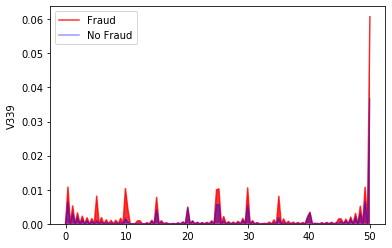

               mean       std  min       max
Fraud       45.4965  175.9663  0.0    2400.0
Not Fraud  103.2876  832.8613  0.0  104060.0


< id_01 >


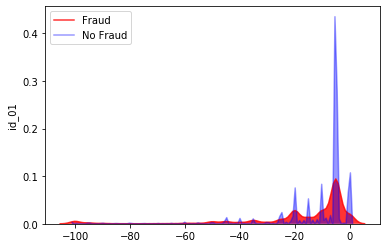

              mean      std    min  max
Fraud     -16.0756  20.3975 -100.0  0.0
Not Fraud  -9.6677  13.5921 -100.0  0.0


< id_02 >


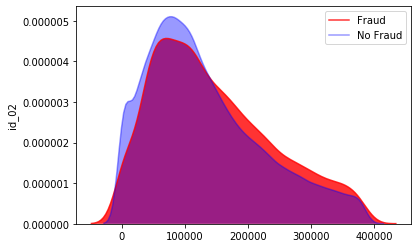

                  mean          std  min       max
Fraud      201522.5692  173522.0038  1.0  998295.0
Not Fraud  172396.3629  158181.4159  2.0  999595.0


< id_03 >


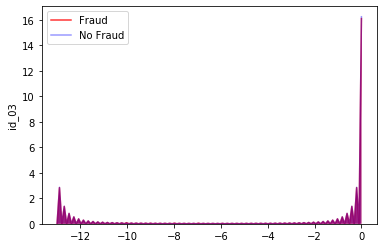

             mean     std   min   max
Fraud      0.1317  1.1586 -13.0   7.0
Not Fraud  0.0516  0.4888 -13.0  10.0


< id_04 >


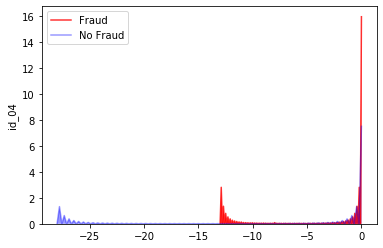

             mean     std   min  max
Fraud     -0.1797  1.3157 -13.0  0.0
Not Fraud -0.0444  0.5836 -28.0  0.0


< id_05 >


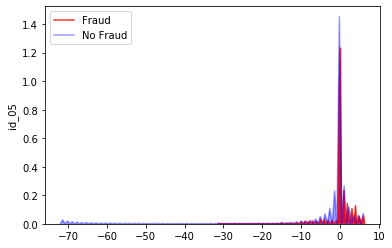

             mean     std   min   max
Fraud      1.4738  5.2971 -31.0  44.0
Not Fraud  1.6280  5.2456 -72.0  52.0


< id_06 >


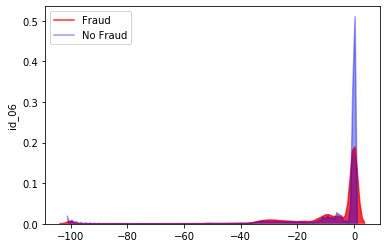

             mean      std    min  max
Fraud     -8.2140  16.9662 -100.0  0.0
Not Fraud -6.5665  16.4425 -100.0  0.0


< id_07 >


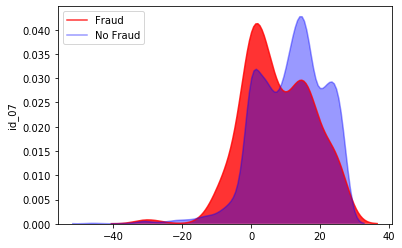

              mean      std   min   max
Fraud      10.0704  12.3557 -31.0  44.0
Not Fraud  13.5750  11.2490 -46.0  61.0


< id_08 >


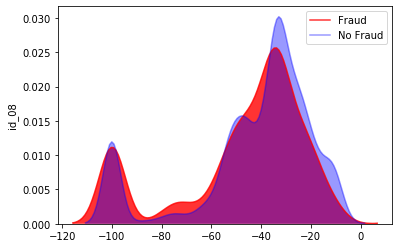

              mean     std    min  max
Fraud     -43.5962  27.651 -100.0  0.0
Not Fraud -38.1503  25.895 -100.0  0.0


< id_09 >


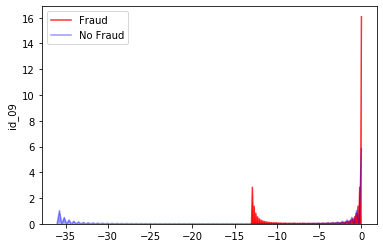

             mean     std   min   max
Fraud      0.1758  1.2594 -13.0   8.0
Not Fraud  0.0811  0.9460 -36.0  25.0


< id_10 >


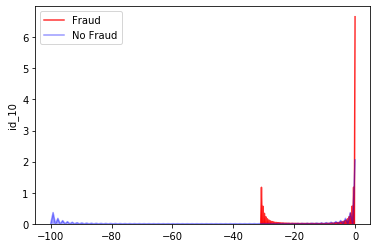

             mean     std    min  max
Fraud     -0.2109  1.4641  -31.0  0.0
Not Fraud -0.3116  2.9048 -100.0  0.0


< id_11 >


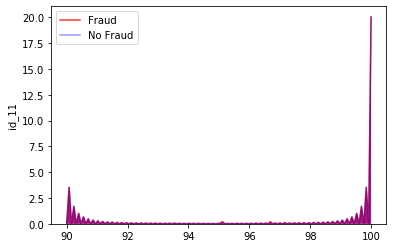

              mean     std   min    max
Fraud      99.7757  1.0103  90.0  100.0
Not Fraud  99.7427  1.1371  90.0  100.0


< id_13 >


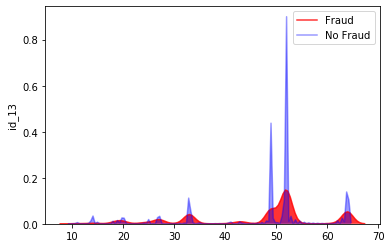

              mean      std   min   max
Fraud      47.2892  12.3147  11.0  64.0
Not Fraud  48.1224  11.7223  10.0  64.0


< id_14 >


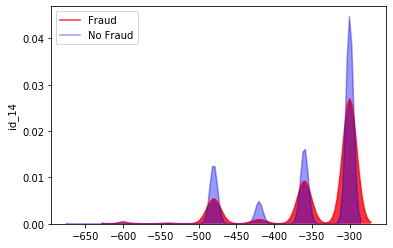

               mean       std    min    max
Fraud     -319.6815  116.6105 -600.0  540.0
Not Fraud -345.6691   92.3215 -660.0  720.0


< id_17 >


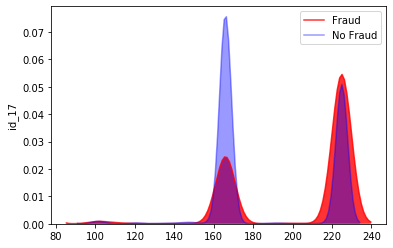

               mean      std    min    max
Fraud      204.9914  29.8225  100.0  226.0
Not Fraud  188.1137  30.0492  100.0  229.0


< id_18 >


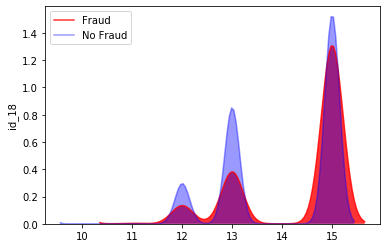

              mean     std   min   max
Fraud      14.4972  1.4210  11.0  29.0
Not Fraud  14.2139  1.5713  10.0  29.0


< id_19 >


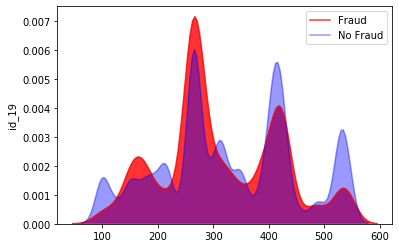

               mean       std    min    max
Fraud      333.0602  126.1135  100.0  667.0
Not Fraud  354.8550  142.1790  100.0  671.0


< id_20 >


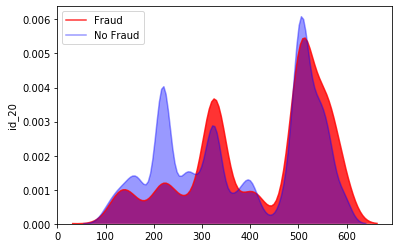

               mean       std    min    max
Fraud      435.8380  140.3036  100.0  657.0
Not Fraud  401.1337  152.8261  100.0  661.0


< id_21 >


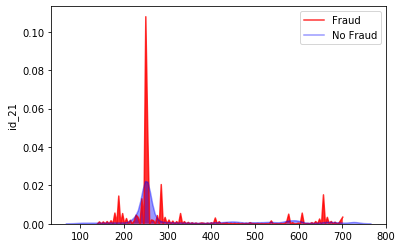

               mean       std    min    max
Fraud      410.3826  241.1172  142.0  854.0
Not Fraud  364.4794  194.1756  100.0  854.0


< id_22 >


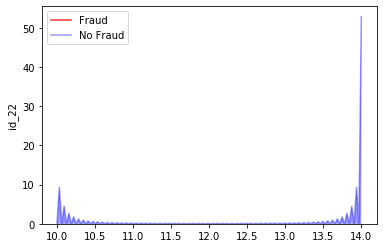

              mean     std   min   max
Fraud      18.7277  9.9862  14.0  42.0
Not Fraud  15.7580  6.4952  10.0  44.0


< id_24 >


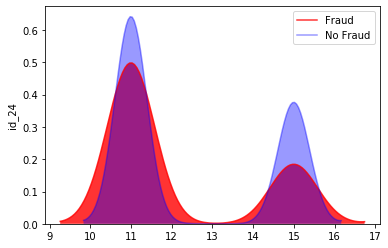

              mean     std   min   max
Fraud      12.7861  2.9936  11.0  26.0
Not Fraud  12.8023  2.3070  11.0  26.0


< id_25 >


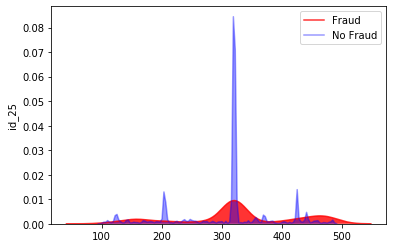

               mean       std    min    max
Fraud      340.7650  103.2035  104.0  539.0
Not Fraud  328.6223   96.8866  100.0  548.0


< id_26 >


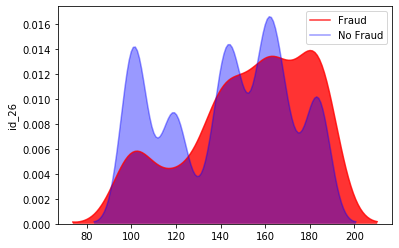

               mean      std    min    max
Fraud      159.7435  31.7685  100.0  216.0
Not Fraud  148.1129  31.9613  100.0  216.0


< id_32 >


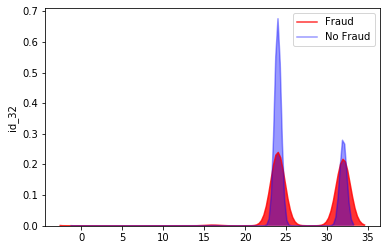

              mean     std  min   max
Fraud      27.7160  4.1545  0.0  32.0
Not Fraud  26.4524  3.7074  0.0  32.0


In [73]:
for cols in X_train.select_dtypes(['float']).columns:
    
    print("\n\n< {} >".format(cols))
    sns.kdeplot(df[(df[cols] <= df[cols].quantile(0.9))&(df['isFraud']==1)][cols],color='red',  shade=True, **{"label": "Fraud",'alpha':0.8})
    sns.kdeplot(df[(df[cols] <= df[cols].quantile(0.9))&(df['isFraud']==0)][cols],color='blue',shade=True,**{"label": "No Fraud",'alpha':0.4})
    plt.ylabel(cols)
    plt.show()
        
    f = df[df['isFraud']==1][cols].describe()
    nf = df[df['isFraud']==0][cols].describe()
        
    f_desc = {}
    
    f_desc['mean'] = round(f['mean'],4)
    f_desc['std'] = round(f['std'],4)
    f_desc['min'] = round(f['min'],4)
    f_desc['max'] = round(f['max'],4)
        
    nf_desc = {}
    
    nf_desc['mean'] = round(nf['mean'],4)
    nf_desc['std'] = round(nf['std'],4)
    nf_desc['min'] = round(nf['min'],4)
    nf_desc['max'] = round(nf['max'],4)
    
    
    results_desc = pd.DataFrame([f_desc,
                              nf_desc],                             
                            index=['Fraud',
                                   'Not Fraud'
                                   ])
    print(results_desc)
    
    